In [1]:
# Cell 1:imports

import os, random, time, math, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
import torchvision.models as models

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
import umap.umap_ as umap

torch.__version__, models.__version__ if hasattr(models, "__version__") else "tv"


2025-09-12 20:54:18.082207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757710458.319622      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757710458.398684      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


('2.6.0+cu124', 'tv')

In [2]:
#Cell 2: Device & Paths

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_DIR = "/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images"
SAVE_DIR = "/kaggle/working"
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"Device: {DEVICE}")


Device: cuda


In [3]:
#Cell 3: Hyperparameters & Seeding

SEED = 42
BATCH_SIZE_SSL = 64           # for MoCo pretraining
BATCH_SIZE_SUP = 64           # for supervised eval/test
EPOCHS_SSL = 2000             # MoCo pretraining epochs
EPOCHS_LINEAR = 2000        # linear eval epochs

FEATURE_DIM = 512             # ResNet-18 penultimate feature size
PROJ_DIM = 128                # projection dim for MoCo
IMG_SIZE = 224
LR_SSL = 3e-4
LR_LINEAR = 3e-4

# MoCo-specific
MOMENTUM = 0.999              # momentum for key encoder
QUEUE_SIZE = 1024             # dictionary size
TEMPERATURE = 0.2             # contrastive temperature

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


In [4]:
#Cell 4: Small Utils

def set_seed(seed=SEED):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def plot_curve(values, title, xlab="Epoch", ylab="Value"):
    plt.figure()
    plt.plot(range(1, len(values)+1), values)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.grid(True)
    plt.show()


In [5]:
# Cell 5: Transforms

# Two random augmentations for MoCo (query & key)
class TwoCropsTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform
    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return q, k

# MoCo augmentations (SimCLR-style are fine for MoCo too)
ssl_transform = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    T.RandomGrayscale(p=0.2),
    T.GaussianBlur(kernel_size=3),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

# Supervised (linear eval/test) transform
SUPERVISED_TRANSFORM = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])


In [6]:
# Cell 6: Datasets & 50/50 Split + Loaders

# Full supervised dataset (for splits & labels)
full_dataset_supervised = ImageFolder(root=DATA_DIR, transform=SUPERVISED_TRANSFORM)
CLASS_TO_IDX = full_dataset_supervised.class_to_idx
IDX_TO_CLASS = {v:k for k,v in CLASS_TO_IDX.items()}
NUM_CLASSES = len(CLASS_TO_IDX)
print("Classes:", CLASS_TO_IDX)

# 50% train, 50% test
n_total = len(full_dataset_supervised)
n_train = int(0.5 * n_total)
n_test = n_total - n_train

train_sup, test_sup = random_split(
    full_dataset_supervised, [n_train, n_test],
    generator=torch.Generator().manual_seed(SEED)
)

# SSL dataset: same images but produces (q,k) pairs
ssl_dataset = ImageFolder(root=DATA_DIR, transform=TwoCropsTransform(ssl_transform))
ssl_train_subset = Subset(ssl_dataset, train_sup.indices)

# DataLoaders
ssl_train_loader = DataLoader(ssl_train_subset, batch_size=BATCH_SIZE_SSL, shuffle=True,
                              num_workers=2, drop_last=True)

train_loader = DataLoader(train_sup, batch_size=BATCH_SIZE_SUP, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_sup,  batch_size=BATCH_SIZE_SUP, shuffle=False, num_workers=2)

# For visualizations (t-SNE/UMAP) over train portion
vis_loader = DataLoader(train_sup, batch_size=BATCH_SIZE_SUP, shuffle=False, num_workers=2)

print(f"Total: {n_total} | Train: {len(train_sup)} | Test: {len(test_sup)}")


Classes: {'Monkeypox_augmented': 0, 'Others_augmented': 1}
Total: 3192 | Train: 1596 | Test: 1596


In [7]:
# Cell 7: MoCo Definition (ResNet-18 Backbones)

class MoCo(nn.Module):
    """
    Minimal MoCo v1-style implementation:
    - encoder_q: online (query) encoder
    - encoder_k: momentum (key) encoder
    - queue: negative dictionary
    """
    def __init__(self, base_encoder, feature_dim=128, K=1024, m=0.999, T=0.5):
        super().__init__()
        self.K = K
        self.m = m
        self.T = T

        # Build encoders: output = feature_dim
        self.encoder_q = base_encoder(num_classes=feature_dim)
        self.encoder_k = base_encoder(num_classes=feature_dim)

        # Initialize encoder_k to encoder_q, and set to not require grad
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

        # Create the queue
        self.register_buffer("queue", torch.randn(feature_dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """Momentum update key encoder."""
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        """Enqueue the current keys and dequeue the oldest ones."""
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)
        # For simplicity, require queue size divisible by batch size
        if self.K % batch_size != 0:
            # If not divisible, only fill to the end
            end = min(ptr + batch_size, self.K)
            span = end - ptr
            self.queue[:, ptr:end] = keys[:span].T
            ptr = end % self.K
            self.queue_ptr[0] = ptr
            return

        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K
        self.queue_ptr[0] = ptr

    def forward(self, im_q, im_k):
        # Compute query features
        q = self.encoder_q(im_q)
        q = nn.functional.normalize(q, dim=1)

        # Compute key features with momentum encoder (no grad)
        with torch.no_grad():
            self._momentum_update_key_encoder()
            k = self.encoder_k(im_k)
            k = nn.functional.normalize(k, dim=1)

        # Positive logits: Nx1
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        # Negative logits: NxK
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])

        # Concatenate and apply temperature
        logits = torch.cat([l_pos, l_neg], dim=1)
        logits /= self.T

        # Labels: positives are the 0-th
        labels = torch.zeros(logits.shape[0], dtype=torch.long, device=logits.device)

        # Update dictionary
        self._dequeue_and_enqueue(k)

        return logits, labels

def resnet18_moco(num_classes=128):
    """ResNet-18 backbone with final fc replaced by projection to num_classes."""
    model = models.resnet18(weights=None)
    dim_mlp = model.fc.in_features
    model.fc = nn.Linear(dim_mlp, num_classes)
    return model


In [8]:
# Cell 8: Train MoCo Pretraining

moco = MoCo(base_encoder=resnet18_moco, feature_dim=PROJ_DIM,
            K=QUEUE_SIZE, m=MOMENTUM, T=TEMPERATURE).to(DEVICE)

opt_moco = torch.optim.Adam(moco.parameters(), lr=LR_SSL)
moco_loss_history = []

print("Starting MoCo pretraining...")
for epoch in range(1, EPOCHS_SSL + 1):
    moco.train()
    running = 0.0
    for (im_q, im_k), _ in tqdm(ssl_train_loader, desc=f"MoCo Epoch {epoch}/{EPOCHS_SSL}"):
        im_q, im_k = im_q.to(DEVICE), im_k.to(DEVICE)
        logits, labels = moco(im_q, im_k)
        loss = F.cross_entropy(logits, labels)

        opt_moco.zero_grad()
        loss.backward()
        opt_moco.step()

        running += loss.item() * im_q.size(0)

    epoch_loss = running / len(ssl_train_loader.dataset)
    moco_loss_history.append(epoch_loss)
    print(f"MoCo Epoch {epoch}: loss={epoch_loss:.4f}")

# Save the query encoder (backbone+proj) – we will load as backbone and strip fc
torch.save(moco.encoder_q.state_dict(), os.path.join(SAVE_DIR, "moco_resnet18_encoder.pth"))
print("Saved MoCo encoder to:", os.path.join(SAVE_DIR, "moco_resnet18_encoder.pth"))


Starting MoCo pretraining...


MoCo Epoch 1/2000: 100%|██████████| 24/24 [00:20<00:00,  1.17it/s]


MoCo Epoch 1: loss=5.7571


MoCo Epoch 2/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 2: loss=6.2816


MoCo Epoch 3/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 3: loss=6.2152


MoCo Epoch 4/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 4: loss=6.1352


MoCo Epoch 5/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 5: loss=6.1158


MoCo Epoch 6/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 6: loss=6.0811


MoCo Epoch 7/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 7: loss=6.0132


MoCo Epoch 8/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 8: loss=5.9849


MoCo Epoch 9/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 9: loss=5.9447


MoCo Epoch 10/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 10: loss=5.9038


MoCo Epoch 11/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 11: loss=5.8882


MoCo Epoch 12/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 12: loss=5.8322


MoCo Epoch 13/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 13: loss=5.8198


MoCo Epoch 14/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 14: loss=5.7917


MoCo Epoch 15/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 15: loss=5.7769


MoCo Epoch 16/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 16: loss=5.7256


MoCo Epoch 17/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 17: loss=5.7149


MoCo Epoch 18/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 18: loss=5.6985


MoCo Epoch 19/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 19: loss=5.6762


MoCo Epoch 20/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 20: loss=5.6381


MoCo Epoch 21/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 21: loss=5.6195


MoCo Epoch 22/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 22: loss=5.6493


MoCo Epoch 23/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 23: loss=5.5623


MoCo Epoch 24/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 24: loss=5.6253


MoCo Epoch 25/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 25: loss=5.5481


MoCo Epoch 26/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 26: loss=5.5527


MoCo Epoch 27/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 27: loss=5.5369


MoCo Epoch 28/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 28: loss=5.4451


MoCo Epoch 29/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 29: loss=5.5121


MoCo Epoch 30/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 30: loss=5.4909


MoCo Epoch 31/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 31: loss=5.3819


MoCo Epoch 32/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 32: loss=5.4365


MoCo Epoch 33/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 33: loss=5.3891


MoCo Epoch 34/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 34: loss=5.4044


MoCo Epoch 35/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 35: loss=5.3159


MoCo Epoch 36/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 36: loss=5.3302


MoCo Epoch 37/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 37: loss=5.2941


MoCo Epoch 38/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 38: loss=5.3326


MoCo Epoch 39/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 39: loss=5.2438


MoCo Epoch 40/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 40: loss=5.2912


MoCo Epoch 41/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 41: loss=5.2699


MoCo Epoch 42/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 42: loss=5.2322


MoCo Epoch 43/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 43: loss=5.1667


MoCo Epoch 44/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 44: loss=5.2152


MoCo Epoch 45/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 45: loss=5.2427


MoCo Epoch 46/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 46: loss=5.1469


MoCo Epoch 47/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 47: loss=5.1616


MoCo Epoch 48/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 48: loss=5.1702


MoCo Epoch 49/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 49: loss=5.0974


MoCo Epoch 50/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 50: loss=5.0837


MoCo Epoch 51/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 51: loss=5.0518


MoCo Epoch 52/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 52: loss=5.0761


MoCo Epoch 53/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 53: loss=5.0642


MoCo Epoch 54/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 54: loss=5.0179


MoCo Epoch 55/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 55: loss=4.9792


MoCo Epoch 56/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 56: loss=4.9901


MoCo Epoch 57/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 57: loss=5.0035


MoCo Epoch 58/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 58: loss=4.9605


MoCo Epoch 59/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 59: loss=4.9830


MoCo Epoch 60/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 60: loss=5.0060


MoCo Epoch 61/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 61: loss=4.9218


MoCo Epoch 62/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 62: loss=4.8750


MoCo Epoch 63/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 63: loss=4.8849


MoCo Epoch 64/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 64: loss=4.9002


MoCo Epoch 65/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 65: loss=4.8762


MoCo Epoch 66/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 66: loss=4.8779


MoCo Epoch 67/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 67: loss=4.8751


MoCo Epoch 68/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 68: loss=4.8356


MoCo Epoch 69/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 69: loss=4.8355


MoCo Epoch 70/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 70: loss=4.7838


MoCo Epoch 71/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 71: loss=4.8197


MoCo Epoch 72/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 72: loss=4.8265


MoCo Epoch 73/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 73: loss=4.7462


MoCo Epoch 74/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 74: loss=4.7804


MoCo Epoch 75/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 75: loss=4.7322


MoCo Epoch 76/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 76: loss=4.7240


MoCo Epoch 77/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 77: loss=4.7389


MoCo Epoch 78/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 78: loss=4.6956


MoCo Epoch 79/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 79: loss=4.7147


MoCo Epoch 80/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 80: loss=4.7420


MoCo Epoch 81/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 81: loss=4.7350


MoCo Epoch 82/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 82: loss=4.6922


MoCo Epoch 83/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 83: loss=4.6951


MoCo Epoch 84/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 84: loss=4.6672


MoCo Epoch 85/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 85: loss=4.6328


MoCo Epoch 86/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 86: loss=4.6357


MoCo Epoch 87/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 87: loss=4.6599


MoCo Epoch 88/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 88: loss=4.6190


MoCo Epoch 89/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 89: loss=4.6628


MoCo Epoch 90/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 90: loss=4.6425


MoCo Epoch 91/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 91: loss=4.5951


MoCo Epoch 92/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 92: loss=4.6110


MoCo Epoch 93/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 93: loss=4.5662


MoCo Epoch 94/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 94: loss=4.5438


MoCo Epoch 95/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 95: loss=4.5728


MoCo Epoch 96/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 96: loss=4.5738


MoCo Epoch 97/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 97: loss=4.5692


MoCo Epoch 98/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 98: loss=4.5606


MoCo Epoch 99/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 99: loss=4.5394


MoCo Epoch 100/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 100: loss=4.5251


MoCo Epoch 101/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 101: loss=4.5207


MoCo Epoch 102/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 102: loss=4.5410


MoCo Epoch 103/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 103: loss=4.5025


MoCo Epoch 104/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 104: loss=4.5152


MoCo Epoch 105/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 105: loss=4.5236


MoCo Epoch 106/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 106: loss=4.5016


MoCo Epoch 107/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 107: loss=4.4651


MoCo Epoch 108/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 108: loss=4.4827


MoCo Epoch 109/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 109: loss=4.4581


MoCo Epoch 110/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 110: loss=4.4241


MoCo Epoch 111/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 111: loss=4.4730


MoCo Epoch 112/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 112: loss=4.4641


MoCo Epoch 113/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 113: loss=4.3998


MoCo Epoch 114/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 114: loss=4.4659


MoCo Epoch 115/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 115: loss=4.4420


MoCo Epoch 116/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 116: loss=4.4077


MoCo Epoch 117/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 117: loss=4.3791


MoCo Epoch 118/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 118: loss=4.4142


MoCo Epoch 119/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 119: loss=4.3905


MoCo Epoch 120/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 120: loss=4.3852


MoCo Epoch 121/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 121: loss=4.4141


MoCo Epoch 122/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 122: loss=4.3875


MoCo Epoch 123/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 123: loss=4.3899


MoCo Epoch 124/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 124: loss=4.3735


MoCo Epoch 125/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 125: loss=4.3281


MoCo Epoch 126/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 126: loss=4.3169


MoCo Epoch 127/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 127: loss=4.3643


MoCo Epoch 128/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 128: loss=4.2949


MoCo Epoch 129/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 129: loss=4.3126


MoCo Epoch 130/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 130: loss=4.3067


MoCo Epoch 131/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 131: loss=4.2805


MoCo Epoch 132/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 132: loss=4.2994


MoCo Epoch 133/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 133: loss=4.2914


MoCo Epoch 134/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 134: loss=4.2691


MoCo Epoch 135/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 135: loss=4.2640


MoCo Epoch 136/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 136: loss=4.2497


MoCo Epoch 137/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 137: loss=4.2580


MoCo Epoch 138/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 138: loss=4.2939


MoCo Epoch 139/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 139: loss=4.2318


MoCo Epoch 140/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 140: loss=4.2613


MoCo Epoch 141/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 141: loss=4.2524


MoCo Epoch 142/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 142: loss=4.2461


MoCo Epoch 143/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 143: loss=4.2109


MoCo Epoch 144/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 144: loss=4.1997


MoCo Epoch 145/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 145: loss=4.2077


MoCo Epoch 146/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 146: loss=4.2234


MoCo Epoch 147/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 147: loss=4.1695


MoCo Epoch 148/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 148: loss=4.1730


MoCo Epoch 149/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 149: loss=4.1867


MoCo Epoch 150/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 150: loss=4.1689


MoCo Epoch 151/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 151: loss=4.1588


MoCo Epoch 152/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 152: loss=4.1318


MoCo Epoch 153/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 153: loss=4.1296


MoCo Epoch 154/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 154: loss=4.1330


MoCo Epoch 155/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 155: loss=4.1084


MoCo Epoch 156/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 156: loss=4.1215


MoCo Epoch 157/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 157: loss=4.1770


MoCo Epoch 158/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 158: loss=4.1409


MoCo Epoch 159/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 159: loss=4.0957


MoCo Epoch 160/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 160: loss=4.1154


MoCo Epoch 161/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 161: loss=4.0852


MoCo Epoch 162/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 162: loss=4.0612


MoCo Epoch 163/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 163: loss=4.1110


MoCo Epoch 164/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 164: loss=4.0819


MoCo Epoch 165/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 165: loss=4.0594


MoCo Epoch 166/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 166: loss=4.0746


MoCo Epoch 167/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 167: loss=4.0926


MoCo Epoch 168/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 168: loss=4.0897


MoCo Epoch 169/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 169: loss=4.0757


MoCo Epoch 170/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 170: loss=4.1033


MoCo Epoch 171/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 171: loss=4.0443


MoCo Epoch 172/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 172: loss=4.0608


MoCo Epoch 173/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 173: loss=4.0482


MoCo Epoch 174/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 174: loss=4.0598


MoCo Epoch 175/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 175: loss=4.0059


MoCo Epoch 176/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 176: loss=4.0399


MoCo Epoch 177/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 177: loss=3.9887


MoCo Epoch 178/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 178: loss=4.0257


MoCo Epoch 179/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 179: loss=3.9901


MoCo Epoch 180/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 180: loss=4.0079


MoCo Epoch 181/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 181: loss=4.0104


MoCo Epoch 182/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 182: loss=4.0151


MoCo Epoch 183/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 183: loss=3.9835


MoCo Epoch 184/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 184: loss=3.9747


MoCo Epoch 185/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 185: loss=3.9895


MoCo Epoch 186/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 186: loss=3.9822


MoCo Epoch 187/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 187: loss=3.9754


MoCo Epoch 188/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 188: loss=3.9644


MoCo Epoch 189/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 189: loss=3.9455


MoCo Epoch 190/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 190: loss=3.9441


MoCo Epoch 191/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 191: loss=3.9423


MoCo Epoch 192/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 192: loss=3.9424


MoCo Epoch 193/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 193: loss=3.9464


MoCo Epoch 194/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 194: loss=3.9342


MoCo Epoch 195/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 195: loss=3.9060


MoCo Epoch 196/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 196: loss=3.9415


MoCo Epoch 197/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 197: loss=3.9078


MoCo Epoch 198/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 198: loss=3.9068


MoCo Epoch 199/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 199: loss=3.8757


MoCo Epoch 200/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 200: loss=3.8947


MoCo Epoch 201/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 201: loss=3.9243


MoCo Epoch 202/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 202: loss=3.8855


MoCo Epoch 203/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 203: loss=3.8947


MoCo Epoch 204/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 204: loss=3.8725


MoCo Epoch 205/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 205: loss=3.8889


MoCo Epoch 206/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 206: loss=3.9095


MoCo Epoch 207/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 207: loss=3.8941


MoCo Epoch 208/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 208: loss=3.8588


MoCo Epoch 209/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 209: loss=3.8582


MoCo Epoch 210/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 210: loss=3.8414


MoCo Epoch 211/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 211: loss=3.8562


MoCo Epoch 212/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 212: loss=3.8721


MoCo Epoch 213/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 213: loss=3.8346


MoCo Epoch 214/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 214: loss=3.8513


MoCo Epoch 215/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 215: loss=3.8489


MoCo Epoch 216/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 216: loss=3.8750


MoCo Epoch 217/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 217: loss=3.8311


MoCo Epoch 218/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 218: loss=3.8164


MoCo Epoch 219/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 219: loss=3.8110


MoCo Epoch 220/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 220: loss=3.7984


MoCo Epoch 221/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 221: loss=3.8175


MoCo Epoch 222/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 222: loss=3.8304


MoCo Epoch 223/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 223: loss=3.8062


MoCo Epoch 224/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 224: loss=3.8362


MoCo Epoch 225/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 225: loss=3.7914


MoCo Epoch 226/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 226: loss=3.7829


MoCo Epoch 227/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 227: loss=3.7969


MoCo Epoch 228/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 228: loss=3.8000


MoCo Epoch 229/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 229: loss=3.8012


MoCo Epoch 230/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 230: loss=3.7801


MoCo Epoch 231/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 231: loss=3.7730


MoCo Epoch 232/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 232: loss=3.7467


MoCo Epoch 233/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 233: loss=3.7589


MoCo Epoch 234/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 234: loss=3.7568


MoCo Epoch 235/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 235: loss=3.7693


MoCo Epoch 236/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 236: loss=3.7396


MoCo Epoch 237/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 237: loss=3.7681


MoCo Epoch 238/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 238: loss=3.7623


MoCo Epoch 239/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 239: loss=3.7198


MoCo Epoch 240/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 240: loss=3.7516


MoCo Epoch 241/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 241: loss=3.6837


MoCo Epoch 242/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 242: loss=3.7338


MoCo Epoch 243/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 243: loss=3.7197


MoCo Epoch 244/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 244: loss=3.7369


MoCo Epoch 245/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 245: loss=3.7045


MoCo Epoch 246/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 246: loss=3.7403


MoCo Epoch 247/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 247: loss=3.6865


MoCo Epoch 248/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 248: loss=3.7179


MoCo Epoch 249/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 249: loss=3.6829


MoCo Epoch 250/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 250: loss=3.7238


MoCo Epoch 251/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 251: loss=3.7062


MoCo Epoch 252/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 252: loss=3.7197


MoCo Epoch 253/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 253: loss=3.6732


MoCo Epoch 254/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 254: loss=3.6893


MoCo Epoch 255/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 255: loss=3.6793


MoCo Epoch 256/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 256: loss=3.6893


MoCo Epoch 257/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 257: loss=3.6652


MoCo Epoch 258/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 258: loss=3.6760


MoCo Epoch 259/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 259: loss=3.6733


MoCo Epoch 260/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 260: loss=3.6572


MoCo Epoch 261/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 261: loss=3.6765


MoCo Epoch 262/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 262: loss=3.6534


MoCo Epoch 263/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 263: loss=3.6655


MoCo Epoch 264/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 264: loss=3.6758


MoCo Epoch 265/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 265: loss=3.6358


MoCo Epoch 266/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 266: loss=3.6512


MoCo Epoch 267/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


MoCo Epoch 267: loss=3.6327


MoCo Epoch 268/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 268: loss=3.6388


MoCo Epoch 269/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 269: loss=3.6594


MoCo Epoch 270/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 270: loss=3.6264


MoCo Epoch 271/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 271: loss=3.6367


MoCo Epoch 272/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 272: loss=3.6195


MoCo Epoch 273/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 273: loss=3.6012


MoCo Epoch 274/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 274: loss=3.6377


MoCo Epoch 275/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 275: loss=3.6283


MoCo Epoch 276/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 276: loss=3.6246


MoCo Epoch 277/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 277: loss=3.6065


MoCo Epoch 278/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 278: loss=3.6006


MoCo Epoch 279/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 279: loss=3.5905


MoCo Epoch 280/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 280: loss=3.5836


MoCo Epoch 281/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 281: loss=3.5966


MoCo Epoch 282/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 282: loss=3.5946


MoCo Epoch 283/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 283: loss=3.5782


MoCo Epoch 284/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 284: loss=3.6040


MoCo Epoch 285/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 285: loss=3.6226


MoCo Epoch 286/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 286: loss=3.5924


MoCo Epoch 287/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 287: loss=3.5842


MoCo Epoch 288/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 288: loss=3.5855


MoCo Epoch 289/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 289: loss=3.5778


MoCo Epoch 290/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 290: loss=3.5647


MoCo Epoch 291/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 291: loss=3.5750


MoCo Epoch 292/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 292: loss=3.5794


MoCo Epoch 293/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 293: loss=3.5798


MoCo Epoch 294/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 294: loss=3.5568


MoCo Epoch 295/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 295: loss=3.5513


MoCo Epoch 296/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 296: loss=3.5533


MoCo Epoch 297/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 297: loss=3.5572


MoCo Epoch 298/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 298: loss=3.5363


MoCo Epoch 299/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 299: loss=3.5531


MoCo Epoch 300/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 300: loss=3.5574


MoCo Epoch 301/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 301: loss=3.5556


MoCo Epoch 302/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 302: loss=3.5267


MoCo Epoch 303/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 303: loss=3.5141


MoCo Epoch 304/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 304: loss=3.5269


MoCo Epoch 305/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 305: loss=3.5067


MoCo Epoch 306/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 306: loss=3.5255


MoCo Epoch 307/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 307: loss=3.5370


MoCo Epoch 308/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 308: loss=3.5067


MoCo Epoch 309/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 309: loss=3.5286


MoCo Epoch 310/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 310: loss=3.5196


MoCo Epoch 311/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 311: loss=3.5434


MoCo Epoch 312/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 312: loss=3.5331


MoCo Epoch 313/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 313: loss=3.5232


MoCo Epoch 314/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 314: loss=3.5119


MoCo Epoch 315/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 315: loss=3.5214


MoCo Epoch 316/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 316: loss=3.4722


MoCo Epoch 317/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 317: loss=3.5063


MoCo Epoch 318/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 318: loss=3.4997


MoCo Epoch 319/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 319: loss=3.5109


MoCo Epoch 320/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


MoCo Epoch 320: loss=3.4929


MoCo Epoch 321/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 321: loss=3.4889


MoCo Epoch 322/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 322: loss=3.4861


MoCo Epoch 323/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


MoCo Epoch 323: loss=3.4766


MoCo Epoch 324/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 324: loss=3.4807


MoCo Epoch 325/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


MoCo Epoch 325: loss=3.4885


MoCo Epoch 326/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 326: loss=3.4709


MoCo Epoch 327/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 327: loss=3.4646


MoCo Epoch 328/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 328: loss=3.4729


MoCo Epoch 329/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 329: loss=3.4733


MoCo Epoch 330/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 330: loss=3.4706


MoCo Epoch 331/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 331: loss=3.4735


MoCo Epoch 332/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 332: loss=3.4514


MoCo Epoch 333/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 333: loss=3.4426


MoCo Epoch 334/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 334: loss=3.4624


MoCo Epoch 335/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 335: loss=3.4930


MoCo Epoch 336/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 336: loss=3.4449


MoCo Epoch 337/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 337: loss=3.4522


MoCo Epoch 338/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 338: loss=3.4374


MoCo Epoch 339/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 339: loss=3.4278


MoCo Epoch 340/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 340: loss=3.4390


MoCo Epoch 341/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 341: loss=3.4548


MoCo Epoch 342/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 342: loss=3.4401


MoCo Epoch 343/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 343: loss=3.4464


MoCo Epoch 344/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 344: loss=3.4504


MoCo Epoch 345/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 345: loss=3.4492


MoCo Epoch 346/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 346: loss=3.4303


MoCo Epoch 347/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 347: loss=3.4212


MoCo Epoch 348/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 348: loss=3.4091


MoCo Epoch 349/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 349: loss=3.4213


MoCo Epoch 350/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 350: loss=3.4062


MoCo Epoch 351/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 351: loss=3.4343


MoCo Epoch 352/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


MoCo Epoch 352: loss=3.4157


MoCo Epoch 353/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 353: loss=3.4283


MoCo Epoch 354/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


MoCo Epoch 354: loss=3.4243


MoCo Epoch 355/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 355: loss=3.4054


MoCo Epoch 356/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


MoCo Epoch 356: loss=3.4049


MoCo Epoch 357/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 357: loss=3.4121


MoCo Epoch 358/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 358: loss=3.3858


MoCo Epoch 359/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 359: loss=3.3967


MoCo Epoch 360/2000: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


MoCo Epoch 360: loss=3.4099


MoCo Epoch 361/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 361: loss=3.3997


MoCo Epoch 362/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 362: loss=3.3962


MoCo Epoch 363/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 363: loss=3.3794


MoCo Epoch 364/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 364: loss=3.3796


MoCo Epoch 365/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 365: loss=3.3805


MoCo Epoch 366/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 366: loss=3.4001


MoCo Epoch 367/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


MoCo Epoch 367: loss=3.3762


MoCo Epoch 368/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 368: loss=3.3685


MoCo Epoch 369/2000: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


MoCo Epoch 369: loss=3.3572


MoCo Epoch 370/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 370: loss=3.3624


MoCo Epoch 371/2000: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


MoCo Epoch 371: loss=3.3756


MoCo Epoch 372/2000: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


MoCo Epoch 372: loss=3.3817


MoCo Epoch 373/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 373: loss=3.3792


MoCo Epoch 374/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


MoCo Epoch 374: loss=3.3658


MoCo Epoch 375/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 375: loss=3.3615


MoCo Epoch 376/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 376: loss=3.3348


MoCo Epoch 377/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 377: loss=3.3593


MoCo Epoch 378/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 378: loss=3.3685


MoCo Epoch 379/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 379: loss=3.3800


MoCo Epoch 380/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 380: loss=3.3521


MoCo Epoch 381/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 381: loss=3.3456


MoCo Epoch 382/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 382: loss=3.3468


MoCo Epoch 383/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 383: loss=3.3553


MoCo Epoch 384/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 384: loss=3.3585


MoCo Epoch 385/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 385: loss=3.3402


MoCo Epoch 386/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 386: loss=3.3443


MoCo Epoch 387/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 387: loss=3.3351


MoCo Epoch 388/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 388: loss=3.3332


MoCo Epoch 389/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 389: loss=3.3354


MoCo Epoch 390/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 390: loss=3.3054


MoCo Epoch 391/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 391: loss=3.3251


MoCo Epoch 392/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 392: loss=3.3360


MoCo Epoch 393/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 393: loss=3.3220


MoCo Epoch 394/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 394: loss=3.3275


MoCo Epoch 395/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 395: loss=3.3266


MoCo Epoch 396/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 396: loss=3.3276


MoCo Epoch 397/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 397: loss=3.3176


MoCo Epoch 398/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 398: loss=3.3144


MoCo Epoch 399/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 399: loss=3.3167


MoCo Epoch 400/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 400: loss=3.3232


MoCo Epoch 401/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 401: loss=3.2888


MoCo Epoch 402/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 402: loss=3.3233


MoCo Epoch 403/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 403: loss=3.3069


MoCo Epoch 404/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 404: loss=3.3040


MoCo Epoch 405/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 405: loss=3.3126


MoCo Epoch 406/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 406: loss=3.3113


MoCo Epoch 407/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 407: loss=3.3080


MoCo Epoch 408/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 408: loss=3.2987


MoCo Epoch 409/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 409: loss=3.2918


MoCo Epoch 410/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 410: loss=3.2796


MoCo Epoch 411/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 411: loss=3.2879


MoCo Epoch 412/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 412: loss=3.2983


MoCo Epoch 413/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 413: loss=3.2820


MoCo Epoch 414/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 414: loss=3.2862


MoCo Epoch 415/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 415: loss=3.2720


MoCo Epoch 416/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 416: loss=3.2798


MoCo Epoch 417/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 417: loss=3.2696


MoCo Epoch 418/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 418: loss=3.2798


MoCo Epoch 419/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 419: loss=3.2830


MoCo Epoch 420/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 420: loss=3.2554


MoCo Epoch 421/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 421: loss=3.3007


MoCo Epoch 422/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 422: loss=3.2703


MoCo Epoch 423/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 423: loss=3.2583


MoCo Epoch 424/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 424: loss=3.2760


MoCo Epoch 425/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 425: loss=3.2713


MoCo Epoch 426/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 426: loss=3.2603


MoCo Epoch 427/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 427: loss=3.2694


MoCo Epoch 428/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 428: loss=3.2773


MoCo Epoch 429/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 429: loss=3.2667


MoCo Epoch 430/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 430: loss=3.2477


MoCo Epoch 431/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 431: loss=3.2469


MoCo Epoch 432/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 432: loss=3.2512


MoCo Epoch 433/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 433: loss=3.2522


MoCo Epoch 434/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 434: loss=3.2446


MoCo Epoch 435/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 435: loss=3.2634


MoCo Epoch 436/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 436: loss=3.2517


MoCo Epoch 437/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 437: loss=3.2536


MoCo Epoch 438/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 438: loss=3.2353


MoCo Epoch 439/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 439: loss=3.2379


MoCo Epoch 440/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 440: loss=3.2342


MoCo Epoch 441/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 441: loss=3.2445


MoCo Epoch 442/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 442: loss=3.2402


MoCo Epoch 443/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 443: loss=3.2444


MoCo Epoch 444/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 444: loss=3.2301


MoCo Epoch 445/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 445: loss=3.2149


MoCo Epoch 446/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 446: loss=3.2579


MoCo Epoch 447/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 447: loss=3.2336


MoCo Epoch 448/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 448: loss=3.2307


MoCo Epoch 449/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 449: loss=3.2325


MoCo Epoch 450/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 450: loss=3.2366


MoCo Epoch 451/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 451: loss=3.2182


MoCo Epoch 452/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 452: loss=3.2204


MoCo Epoch 453/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 453: loss=3.2102


MoCo Epoch 454/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 454: loss=3.2059


MoCo Epoch 455/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 455: loss=3.2231


MoCo Epoch 456/2000: 100%|██████████| 24/24 [00:16<00:00,  1.46it/s]


MoCo Epoch 456: loss=3.2023


MoCo Epoch 457/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 457: loss=3.2109


MoCo Epoch 458/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 458: loss=3.2100


MoCo Epoch 459/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 459: loss=3.2065


MoCo Epoch 460/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 460: loss=3.1952


MoCo Epoch 461/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 461: loss=3.2155


MoCo Epoch 462/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 462: loss=3.1931


MoCo Epoch 463/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 463: loss=3.2132


MoCo Epoch 464/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 464: loss=3.1880


MoCo Epoch 465/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 465: loss=3.1965


MoCo Epoch 466/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 466: loss=3.1776


MoCo Epoch 467/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 467: loss=3.2053


MoCo Epoch 468/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 468: loss=3.1905


MoCo Epoch 469/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 469: loss=3.1824


MoCo Epoch 470/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 470: loss=3.1882


MoCo Epoch 471/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 471: loss=3.2033


MoCo Epoch 472/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


MoCo Epoch 472: loss=3.2105


MoCo Epoch 473/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 473: loss=3.1942


MoCo Epoch 474/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 474: loss=3.1688


MoCo Epoch 475/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 475: loss=3.1942


MoCo Epoch 476/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


MoCo Epoch 476: loss=3.1870


MoCo Epoch 477/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 477: loss=3.1860


MoCo Epoch 478/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 478: loss=3.1670


MoCo Epoch 479/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 479: loss=3.1642


MoCo Epoch 480/2000: 100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


MoCo Epoch 480: loss=3.1673


MoCo Epoch 481/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 481: loss=3.1679


MoCo Epoch 482/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 482: loss=3.1680


MoCo Epoch 483/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 483: loss=3.1732


MoCo Epoch 484/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 484: loss=3.1759


MoCo Epoch 485/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 485: loss=3.1711


MoCo Epoch 486/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 486: loss=3.1511


MoCo Epoch 487/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 487: loss=3.1767


MoCo Epoch 488/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 488: loss=3.1739


MoCo Epoch 489/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 489: loss=3.1549


MoCo Epoch 490/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 490: loss=3.1563


MoCo Epoch 491/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 491: loss=3.1593


MoCo Epoch 492/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 492: loss=3.1491


MoCo Epoch 493/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 493: loss=3.1536


MoCo Epoch 494/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 494: loss=3.1383


MoCo Epoch 495/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 495: loss=3.1563


MoCo Epoch 496/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 496: loss=3.1297


MoCo Epoch 497/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 497: loss=3.1601


MoCo Epoch 498/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 498: loss=3.1344


MoCo Epoch 499/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 499: loss=3.1326


MoCo Epoch 500/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 500: loss=3.1417


MoCo Epoch 501/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 501: loss=3.1372


MoCo Epoch 502/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 502: loss=3.1334


MoCo Epoch 503/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 503: loss=3.1349


MoCo Epoch 504/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 504: loss=3.1339


MoCo Epoch 505/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 505: loss=3.1219


MoCo Epoch 506/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 506: loss=3.1400


MoCo Epoch 507/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 507: loss=3.1170


MoCo Epoch 508/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 508: loss=3.1357


MoCo Epoch 509/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 509: loss=3.1200


MoCo Epoch 510/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 510: loss=3.1174


MoCo Epoch 511/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 511: loss=3.1203


MoCo Epoch 512/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 512: loss=3.1119


MoCo Epoch 513/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 513: loss=3.1321


MoCo Epoch 514/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 514: loss=3.1218


MoCo Epoch 515/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 515: loss=3.1206


MoCo Epoch 516/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 516: loss=3.1367


MoCo Epoch 517/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 517: loss=3.1071


MoCo Epoch 518/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 518: loss=3.1155


MoCo Epoch 519/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 519: loss=3.1216


MoCo Epoch 520/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 520: loss=3.1212


MoCo Epoch 521/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 521: loss=3.0986


MoCo Epoch 522/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 522: loss=3.0976


MoCo Epoch 523/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 523: loss=3.1051


MoCo Epoch 524/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 524: loss=3.1166


MoCo Epoch 525/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 525: loss=3.1150


MoCo Epoch 526/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 526: loss=3.1103


MoCo Epoch 527/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 527: loss=3.1051


MoCo Epoch 528/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 528: loss=3.1093


MoCo Epoch 529/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 529: loss=3.0970


MoCo Epoch 530/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 530: loss=3.0782


MoCo Epoch 531/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 531: loss=3.1074


MoCo Epoch 532/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 532: loss=3.0749


MoCo Epoch 533/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 533: loss=3.0873


MoCo Epoch 534/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 534: loss=3.0924


MoCo Epoch 535/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 535: loss=3.0854


MoCo Epoch 536/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 536: loss=3.1016


MoCo Epoch 537/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 537: loss=3.0731


MoCo Epoch 538/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 538: loss=3.0805


MoCo Epoch 539/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 539: loss=3.0932


MoCo Epoch 540/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 540: loss=3.0874


MoCo Epoch 541/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 541: loss=3.0763


MoCo Epoch 542/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 542: loss=3.0901


MoCo Epoch 543/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 543: loss=3.0825


MoCo Epoch 544/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 544: loss=3.0689


MoCo Epoch 545/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 545: loss=3.0650


MoCo Epoch 546/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 546: loss=3.0640


MoCo Epoch 547/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 547: loss=3.0653


MoCo Epoch 548/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 548: loss=3.0756


MoCo Epoch 549/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 549: loss=3.0680


MoCo Epoch 550/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 550: loss=3.0830


MoCo Epoch 551/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 551: loss=3.0611


MoCo Epoch 552/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


MoCo Epoch 552: loss=3.0683


MoCo Epoch 553/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 553: loss=3.0514


MoCo Epoch 554/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 554: loss=3.0580


MoCo Epoch 555/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 555: loss=3.0572


MoCo Epoch 556/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 556: loss=3.0615


MoCo Epoch 557/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 557: loss=3.0705


MoCo Epoch 558/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 558: loss=3.0526


MoCo Epoch 559/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 559: loss=3.0481


MoCo Epoch 560/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 560: loss=3.0536


MoCo Epoch 561/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 561: loss=3.0625


MoCo Epoch 562/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 562: loss=3.0539


MoCo Epoch 563/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 563: loss=3.0676


MoCo Epoch 564/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 564: loss=3.0464


MoCo Epoch 565/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 565: loss=3.0644


MoCo Epoch 566/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 566: loss=3.0626


MoCo Epoch 567/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 567: loss=3.0353


MoCo Epoch 568/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 568: loss=3.0397


MoCo Epoch 569/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 569: loss=3.0208


MoCo Epoch 570/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 570: loss=3.0383


MoCo Epoch 571/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 571: loss=3.0342


MoCo Epoch 572/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 572: loss=3.0316


MoCo Epoch 573/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 573: loss=3.0529


MoCo Epoch 574/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 574: loss=3.0439


MoCo Epoch 575/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 575: loss=3.0216


MoCo Epoch 576/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 576: loss=3.0372


MoCo Epoch 577/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 577: loss=3.0259


MoCo Epoch 578/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 578: loss=3.0311


MoCo Epoch 579/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 579: loss=3.0161


MoCo Epoch 580/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 580: loss=3.0248


MoCo Epoch 581/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 581: loss=3.0281


MoCo Epoch 582/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 582: loss=3.0193


MoCo Epoch 583/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 583: loss=3.0143


MoCo Epoch 584/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 584: loss=3.0164


MoCo Epoch 585/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 585: loss=3.0241


MoCo Epoch 586/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 586: loss=3.0218


MoCo Epoch 587/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 587: loss=3.0178


MoCo Epoch 588/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 588: loss=3.0295


MoCo Epoch 589/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 589: loss=3.0249


MoCo Epoch 590/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 590: loss=3.0178


MoCo Epoch 591/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 591: loss=3.0169


MoCo Epoch 592/2000: 100%|██████████| 24/24 [00:16<00:00,  1.45it/s]


MoCo Epoch 592: loss=3.0034


MoCo Epoch 593/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 593: loss=3.0122


MoCo Epoch 594/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 594: loss=3.0105


MoCo Epoch 595/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 595: loss=3.0038


MoCo Epoch 596/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 596: loss=3.0072


MoCo Epoch 597/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 597: loss=2.9867


MoCo Epoch 598/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 598: loss=2.9957


MoCo Epoch 599/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 599: loss=2.9990


MoCo Epoch 600/2000: 100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


MoCo Epoch 600: loss=3.0108


MoCo Epoch 601/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


MoCo Epoch 601: loss=2.9961


MoCo Epoch 602/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 602: loss=3.0096


MoCo Epoch 603/2000: 100%|██████████| 24/24 [00:16<00:00,  1.45it/s]


MoCo Epoch 603: loss=2.9978


MoCo Epoch 604/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 604: loss=2.9771


MoCo Epoch 605/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 605: loss=2.9942


MoCo Epoch 606/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 606: loss=2.9934


MoCo Epoch 607/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


MoCo Epoch 607: loss=2.9949


MoCo Epoch 608/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 608: loss=2.9848


MoCo Epoch 609/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 609: loss=2.9825


MoCo Epoch 610/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 610: loss=2.9963


MoCo Epoch 611/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 611: loss=2.9779


MoCo Epoch 612/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 612: loss=2.9846


MoCo Epoch 613/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 613: loss=2.9857


MoCo Epoch 614/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 614: loss=2.9921


MoCo Epoch 615/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 615: loss=2.9907


MoCo Epoch 616/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 616: loss=3.0068


MoCo Epoch 617/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 617: loss=2.9895


MoCo Epoch 618/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 618: loss=2.9955


MoCo Epoch 619/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 619: loss=2.9693


MoCo Epoch 620/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 620: loss=2.9664


MoCo Epoch 621/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 621: loss=2.9656


MoCo Epoch 622/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 622: loss=2.9641


MoCo Epoch 623/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 623: loss=2.9588


MoCo Epoch 624/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 624: loss=2.9815


MoCo Epoch 625/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 625: loss=2.9779


MoCo Epoch 626/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 626: loss=2.9589


MoCo Epoch 627/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 627: loss=2.9761


MoCo Epoch 628/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 628: loss=2.9716


MoCo Epoch 629/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 629: loss=2.9698


MoCo Epoch 630/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 630: loss=2.9666


MoCo Epoch 631/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 631: loss=2.9557


MoCo Epoch 632/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 632: loss=2.9626


MoCo Epoch 633/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 633: loss=2.9560


MoCo Epoch 634/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 634: loss=2.9720


MoCo Epoch 635/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 635: loss=2.9624


MoCo Epoch 636/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 636: loss=2.9564


MoCo Epoch 637/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 637: loss=2.9692


MoCo Epoch 638/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 638: loss=2.9396


MoCo Epoch 639/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 639: loss=2.9674


MoCo Epoch 640/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 640: loss=2.9638


MoCo Epoch 641/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 641: loss=2.9512


MoCo Epoch 642/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 642: loss=2.9653


MoCo Epoch 643/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 643: loss=2.9345


MoCo Epoch 644/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 644: loss=2.9593


MoCo Epoch 645/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 645: loss=2.9567


MoCo Epoch 646/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 646: loss=2.9444


MoCo Epoch 647/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 647: loss=2.9321


MoCo Epoch 648/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 648: loss=2.9503


MoCo Epoch 649/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 649: loss=2.9418


MoCo Epoch 650/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 650: loss=2.9345


MoCo Epoch 651/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 651: loss=2.9400


MoCo Epoch 652/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 652: loss=2.9436


MoCo Epoch 653/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 653: loss=2.9426


MoCo Epoch 654/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 654: loss=2.9288


MoCo Epoch 655/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 655: loss=2.9284


MoCo Epoch 656/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 656: loss=2.9271


MoCo Epoch 657/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 657: loss=2.9304


MoCo Epoch 658/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 658: loss=2.9323


MoCo Epoch 659/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 659: loss=2.9268


MoCo Epoch 660/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 660: loss=2.9261


MoCo Epoch 661/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 661: loss=2.9288


MoCo Epoch 662/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 662: loss=2.9141


MoCo Epoch 663/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 663: loss=2.9312


MoCo Epoch 664/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 664: loss=2.9259


MoCo Epoch 665/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 665: loss=2.9439


MoCo Epoch 666/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 666: loss=2.9114


MoCo Epoch 667/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 667: loss=2.9083


MoCo Epoch 668/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 668: loss=2.9109


MoCo Epoch 669/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 669: loss=2.9368


MoCo Epoch 670/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 670: loss=2.9135


MoCo Epoch 671/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 671: loss=2.9083


MoCo Epoch 672/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 672: loss=2.9196


MoCo Epoch 673/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 673: loss=2.9210


MoCo Epoch 674/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 674: loss=2.9013


MoCo Epoch 675/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 675: loss=2.9128


MoCo Epoch 676/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 676: loss=2.9281


MoCo Epoch 677/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 677: loss=2.9111


MoCo Epoch 678/2000: 100%|██████████| 24/24 [00:20<00:00,  1.16it/s]


MoCo Epoch 678: loss=2.9069


MoCo Epoch 679/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 679: loss=2.9237


MoCo Epoch 680/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 680: loss=2.9036


MoCo Epoch 681/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 681: loss=2.9137


MoCo Epoch 682/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 682: loss=2.8968


MoCo Epoch 683/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 683: loss=2.9022


MoCo Epoch 684/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 684: loss=2.9040


MoCo Epoch 685/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 685: loss=2.8974


MoCo Epoch 686/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 686: loss=2.8946


MoCo Epoch 687/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 687: loss=2.8867


MoCo Epoch 688/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 688: loss=2.9051


MoCo Epoch 689/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 689: loss=2.9012


MoCo Epoch 690/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 690: loss=2.8987


MoCo Epoch 691/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 691: loss=2.8935


MoCo Epoch 692/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 692: loss=2.8909


MoCo Epoch 693/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 693: loss=2.8936


MoCo Epoch 694/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 694: loss=2.8879


MoCo Epoch 695/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 695: loss=2.8969


MoCo Epoch 696/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 696: loss=2.9028


MoCo Epoch 697/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 697: loss=2.8986


MoCo Epoch 698/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 698: loss=2.8889


MoCo Epoch 699/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 699: loss=2.8783


MoCo Epoch 700/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


MoCo Epoch 700: loss=2.8984


MoCo Epoch 701/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 701: loss=2.8950


MoCo Epoch 702/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 702: loss=2.8959


MoCo Epoch 703/2000: 100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


MoCo Epoch 703: loss=2.8794


MoCo Epoch 704/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 704: loss=2.8765


MoCo Epoch 705/2000: 100%|██████████| 24/24 [00:16<00:00,  1.45it/s]


MoCo Epoch 705: loss=2.8812


MoCo Epoch 706/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 706: loss=2.8899


MoCo Epoch 707/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 707: loss=2.8648


MoCo Epoch 708/2000: 100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


MoCo Epoch 708: loss=2.8853


MoCo Epoch 709/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 709: loss=2.8902


MoCo Epoch 710/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 710: loss=2.9002


MoCo Epoch 711/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 711: loss=2.8850


MoCo Epoch 712/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 712: loss=2.8847


MoCo Epoch 713/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 713: loss=2.8798


MoCo Epoch 714/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 714: loss=2.8697


MoCo Epoch 715/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 715: loss=2.8846


MoCo Epoch 716/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 716: loss=2.8704


MoCo Epoch 717/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 717: loss=2.8675


MoCo Epoch 718/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 718: loss=2.8692


MoCo Epoch 719/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 719: loss=2.8640


MoCo Epoch 720/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 720: loss=2.8644


MoCo Epoch 721/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 721: loss=2.8689


MoCo Epoch 722/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 722: loss=2.8662


MoCo Epoch 723/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 723: loss=2.8734


MoCo Epoch 724/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 724: loss=2.8705


MoCo Epoch 725/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 725: loss=2.8687


MoCo Epoch 726/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 726: loss=2.8517


MoCo Epoch 727/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 727: loss=2.8596


MoCo Epoch 728/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 728: loss=2.8690


MoCo Epoch 729/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 729: loss=2.8526


MoCo Epoch 730/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 730: loss=2.8545


MoCo Epoch 731/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 731: loss=2.8659


MoCo Epoch 732/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 732: loss=2.8702


MoCo Epoch 733/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 733: loss=2.8602


MoCo Epoch 734/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 734: loss=2.8487


MoCo Epoch 735/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 735: loss=2.8542


MoCo Epoch 736/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 736: loss=2.8566


MoCo Epoch 737/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 737: loss=2.8596


MoCo Epoch 738/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 738: loss=2.8522


MoCo Epoch 739/2000: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


MoCo Epoch 739: loss=2.8548


MoCo Epoch 740/2000: 100%|██████████| 24/24 [00:22<00:00,  1.08it/s]


MoCo Epoch 740: loss=2.8477


MoCo Epoch 741/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 741: loss=2.8446


MoCo Epoch 742/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


MoCo Epoch 742: loss=2.8420


MoCo Epoch 743/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 743: loss=2.8428


MoCo Epoch 744/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


MoCo Epoch 744: loss=2.8526


MoCo Epoch 745/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 745: loss=2.8568


MoCo Epoch 746/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 746: loss=2.8440


MoCo Epoch 747/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 747: loss=2.8520


MoCo Epoch 748/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 748: loss=2.8339


MoCo Epoch 749/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 749: loss=2.8295


MoCo Epoch 750/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 750: loss=2.8327


MoCo Epoch 751/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 751: loss=2.8437


MoCo Epoch 752/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 752: loss=2.8406


MoCo Epoch 753/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 753: loss=2.8367


MoCo Epoch 754/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 754: loss=2.8367


MoCo Epoch 755/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 755: loss=2.8423


MoCo Epoch 756/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 756: loss=2.8389


MoCo Epoch 757/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 757: loss=2.8367


MoCo Epoch 758/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 758: loss=2.8189


MoCo Epoch 759/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 759: loss=2.8325


MoCo Epoch 760/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 760: loss=2.8212


MoCo Epoch 761/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 761: loss=2.8305


MoCo Epoch 762/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 762: loss=2.8246


MoCo Epoch 763/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 763: loss=2.8319


MoCo Epoch 764/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 764: loss=2.8325


MoCo Epoch 765/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 765: loss=2.8218


MoCo Epoch 766/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 766: loss=2.8304


MoCo Epoch 767/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 767: loss=2.8272


MoCo Epoch 768/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 768: loss=2.8275


MoCo Epoch 769/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 769: loss=2.8183


MoCo Epoch 770/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 770: loss=2.8248


MoCo Epoch 771/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 771: loss=2.8279


MoCo Epoch 772/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 772: loss=2.8189


MoCo Epoch 773/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 773: loss=2.8304


MoCo Epoch 774/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 774: loss=2.8245


MoCo Epoch 775/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 775: loss=2.8155


MoCo Epoch 776/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 776: loss=2.8123


MoCo Epoch 777/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 777: loss=2.7966


MoCo Epoch 778/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 778: loss=2.8108


MoCo Epoch 779/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 779: loss=2.8100


MoCo Epoch 780/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 780: loss=2.8163


MoCo Epoch 781/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 781: loss=2.8021


MoCo Epoch 782/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 782: loss=2.8084


MoCo Epoch 783/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 783: loss=2.8081


MoCo Epoch 784/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 784: loss=2.8170


MoCo Epoch 785/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 785: loss=2.8032


MoCo Epoch 786/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 786: loss=2.8003


MoCo Epoch 787/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 787: loss=2.8006


MoCo Epoch 788/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 788: loss=2.8018


MoCo Epoch 789/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 789: loss=2.8031


MoCo Epoch 790/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 790: loss=2.7990


MoCo Epoch 791/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 791: loss=2.8067


MoCo Epoch 792/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 792: loss=2.8216


MoCo Epoch 793/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 793: loss=2.7985


MoCo Epoch 794/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 794: loss=2.8089


MoCo Epoch 795/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 795: loss=2.8098


MoCo Epoch 796/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 796: loss=2.7979


MoCo Epoch 797/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 797: loss=2.8074


MoCo Epoch 798/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 798: loss=2.7870


MoCo Epoch 799/2000: 100%|██████████| 24/24 [00:21<00:00,  1.09it/s]


MoCo Epoch 799: loss=2.7992


MoCo Epoch 800/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 800: loss=2.7851


MoCo Epoch 801/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 801: loss=2.7922


MoCo Epoch 802/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 802: loss=2.8042


MoCo Epoch 803/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 803: loss=2.8026


MoCo Epoch 804/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 804: loss=2.7872


MoCo Epoch 805/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 805: loss=2.7887


MoCo Epoch 806/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 806: loss=2.7916


MoCo Epoch 807/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 807: loss=2.7893


MoCo Epoch 808/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 808: loss=2.7979


MoCo Epoch 809/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 809: loss=2.7944


MoCo Epoch 810/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 810: loss=2.7758


MoCo Epoch 811/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 811: loss=2.7820


MoCo Epoch 812/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 812: loss=2.7840


MoCo Epoch 813/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 813: loss=2.7837


MoCo Epoch 814/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 814: loss=2.7927


MoCo Epoch 815/2000: 100%|██████████| 24/24 [00:20<00:00,  1.20it/s]


MoCo Epoch 815: loss=2.7910


MoCo Epoch 816/2000: 100%|██████████| 24/24 [00:19<00:00,  1.21it/s]


MoCo Epoch 816: loss=2.7840


MoCo Epoch 817/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 817: loss=2.7713


MoCo Epoch 818/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 818: loss=2.7840


MoCo Epoch 819/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 819: loss=2.7747


MoCo Epoch 820/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 820: loss=2.7699


MoCo Epoch 821/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 821: loss=2.7824


MoCo Epoch 822/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 822: loss=2.7837


MoCo Epoch 823/2000: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


MoCo Epoch 823: loss=2.7715


MoCo Epoch 824/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 824: loss=2.7699


MoCo Epoch 825/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 825: loss=2.7666


MoCo Epoch 826/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 826: loss=2.7790


MoCo Epoch 827/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 827: loss=2.7704


MoCo Epoch 828/2000: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


MoCo Epoch 828: loss=2.7529


MoCo Epoch 829/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 829: loss=2.7682


MoCo Epoch 830/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 830: loss=2.7814


MoCo Epoch 831/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 831: loss=2.7775


MoCo Epoch 832/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 832: loss=2.7673


MoCo Epoch 833/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 833: loss=2.7772


MoCo Epoch 834/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 834: loss=2.7639


MoCo Epoch 835/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


MoCo Epoch 835: loss=2.7868


MoCo Epoch 836/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 836: loss=2.7731


MoCo Epoch 837/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 837: loss=2.7771


MoCo Epoch 838/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 838: loss=2.7600


MoCo Epoch 839/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 839: loss=2.7578


MoCo Epoch 840/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 840: loss=2.7709


MoCo Epoch 841/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 841: loss=2.7729


MoCo Epoch 842/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 842: loss=2.7666


MoCo Epoch 843/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 843: loss=2.7692


MoCo Epoch 844/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 844: loss=2.7703


MoCo Epoch 845/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 845: loss=2.7621


MoCo Epoch 846/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 846: loss=2.7691


MoCo Epoch 847/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


MoCo Epoch 847: loss=2.7613


MoCo Epoch 848/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 848: loss=2.7762


MoCo Epoch 849/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 849: loss=2.7490


MoCo Epoch 850/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 850: loss=2.7516


MoCo Epoch 851/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 851: loss=2.7640


MoCo Epoch 852/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 852: loss=2.7530


MoCo Epoch 853/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 853: loss=2.7588


MoCo Epoch 854/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 854: loss=2.7602


MoCo Epoch 855/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 855: loss=2.7628


MoCo Epoch 856/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 856: loss=2.7521


MoCo Epoch 857/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 857: loss=2.7664


MoCo Epoch 858/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 858: loss=2.7677


MoCo Epoch 859/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 859: loss=2.7472


MoCo Epoch 860/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 860: loss=2.7569


MoCo Epoch 861/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 861: loss=2.7535


MoCo Epoch 862/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 862: loss=2.7559


MoCo Epoch 863/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 863: loss=2.7487


MoCo Epoch 864/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 864: loss=2.7457


MoCo Epoch 865/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 865: loss=2.7438


MoCo Epoch 866/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 866: loss=2.7358


MoCo Epoch 867/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 867: loss=2.7275


MoCo Epoch 868/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 868: loss=2.7469


MoCo Epoch 869/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 869: loss=2.7512


MoCo Epoch 870/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 870: loss=2.7506


MoCo Epoch 871/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 871: loss=2.7564


MoCo Epoch 872/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 872: loss=2.7458


MoCo Epoch 873/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 873: loss=2.7655


MoCo Epoch 874/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 874: loss=2.7357


MoCo Epoch 875/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 875: loss=2.7469


MoCo Epoch 876/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 876: loss=2.7453


MoCo Epoch 877/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 877: loss=2.7556


MoCo Epoch 878/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 878: loss=2.7417


MoCo Epoch 879/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 879: loss=2.7379


MoCo Epoch 880/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 880: loss=2.7465


MoCo Epoch 881/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 881: loss=2.7399


MoCo Epoch 882/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 882: loss=2.7361


MoCo Epoch 883/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 883: loss=2.7321


MoCo Epoch 884/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 884: loss=2.7436


MoCo Epoch 885/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 885: loss=2.7395


MoCo Epoch 886/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 886: loss=2.7387


MoCo Epoch 887/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 887: loss=2.7416


MoCo Epoch 888/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 888: loss=2.7197


MoCo Epoch 889/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 889: loss=2.7335


MoCo Epoch 890/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 890: loss=2.7131


MoCo Epoch 891/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 891: loss=2.7278


MoCo Epoch 892/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 892: loss=2.7238


MoCo Epoch 893/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 893: loss=2.7261


MoCo Epoch 894/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 894: loss=2.7332


MoCo Epoch 895/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 895: loss=2.7278


MoCo Epoch 896/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 896: loss=2.7330


MoCo Epoch 897/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 897: loss=2.7234


MoCo Epoch 898/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 898: loss=2.7250


MoCo Epoch 899/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 899: loss=2.7255


MoCo Epoch 900/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


MoCo Epoch 900: loss=2.7251


MoCo Epoch 901/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 901: loss=2.7193


MoCo Epoch 902/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 902: loss=2.7360


MoCo Epoch 903/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 903: loss=2.7198


MoCo Epoch 904/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 904: loss=2.7125


MoCo Epoch 905/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 905: loss=2.7344


MoCo Epoch 906/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 906: loss=2.7228


MoCo Epoch 907/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


MoCo Epoch 907: loss=2.7121


MoCo Epoch 908/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 908: loss=2.7186


MoCo Epoch 909/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 909: loss=2.7082


MoCo Epoch 910/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 910: loss=2.7278


MoCo Epoch 911/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 911: loss=2.7223


MoCo Epoch 912/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 912: loss=2.7117


MoCo Epoch 913/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 913: loss=2.7170


MoCo Epoch 914/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 914: loss=2.7080


MoCo Epoch 915/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 915: loss=2.7078


MoCo Epoch 916/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 916: loss=2.7033


MoCo Epoch 917/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 917: loss=2.7118


MoCo Epoch 918/2000: 100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


MoCo Epoch 918: loss=2.7422


MoCo Epoch 919/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 919: loss=2.7240


MoCo Epoch 920/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 920: loss=2.7127


MoCo Epoch 921/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 921: loss=2.7130


MoCo Epoch 922/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 922: loss=2.7149


MoCo Epoch 923/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 923: loss=2.7187


MoCo Epoch 924/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 924: loss=2.7028


MoCo Epoch 925/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 925: loss=2.7153


MoCo Epoch 926/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 926: loss=2.7093


MoCo Epoch 927/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 927: loss=2.7072


MoCo Epoch 928/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 928: loss=2.7124


MoCo Epoch 929/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 929: loss=2.7113


MoCo Epoch 930/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 930: loss=2.7013


MoCo Epoch 931/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 931: loss=2.7087


MoCo Epoch 932/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 932: loss=2.7087


MoCo Epoch 933/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 933: loss=2.7037


MoCo Epoch 934/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 934: loss=2.6821


MoCo Epoch 935/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 935: loss=2.6944


MoCo Epoch 936/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 936: loss=2.6945


MoCo Epoch 937/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 937: loss=2.6914


MoCo Epoch 938/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 938: loss=2.6944


MoCo Epoch 939/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 939: loss=2.7100


MoCo Epoch 940/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 940: loss=2.7033


MoCo Epoch 941/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 941: loss=2.6898


MoCo Epoch 942/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 942: loss=2.6881


MoCo Epoch 943/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 943: loss=2.7168


MoCo Epoch 944/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 944: loss=2.7029


MoCo Epoch 945/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 945: loss=2.6959


MoCo Epoch 946/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 946: loss=2.7088


MoCo Epoch 947/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 947: loss=2.7038


MoCo Epoch 948/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 948: loss=2.6929


MoCo Epoch 949/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 949: loss=2.6921


MoCo Epoch 950/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 950: loss=2.6925


MoCo Epoch 951/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 951: loss=2.6870


MoCo Epoch 952/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 952: loss=2.6967


MoCo Epoch 953/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 953: loss=2.6882


MoCo Epoch 954/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 954: loss=2.6819


MoCo Epoch 955/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 955: loss=2.6890


MoCo Epoch 956/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 956: loss=2.6918


MoCo Epoch 957/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 957: loss=2.6966


MoCo Epoch 958/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 958: loss=2.6838


MoCo Epoch 959/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 959: loss=2.6865


MoCo Epoch 960/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 960: loss=2.6915


MoCo Epoch 961/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 961: loss=2.6768


MoCo Epoch 962/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 962: loss=2.6855


MoCo Epoch 963/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 963: loss=2.6791


MoCo Epoch 964/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 964: loss=2.6865


MoCo Epoch 965/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 965: loss=2.6871


MoCo Epoch 966/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 966: loss=2.6783


MoCo Epoch 967/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 967: loss=2.6747


MoCo Epoch 968/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 968: loss=2.6734


MoCo Epoch 969/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 969: loss=2.6806


MoCo Epoch 970/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


MoCo Epoch 970: loss=2.6789


MoCo Epoch 971/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 971: loss=2.6886


MoCo Epoch 972/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 972: loss=2.6771


MoCo Epoch 973/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 973: loss=2.6883


MoCo Epoch 974/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 974: loss=2.6754


MoCo Epoch 975/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 975: loss=2.6678


MoCo Epoch 976/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 976: loss=2.6817


MoCo Epoch 977/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 977: loss=2.6775


MoCo Epoch 978/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 978: loss=2.6768


MoCo Epoch 979/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 979: loss=2.6848


MoCo Epoch 980/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 980: loss=2.6741


MoCo Epoch 981/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 981: loss=2.6753


MoCo Epoch 982/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 982: loss=2.6761


MoCo Epoch 983/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 983: loss=2.6685


MoCo Epoch 984/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 984: loss=2.6694


MoCo Epoch 985/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 985: loss=2.6705


MoCo Epoch 986/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 986: loss=2.6765


MoCo Epoch 987/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 987: loss=2.6733


MoCo Epoch 988/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 988: loss=2.6753


MoCo Epoch 989/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 989: loss=2.6763


MoCo Epoch 990/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 990: loss=2.6647


MoCo Epoch 991/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 991: loss=2.6729


MoCo Epoch 992/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 992: loss=2.6663


MoCo Epoch 993/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 993: loss=2.6663


MoCo Epoch 994/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 994: loss=2.6611


MoCo Epoch 995/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 995: loss=2.6683


MoCo Epoch 996/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 996: loss=2.6538


MoCo Epoch 997/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 997: loss=2.6671


MoCo Epoch 998/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 998: loss=2.6661


MoCo Epoch 999/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 999: loss=2.6560


MoCo Epoch 1000/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1000: loss=2.6545


MoCo Epoch 1001/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1001: loss=2.6574


MoCo Epoch 1002/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1002: loss=2.6559


MoCo Epoch 1003/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1003: loss=2.6492


MoCo Epoch 1004/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1004: loss=2.6586


MoCo Epoch 1005/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1005: loss=2.6702


MoCo Epoch 1006/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1006: loss=2.6560


MoCo Epoch 1007/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1007: loss=2.6668


MoCo Epoch 1008/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1008: loss=2.6689


MoCo Epoch 1009/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1009: loss=2.6489


MoCo Epoch 1010/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 1010: loss=2.6475


MoCo Epoch 1011/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 1011: loss=2.6520


MoCo Epoch 1012/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1012: loss=2.6545


MoCo Epoch 1013/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1013: loss=2.6650


MoCo Epoch 1014/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1014: loss=2.6560


MoCo Epoch 1015/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1015: loss=2.6530


MoCo Epoch 1016/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1016: loss=2.6600


MoCo Epoch 1017/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1017: loss=2.6619


MoCo Epoch 1018/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1018: loss=2.6530


MoCo Epoch 1019/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1019: loss=2.6538


MoCo Epoch 1020/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1020: loss=2.6450


MoCo Epoch 1021/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


MoCo Epoch 1021: loss=2.6538


MoCo Epoch 1022/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1022: loss=2.6580


MoCo Epoch 1023/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1023: loss=2.6691


MoCo Epoch 1024/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1024: loss=2.6690


MoCo Epoch 1025/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1025: loss=2.6644


MoCo Epoch 1026/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1026: loss=2.6534


MoCo Epoch 1027/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1027: loss=2.6472


MoCo Epoch 1028/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1028: loss=2.6404


MoCo Epoch 1029/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 1029: loss=2.6449


MoCo Epoch 1030/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1030: loss=2.6472


MoCo Epoch 1031/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1031: loss=2.6549


MoCo Epoch 1032/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1032: loss=2.6413


MoCo Epoch 1033/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1033: loss=2.6417


MoCo Epoch 1034/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1034: loss=2.6502


MoCo Epoch 1035/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1035: loss=2.6437


MoCo Epoch 1036/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1036: loss=2.6439


MoCo Epoch 1037/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1037: loss=2.6366


MoCo Epoch 1038/2000: 100%|██████████| 24/24 [00:21<00:00,  1.11it/s]


MoCo Epoch 1038: loss=2.6394


MoCo Epoch 1039/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1039: loss=2.6365


MoCo Epoch 1040/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1040: loss=2.6413


MoCo Epoch 1041/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1041: loss=2.6355


MoCo Epoch 1042/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1042: loss=2.6304


MoCo Epoch 1043/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1043: loss=2.6277


MoCo Epoch 1044/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1044: loss=2.6389


MoCo Epoch 1045/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 1045: loss=2.6366


MoCo Epoch 1046/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1046: loss=2.6454


MoCo Epoch 1047/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 1047: loss=2.6418


MoCo Epoch 1048/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1048: loss=2.6295


MoCo Epoch 1049/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1049: loss=2.6390


MoCo Epoch 1050/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1050: loss=2.6371


MoCo Epoch 1051/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1051: loss=2.6291


MoCo Epoch 1052/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1052: loss=2.6231


MoCo Epoch 1053/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1053: loss=2.6217


MoCo Epoch 1054/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


MoCo Epoch 1054: loss=2.6327


MoCo Epoch 1055/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1055: loss=2.6247


MoCo Epoch 1056/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1056: loss=2.6390


MoCo Epoch 1057/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1057: loss=2.6303


MoCo Epoch 1058/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1058: loss=2.6298


MoCo Epoch 1059/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1059: loss=2.6210


MoCo Epoch 1060/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1060: loss=2.6378


MoCo Epoch 1061/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1061: loss=2.6374


MoCo Epoch 1062/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1062: loss=2.6274


MoCo Epoch 1063/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1063: loss=2.6198


MoCo Epoch 1064/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1064: loss=2.6275


MoCo Epoch 1065/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1065: loss=2.6410


MoCo Epoch 1066/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1066: loss=2.6264


MoCo Epoch 1067/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1067: loss=2.6204


MoCo Epoch 1068/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1068: loss=2.6289


MoCo Epoch 1069/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1069: loss=2.6302


MoCo Epoch 1070/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1070: loss=2.6251


MoCo Epoch 1071/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1071: loss=2.6317


MoCo Epoch 1072/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1072: loss=2.6246


MoCo Epoch 1073/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1073: loss=2.6298


MoCo Epoch 1074/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1074: loss=2.6312


MoCo Epoch 1075/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1075: loss=2.6236


MoCo Epoch 1076/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1076: loss=2.6245


MoCo Epoch 1077/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1077: loss=2.6106


MoCo Epoch 1078/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1078: loss=2.6083


MoCo Epoch 1079/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1079: loss=2.6252


MoCo Epoch 1080/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1080: loss=2.6308


MoCo Epoch 1081/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1081: loss=2.6354


MoCo Epoch 1082/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1082: loss=2.6234


MoCo Epoch 1083/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1083: loss=2.6244


MoCo Epoch 1084/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 1084: loss=2.6222


MoCo Epoch 1085/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1085: loss=2.6275


MoCo Epoch 1086/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1086: loss=2.6195


MoCo Epoch 1087/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1087: loss=2.6258


MoCo Epoch 1088/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1088: loss=2.6329


MoCo Epoch 1089/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1089: loss=2.6175


MoCo Epoch 1090/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1090: loss=2.6190


MoCo Epoch 1091/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 1091: loss=2.6210


MoCo Epoch 1092/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1092: loss=2.6095


MoCo Epoch 1093/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1093: loss=2.6118


MoCo Epoch 1094/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1094: loss=2.6219


MoCo Epoch 1095/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 1095: loss=2.6140


MoCo Epoch 1096/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1096: loss=2.6152


MoCo Epoch 1097/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1097: loss=2.6103


MoCo Epoch 1098/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1098: loss=2.6191


MoCo Epoch 1099/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1099: loss=2.6059


MoCo Epoch 1100/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 1100: loss=2.5975


MoCo Epoch 1101/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1101: loss=2.6132


MoCo Epoch 1102/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 1102: loss=2.6153


MoCo Epoch 1103/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1103: loss=2.6068


MoCo Epoch 1104/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1104: loss=2.6126


MoCo Epoch 1105/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1105: loss=2.6051


MoCo Epoch 1106/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1106: loss=2.6123


MoCo Epoch 1107/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1107: loss=2.6013


MoCo Epoch 1108/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1108: loss=2.6142


MoCo Epoch 1109/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1109: loss=2.6100


MoCo Epoch 1110/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1110: loss=2.6011


MoCo Epoch 1111/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1111: loss=2.6166


MoCo Epoch 1112/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1112: loss=2.6042


MoCo Epoch 1113/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1113: loss=2.6052


MoCo Epoch 1114/2000: 100%|██████████| 24/24 [00:18<00:00,  1.26it/s]


MoCo Epoch 1114: loss=2.5902


MoCo Epoch 1115/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1115: loss=2.6154


MoCo Epoch 1116/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1116: loss=2.6053


MoCo Epoch 1117/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1117: loss=2.6048


MoCo Epoch 1118/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 1118: loss=2.6100


MoCo Epoch 1119/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1119: loss=2.6061


MoCo Epoch 1120/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1120: loss=2.5952


MoCo Epoch 1121/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1121: loss=2.5980


MoCo Epoch 1122/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1122: loss=2.5972


MoCo Epoch 1123/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1123: loss=2.6002


MoCo Epoch 1124/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 1124: loss=2.5985


MoCo Epoch 1125/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1125: loss=2.6014


MoCo Epoch 1126/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1126: loss=2.5933


MoCo Epoch 1127/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1127: loss=2.6026


MoCo Epoch 1128/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1128: loss=2.5975


MoCo Epoch 1129/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1129: loss=2.6020


MoCo Epoch 1130/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


MoCo Epoch 1130: loss=2.6015


MoCo Epoch 1131/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1131: loss=2.6009


MoCo Epoch 1132/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1132: loss=2.6071


MoCo Epoch 1133/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1133: loss=2.6191


MoCo Epoch 1134/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1134: loss=2.5962


MoCo Epoch 1135/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1135: loss=2.5994


MoCo Epoch 1136/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1136: loss=2.5863


MoCo Epoch 1137/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1137: loss=2.6002


MoCo Epoch 1138/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1138: loss=2.5948


MoCo Epoch 1139/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1139: loss=2.5935


MoCo Epoch 1140/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1140: loss=2.6014


MoCo Epoch 1141/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1141: loss=2.5954


MoCo Epoch 1142/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1142: loss=2.5893


MoCo Epoch 1143/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1143: loss=2.5858


MoCo Epoch 1144/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1144: loss=2.5851


MoCo Epoch 1145/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1145: loss=2.5795


MoCo Epoch 1146/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1146: loss=2.5862


MoCo Epoch 1147/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1147: loss=2.5853


MoCo Epoch 1148/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1148: loss=2.5851


MoCo Epoch 1149/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1149: loss=2.5843


MoCo Epoch 1150/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1150: loss=2.5918


MoCo Epoch 1151/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1151: loss=2.5864


MoCo Epoch 1152/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1152: loss=2.5913


MoCo Epoch 1153/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1153: loss=2.5780


MoCo Epoch 1154/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1154: loss=2.5881


MoCo Epoch 1155/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1155: loss=2.5858


MoCo Epoch 1156/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1156: loss=2.5960


MoCo Epoch 1157/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1157: loss=2.5949


MoCo Epoch 1158/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1158: loss=2.5826


MoCo Epoch 1159/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1159: loss=2.5896


MoCo Epoch 1160/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1160: loss=2.6005


MoCo Epoch 1161/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1161: loss=2.5895


MoCo Epoch 1162/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1162: loss=2.5902


MoCo Epoch 1163/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1163: loss=2.5895


MoCo Epoch 1164/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1164: loss=2.5830


MoCo Epoch 1165/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1165: loss=2.5761


MoCo Epoch 1166/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1166: loss=2.5823


MoCo Epoch 1167/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1167: loss=2.5811


MoCo Epoch 1168/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1168: loss=2.5703


MoCo Epoch 1169/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1169: loss=2.5741


MoCo Epoch 1170/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1170: loss=2.5815


MoCo Epoch 1171/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1171: loss=2.5895


MoCo Epoch 1172/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1172: loss=2.5785


MoCo Epoch 1173/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1173: loss=2.5892


MoCo Epoch 1174/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1174: loss=2.5786


MoCo Epoch 1175/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1175: loss=2.5705


MoCo Epoch 1176/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1176: loss=2.5689


MoCo Epoch 1177/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 1177: loss=2.5834


MoCo Epoch 1178/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1178: loss=2.5721


MoCo Epoch 1179/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 1179: loss=2.5689


MoCo Epoch 1180/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1180: loss=2.5702


MoCo Epoch 1181/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1181: loss=2.5833


MoCo Epoch 1182/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1182: loss=2.5812


MoCo Epoch 1183/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1183: loss=2.5682


MoCo Epoch 1184/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1184: loss=2.5774


MoCo Epoch 1185/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1185: loss=2.5852


MoCo Epoch 1186/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1186: loss=2.5800


MoCo Epoch 1187/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1187: loss=2.5795


MoCo Epoch 1188/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 1188: loss=2.5771


MoCo Epoch 1189/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1189: loss=2.5725


MoCo Epoch 1190/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1190: loss=2.5770


MoCo Epoch 1191/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1191: loss=2.5758


MoCo Epoch 1192/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1192: loss=2.5699


MoCo Epoch 1193/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1193: loss=2.5864


MoCo Epoch 1194/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1194: loss=2.5790


MoCo Epoch 1195/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 1195: loss=2.5616


MoCo Epoch 1196/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1196: loss=2.5726


MoCo Epoch 1197/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 1197: loss=2.5771


MoCo Epoch 1198/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1198: loss=2.5780


MoCo Epoch 1199/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1199: loss=2.5629


MoCo Epoch 1200/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1200: loss=2.5676


MoCo Epoch 1201/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1201: loss=2.5644


MoCo Epoch 1202/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1202: loss=2.5641


MoCo Epoch 1203/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1203: loss=2.5711


MoCo Epoch 1204/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1204: loss=2.5640


MoCo Epoch 1205/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1205: loss=2.5710


MoCo Epoch 1206/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1206: loss=2.5585


MoCo Epoch 1207/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1207: loss=2.5668


MoCo Epoch 1208/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1208: loss=2.5684


MoCo Epoch 1209/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1209: loss=2.5586


MoCo Epoch 1210/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1210: loss=2.5676


MoCo Epoch 1211/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1211: loss=2.5686


MoCo Epoch 1212/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1212: loss=2.5677


MoCo Epoch 1213/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1213: loss=2.5586


MoCo Epoch 1214/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1214: loss=2.5519


MoCo Epoch 1215/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1215: loss=2.5550


MoCo Epoch 1216/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1216: loss=2.5563


MoCo Epoch 1217/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1217: loss=2.5588


MoCo Epoch 1218/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 1218: loss=2.5514


MoCo Epoch 1219/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1219: loss=2.5632


MoCo Epoch 1220/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1220: loss=2.5652


MoCo Epoch 1221/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1221: loss=2.5619


MoCo Epoch 1222/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


MoCo Epoch 1222: loss=2.5917


MoCo Epoch 1223/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1223: loss=2.5666


MoCo Epoch 1224/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1224: loss=2.5536


MoCo Epoch 1225/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1225: loss=2.5649


MoCo Epoch 1226/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1226: loss=2.5517


MoCo Epoch 1227/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1227: loss=2.5454


MoCo Epoch 1228/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1228: loss=2.5627


MoCo Epoch 1229/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1229: loss=2.5634


MoCo Epoch 1230/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1230: loss=2.5678


MoCo Epoch 1231/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1231: loss=2.5549


MoCo Epoch 1232/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1232: loss=2.5570


MoCo Epoch 1233/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1233: loss=2.5668


MoCo Epoch 1234/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 1234: loss=2.5559


MoCo Epoch 1235/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1235: loss=2.5628


MoCo Epoch 1236/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1236: loss=2.5605


MoCo Epoch 1237/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 1237: loss=2.5611


MoCo Epoch 1238/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1238: loss=2.5513


MoCo Epoch 1239/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1239: loss=2.5513


MoCo Epoch 1240/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1240: loss=2.5557


MoCo Epoch 1241/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1241: loss=2.5484


MoCo Epoch 1242/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1242: loss=2.5551


MoCo Epoch 1243/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1243: loss=2.5595


MoCo Epoch 1244/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1244: loss=2.5544


MoCo Epoch 1245/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1245: loss=2.5583


MoCo Epoch 1246/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1246: loss=2.5581


MoCo Epoch 1247/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1247: loss=2.5440


MoCo Epoch 1248/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1248: loss=2.5443


MoCo Epoch 1249/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1249: loss=2.5545


MoCo Epoch 1250/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1250: loss=2.5507


MoCo Epoch 1251/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1251: loss=2.5583


MoCo Epoch 1252/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1252: loss=2.5590


MoCo Epoch 1253/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1253: loss=2.5556


MoCo Epoch 1254/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 1254: loss=2.5607


MoCo Epoch 1255/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 1255: loss=2.5502


MoCo Epoch 1256/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1256: loss=2.5474


MoCo Epoch 1257/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1257: loss=2.5400


MoCo Epoch 1258/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


MoCo Epoch 1258: loss=2.5506


MoCo Epoch 1259/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1259: loss=2.5513


MoCo Epoch 1260/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1260: loss=2.5472


MoCo Epoch 1261/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1261: loss=2.5459


MoCo Epoch 1262/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1262: loss=2.5425


MoCo Epoch 1263/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1263: loss=2.5372


MoCo Epoch 1264/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1264: loss=2.5255


MoCo Epoch 1265/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1265: loss=2.5431


MoCo Epoch 1266/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1266: loss=2.5509


MoCo Epoch 1267/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1267: loss=2.5424


MoCo Epoch 1268/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1268: loss=2.5300


MoCo Epoch 1269/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1269: loss=2.5358


MoCo Epoch 1270/2000: 100%|██████████| 24/24 [00:21<00:00,  1.13it/s]


MoCo Epoch 1270: loss=2.5332


MoCo Epoch 1271/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1271: loss=2.5385


MoCo Epoch 1272/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1272: loss=2.5449


MoCo Epoch 1273/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1273: loss=2.5381


MoCo Epoch 1274/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1274: loss=2.5507


MoCo Epoch 1275/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1275: loss=2.5498


MoCo Epoch 1276/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1276: loss=2.5408


MoCo Epoch 1277/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1277: loss=2.5318


MoCo Epoch 1278/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1278: loss=2.5430


MoCo Epoch 1279/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1279: loss=2.5388


MoCo Epoch 1280/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1280: loss=2.5408


MoCo Epoch 1281/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1281: loss=2.5306


MoCo Epoch 1282/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1282: loss=2.5341


MoCo Epoch 1283/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1283: loss=2.5325


MoCo Epoch 1284/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1284: loss=2.5363


MoCo Epoch 1285/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1285: loss=2.5389


MoCo Epoch 1286/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1286: loss=2.5338


MoCo Epoch 1287/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1287: loss=2.5427


MoCo Epoch 1288/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 1288: loss=2.5428


MoCo Epoch 1289/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1289: loss=2.5373


MoCo Epoch 1290/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1290: loss=2.5317


MoCo Epoch 1291/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1291: loss=2.5398


MoCo Epoch 1292/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1292: loss=2.5350


MoCo Epoch 1293/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1293: loss=2.5307


MoCo Epoch 1294/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1294: loss=2.5338


MoCo Epoch 1295/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1295: loss=2.5413


MoCo Epoch 1296/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1296: loss=2.5353


MoCo Epoch 1297/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1297: loss=2.5308


MoCo Epoch 1298/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1298: loss=2.5359


MoCo Epoch 1299/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1299: loss=2.5330


MoCo Epoch 1300/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1300: loss=2.5249


MoCo Epoch 1301/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1301: loss=2.5253


MoCo Epoch 1302/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1302: loss=2.5301


MoCo Epoch 1303/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1303: loss=2.5322


MoCo Epoch 1304/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1304: loss=2.5274


MoCo Epoch 1305/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1305: loss=2.5241


MoCo Epoch 1306/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1306: loss=2.5348


MoCo Epoch 1307/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1307: loss=2.5269


MoCo Epoch 1308/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1308: loss=2.5264


MoCo Epoch 1309/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


MoCo Epoch 1309: loss=2.5305


MoCo Epoch 1310/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1310: loss=2.5306


MoCo Epoch 1311/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1311: loss=2.5381


MoCo Epoch 1312/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1312: loss=2.5173


MoCo Epoch 1313/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1313: loss=2.5310


MoCo Epoch 1314/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1314: loss=2.5310


MoCo Epoch 1315/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 1315: loss=2.5335


MoCo Epoch 1316/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1316: loss=2.5212


MoCo Epoch 1317/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1317: loss=2.5291


MoCo Epoch 1318/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1318: loss=2.5329


MoCo Epoch 1319/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1319: loss=2.5294


MoCo Epoch 1320/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1320: loss=2.5268


MoCo Epoch 1321/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1321: loss=2.5284


MoCo Epoch 1322/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 1322: loss=2.5239


MoCo Epoch 1323/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1323: loss=2.5127


MoCo Epoch 1324/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1324: loss=2.5147


MoCo Epoch 1325/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1325: loss=2.5166


MoCo Epoch 1326/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1326: loss=2.5094


MoCo Epoch 1327/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1327: loss=2.5182


MoCo Epoch 1328/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 1328: loss=2.5292


MoCo Epoch 1329/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1329: loss=2.5261


MoCo Epoch 1330/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1330: loss=2.5189


MoCo Epoch 1331/2000: 100%|██████████| 24/24 [00:20<00:00,  1.17it/s]


MoCo Epoch 1331: loss=2.5051


MoCo Epoch 1332/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1332: loss=2.5210


MoCo Epoch 1333/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 1333: loss=2.5189


MoCo Epoch 1334/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1334: loss=2.5225


MoCo Epoch 1335/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1335: loss=2.5134


MoCo Epoch 1336/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1336: loss=2.5136


MoCo Epoch 1337/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1337: loss=2.5168


MoCo Epoch 1338/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1338: loss=2.5155


MoCo Epoch 1339/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 1339: loss=2.5229


MoCo Epoch 1340/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1340: loss=2.5287


MoCo Epoch 1341/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1341: loss=2.5282


MoCo Epoch 1342/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1342: loss=2.5207


MoCo Epoch 1343/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1343: loss=2.5162


MoCo Epoch 1344/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1344: loss=2.5069


MoCo Epoch 1345/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1345: loss=2.5077


MoCo Epoch 1346/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1346: loss=2.5199


MoCo Epoch 1347/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1347: loss=2.5090


MoCo Epoch 1348/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1348: loss=2.5187


MoCo Epoch 1349/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1349: loss=2.5104


MoCo Epoch 1350/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1350: loss=2.5100


MoCo Epoch 1351/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1351: loss=2.5134


MoCo Epoch 1352/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1352: loss=2.5139


MoCo Epoch 1353/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1353: loss=2.5163


MoCo Epoch 1354/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 1354: loss=2.5077


MoCo Epoch 1355/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1355: loss=2.5162


MoCo Epoch 1356/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1356: loss=2.5103


MoCo Epoch 1357/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1357: loss=2.5332


MoCo Epoch 1358/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1358: loss=2.5160


MoCo Epoch 1359/2000: 100%|██████████| 24/24 [00:20<00:00,  1.15it/s]


MoCo Epoch 1359: loss=2.5105


MoCo Epoch 1360/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1360: loss=2.5025


MoCo Epoch 1361/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1361: loss=2.5081


MoCo Epoch 1362/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1362: loss=2.5207


MoCo Epoch 1363/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1363: loss=2.5067


MoCo Epoch 1364/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1364: loss=2.5123


MoCo Epoch 1365/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1365: loss=2.5243


MoCo Epoch 1366/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1366: loss=2.5022


MoCo Epoch 1367/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1367: loss=2.5120


MoCo Epoch 1368/2000: 100%|██████████| 24/24 [00:21<00:00,  1.14it/s]


MoCo Epoch 1368: loss=2.5124


MoCo Epoch 1369/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1369: loss=2.5177


MoCo Epoch 1370/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1370: loss=2.5065


MoCo Epoch 1371/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1371: loss=2.5119


MoCo Epoch 1372/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1372: loss=2.5111


MoCo Epoch 1373/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1373: loss=2.5021


MoCo Epoch 1374/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1374: loss=2.5044


MoCo Epoch 1375/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1375: loss=2.5005


MoCo Epoch 1376/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1376: loss=2.4983


MoCo Epoch 1377/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1377: loss=2.5023


MoCo Epoch 1378/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1378: loss=2.5014


MoCo Epoch 1379/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1379: loss=2.5090


MoCo Epoch 1380/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1380: loss=2.4996


MoCo Epoch 1381/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1381: loss=2.5038


MoCo Epoch 1382/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1382: loss=2.5085


MoCo Epoch 1383/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


MoCo Epoch 1383: loss=2.4955


MoCo Epoch 1384/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 1384: loss=2.5025


MoCo Epoch 1385/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1385: loss=2.4992


MoCo Epoch 1386/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1386: loss=2.5096


MoCo Epoch 1387/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1387: loss=2.5051


MoCo Epoch 1388/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1388: loss=2.5083


MoCo Epoch 1389/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 1389: loss=2.5020


MoCo Epoch 1390/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1390: loss=2.5078


MoCo Epoch 1391/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1391: loss=2.4894


MoCo Epoch 1392/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1392: loss=2.5030


MoCo Epoch 1393/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1393: loss=2.5127


MoCo Epoch 1394/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1394: loss=2.5104


MoCo Epoch 1395/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1395: loss=2.5055


MoCo Epoch 1396/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1396: loss=2.5047


MoCo Epoch 1397/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1397: loss=2.4943


MoCo Epoch 1398/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1398: loss=2.5027


MoCo Epoch 1399/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1399: loss=2.5130


MoCo Epoch 1400/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1400: loss=2.4861


MoCo Epoch 1401/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1401: loss=2.5032


MoCo Epoch 1402/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1402: loss=2.5017


MoCo Epoch 1403/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1403: loss=2.5045


MoCo Epoch 1404/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1404: loss=2.4985


MoCo Epoch 1405/2000: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


MoCo Epoch 1405: loss=2.4991


MoCo Epoch 1406/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1406: loss=2.4968


MoCo Epoch 1407/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1407: loss=2.4968


MoCo Epoch 1408/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 1408: loss=2.4859


MoCo Epoch 1409/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1409: loss=2.4876


MoCo Epoch 1410/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1410: loss=2.4901


MoCo Epoch 1411/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1411: loss=2.4873


MoCo Epoch 1412/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 1412: loss=2.4868


MoCo Epoch 1413/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1413: loss=2.4873


MoCo Epoch 1414/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 1414: loss=2.4919


MoCo Epoch 1415/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1415: loss=2.4922


MoCo Epoch 1416/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1416: loss=2.4978


MoCo Epoch 1417/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1417: loss=2.4948


MoCo Epoch 1418/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1418: loss=2.4991


MoCo Epoch 1419/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1419: loss=2.4867


MoCo Epoch 1420/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1420: loss=2.5020


MoCo Epoch 1421/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1421: loss=2.4948


MoCo Epoch 1422/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1422: loss=2.4883


MoCo Epoch 1423/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1423: loss=2.4980


MoCo Epoch 1424/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1424: loss=2.4990


MoCo Epoch 1425/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 1425: loss=2.4915


MoCo Epoch 1426/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1426: loss=2.4854


MoCo Epoch 1427/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1427: loss=2.4889


MoCo Epoch 1428/2000: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


MoCo Epoch 1428: loss=2.5041


MoCo Epoch 1429/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1429: loss=2.5080


MoCo Epoch 1430/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


MoCo Epoch 1430: loss=2.5041


MoCo Epoch 1431/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1431: loss=2.5026


MoCo Epoch 1432/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1432: loss=2.4978


MoCo Epoch 1433/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1433: loss=2.5051


MoCo Epoch 1434/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1434: loss=2.4951


MoCo Epoch 1435/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1435: loss=2.4962


MoCo Epoch 1436/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1436: loss=2.4891


MoCo Epoch 1437/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1437: loss=2.4910


MoCo Epoch 1438/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1438: loss=2.5035


MoCo Epoch 1439/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1439: loss=2.4876


MoCo Epoch 1440/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1440: loss=2.4904


MoCo Epoch 1441/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1441: loss=2.4833


MoCo Epoch 1442/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1442: loss=2.4866


MoCo Epoch 1443/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1443: loss=2.4764


MoCo Epoch 1444/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


MoCo Epoch 1444: loss=2.4959


MoCo Epoch 1445/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1445: loss=2.4848


MoCo Epoch 1446/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1446: loss=2.4757


MoCo Epoch 1447/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1447: loss=2.4868


MoCo Epoch 1448/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1448: loss=2.4726


MoCo Epoch 1449/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1449: loss=2.4933


MoCo Epoch 1450/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1450: loss=2.4850


MoCo Epoch 1451/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1451: loss=2.4780


MoCo Epoch 1452/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1452: loss=2.4868


MoCo Epoch 1453/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1453: loss=2.4760


MoCo Epoch 1454/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1454: loss=2.4861


MoCo Epoch 1455/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1455: loss=2.4880


MoCo Epoch 1456/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1456: loss=2.4852


MoCo Epoch 1457/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1457: loss=2.4754


MoCo Epoch 1458/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1458: loss=2.4850


MoCo Epoch 1459/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


MoCo Epoch 1459: loss=2.4826


MoCo Epoch 1460/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1460: loss=2.4725


MoCo Epoch 1461/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1461: loss=2.4757


MoCo Epoch 1462/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1462: loss=2.4755


MoCo Epoch 1463/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 1463: loss=2.4767


MoCo Epoch 1464/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1464: loss=2.4796


MoCo Epoch 1465/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1465: loss=2.4794


MoCo Epoch 1466/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1466: loss=2.4656


MoCo Epoch 1467/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1467: loss=2.4713


MoCo Epoch 1468/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1468: loss=2.4705


MoCo Epoch 1469/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1469: loss=2.4812


MoCo Epoch 1470/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1470: loss=2.4902


MoCo Epoch 1471/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1471: loss=2.4889


MoCo Epoch 1472/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1472: loss=2.4776


MoCo Epoch 1473/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1473: loss=2.4702


MoCo Epoch 1474/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1474: loss=2.4731


MoCo Epoch 1475/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1475: loss=2.4692


MoCo Epoch 1476/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1476: loss=2.4750


MoCo Epoch 1477/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1477: loss=2.4693


MoCo Epoch 1478/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1478: loss=2.4814


MoCo Epoch 1479/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1479: loss=2.4701


MoCo Epoch 1480/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1480: loss=2.4713


MoCo Epoch 1481/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1481: loss=2.4773


MoCo Epoch 1482/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1482: loss=2.4785


MoCo Epoch 1483/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1483: loss=2.4790


MoCo Epoch 1484/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1484: loss=2.4685


MoCo Epoch 1485/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1485: loss=2.4756


MoCo Epoch 1486/2000: 100%|██████████| 24/24 [00:21<00:00,  1.14it/s]


MoCo Epoch 1486: loss=2.4714


MoCo Epoch 1487/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1487: loss=2.4734


MoCo Epoch 1488/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1488: loss=2.4708


MoCo Epoch 1489/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1489: loss=2.4809


MoCo Epoch 1490/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1490: loss=2.4620


MoCo Epoch 1491/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1491: loss=2.4668


MoCo Epoch 1492/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1492: loss=2.4687


MoCo Epoch 1493/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1493: loss=2.4748


MoCo Epoch 1494/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1494: loss=2.4668


MoCo Epoch 1495/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1495: loss=2.4780


MoCo Epoch 1496/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1496: loss=2.4798


MoCo Epoch 1497/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1497: loss=2.4777


MoCo Epoch 1498/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1498: loss=2.4763


MoCo Epoch 1499/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1499: loss=2.4702


MoCo Epoch 1500/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1500: loss=2.4855


MoCo Epoch 1501/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1501: loss=2.4767


MoCo Epoch 1502/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1502: loss=2.4700


MoCo Epoch 1503/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1503: loss=2.4624


MoCo Epoch 1504/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1504: loss=2.4802


MoCo Epoch 1505/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1505: loss=2.4637


MoCo Epoch 1506/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1506: loss=2.4745


MoCo Epoch 1507/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1507: loss=2.4606


MoCo Epoch 1508/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1508: loss=2.4540


MoCo Epoch 1509/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1509: loss=2.4490


MoCo Epoch 1510/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1510: loss=2.4523


MoCo Epoch 1511/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1511: loss=2.4464


MoCo Epoch 1512/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1512: loss=2.4548


MoCo Epoch 1513/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1513: loss=2.4631


MoCo Epoch 1514/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1514: loss=2.4597


MoCo Epoch 1515/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1515: loss=2.4498


MoCo Epoch 1516/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1516: loss=2.4725


MoCo Epoch 1517/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1517: loss=2.4655


MoCo Epoch 1518/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1518: loss=2.4606


MoCo Epoch 1519/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1519: loss=2.4689


MoCo Epoch 1520/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1520: loss=2.4682


MoCo Epoch 1521/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1521: loss=2.4592


MoCo Epoch 1522/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1522: loss=2.4646


MoCo Epoch 1523/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1523: loss=2.4656


MoCo Epoch 1524/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1524: loss=2.4653


MoCo Epoch 1525/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1525: loss=2.4588


MoCo Epoch 1526/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1526: loss=2.4514


MoCo Epoch 1527/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1527: loss=2.4664


MoCo Epoch 1528/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1528: loss=2.4678


MoCo Epoch 1529/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1529: loss=2.4659


MoCo Epoch 1530/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1530: loss=2.4663


MoCo Epoch 1531/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1531: loss=2.4753


MoCo Epoch 1532/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1532: loss=2.4767


MoCo Epoch 1533/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1533: loss=2.4640


MoCo Epoch 1534/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1534: loss=2.4549


MoCo Epoch 1535/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1535: loss=2.4637


MoCo Epoch 1536/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1536: loss=2.4548


MoCo Epoch 1537/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1537: loss=2.4681


MoCo Epoch 1538/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1538: loss=2.4585


MoCo Epoch 1539/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1539: loss=2.4669


MoCo Epoch 1540/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1540: loss=2.4565


MoCo Epoch 1541/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1541: loss=2.4542


MoCo Epoch 1542/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1542: loss=2.4590


MoCo Epoch 1543/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1543: loss=2.4608


MoCo Epoch 1544/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1544: loss=2.4544


MoCo Epoch 1545/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1545: loss=2.4427


MoCo Epoch 1546/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1546: loss=2.4494


MoCo Epoch 1547/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 1547: loss=2.4537


MoCo Epoch 1548/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1548: loss=2.4439


MoCo Epoch 1549/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1549: loss=2.4534


MoCo Epoch 1550/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1550: loss=2.4627


MoCo Epoch 1551/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1551: loss=2.4602


MoCo Epoch 1552/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1552: loss=2.4493


MoCo Epoch 1553/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1553: loss=2.4391


MoCo Epoch 1554/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 1554: loss=2.4369


MoCo Epoch 1555/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1555: loss=2.4504


MoCo Epoch 1556/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1556: loss=2.4519


MoCo Epoch 1557/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1557: loss=2.4571


MoCo Epoch 1558/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1558: loss=2.4433


MoCo Epoch 1559/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1559: loss=2.4409


MoCo Epoch 1560/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1560: loss=2.4587


MoCo Epoch 1561/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1561: loss=2.4422


MoCo Epoch 1562/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1562: loss=2.4511


MoCo Epoch 1563/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1563: loss=2.4427


MoCo Epoch 1564/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1564: loss=2.4475


MoCo Epoch 1565/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1565: loss=2.4489


MoCo Epoch 1566/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1566: loss=2.4459


MoCo Epoch 1567/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1567: loss=2.4404


MoCo Epoch 1568/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1568: loss=2.4558


MoCo Epoch 1569/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1569: loss=2.4431


MoCo Epoch 1570/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1570: loss=2.4392


MoCo Epoch 1571/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1571: loss=2.4366


MoCo Epoch 1572/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1572: loss=2.4526


MoCo Epoch 1573/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1573: loss=2.4493


MoCo Epoch 1574/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1574: loss=2.4471


MoCo Epoch 1575/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1575: loss=2.4341


MoCo Epoch 1576/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1576: loss=2.4454


MoCo Epoch 1577/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1577: loss=2.4408


MoCo Epoch 1578/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1578: loss=2.4470


MoCo Epoch 1579/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1579: loss=2.4346


MoCo Epoch 1580/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 1580: loss=2.4364


MoCo Epoch 1581/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1581: loss=2.4441


MoCo Epoch 1582/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1582: loss=2.4331


MoCo Epoch 1583/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1583: loss=2.4433


MoCo Epoch 1584/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1584: loss=2.4495


MoCo Epoch 1585/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1585: loss=2.4457


MoCo Epoch 1586/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1586: loss=2.4491


MoCo Epoch 1587/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1587: loss=2.4358


MoCo Epoch 1588/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1588: loss=2.4550


MoCo Epoch 1589/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 1589: loss=2.4463


MoCo Epoch 1590/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1590: loss=2.4409


MoCo Epoch 1591/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1591: loss=2.4396


MoCo Epoch 1592/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1592: loss=2.4485


MoCo Epoch 1593/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1593: loss=2.4379


MoCo Epoch 1594/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1594: loss=2.4446


MoCo Epoch 1595/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1595: loss=2.4415


MoCo Epoch 1596/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1596: loss=2.4315


MoCo Epoch 1597/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1597: loss=2.4439


MoCo Epoch 1598/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1598: loss=2.4387


MoCo Epoch 1599/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1599: loss=2.4431


MoCo Epoch 1600/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1600: loss=2.4331


MoCo Epoch 1601/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1601: loss=2.4397


MoCo Epoch 1602/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1602: loss=2.4407


MoCo Epoch 1603/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1603: loss=2.4411


MoCo Epoch 1604/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1604: loss=2.4355


MoCo Epoch 1605/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1605: loss=2.4371


MoCo Epoch 1606/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1606: loss=2.4384


MoCo Epoch 1607/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1607: loss=2.4492


MoCo Epoch 1608/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1608: loss=2.4375


MoCo Epoch 1609/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1609: loss=2.4284


MoCo Epoch 1610/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1610: loss=2.4380


MoCo Epoch 1611/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1611: loss=2.4372


MoCo Epoch 1612/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1612: loss=2.4426


MoCo Epoch 1613/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1613: loss=2.4259


MoCo Epoch 1614/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1614: loss=2.4301


MoCo Epoch 1615/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1615: loss=2.4585


MoCo Epoch 1616/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1616: loss=2.4353


MoCo Epoch 1617/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1617: loss=2.4329


MoCo Epoch 1618/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1618: loss=2.4426


MoCo Epoch 1619/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1619: loss=2.4475


MoCo Epoch 1620/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1620: loss=2.4376


MoCo Epoch 1621/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1621: loss=2.4381


MoCo Epoch 1622/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1622: loss=2.4391


MoCo Epoch 1623/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1623: loss=2.4338


MoCo Epoch 1624/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1624: loss=2.4362


MoCo Epoch 1625/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1625: loss=2.4294


MoCo Epoch 1626/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1626: loss=2.4405


MoCo Epoch 1627/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1627: loss=2.4297


MoCo Epoch 1628/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1628: loss=2.4249


MoCo Epoch 1629/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1629: loss=2.4247


MoCo Epoch 1630/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1630: loss=2.4216


MoCo Epoch 1631/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1631: loss=2.4258


MoCo Epoch 1632/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1632: loss=2.4298


MoCo Epoch 1633/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1633: loss=2.4245


MoCo Epoch 1634/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1634: loss=2.4265


MoCo Epoch 1635/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1635: loss=2.4248


MoCo Epoch 1636/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1636: loss=2.4210


MoCo Epoch 1637/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1637: loss=2.4299


MoCo Epoch 1638/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1638: loss=2.4321


MoCo Epoch 1639/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1639: loss=2.4211


MoCo Epoch 1640/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1640: loss=2.4262


MoCo Epoch 1641/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1641: loss=2.4303


MoCo Epoch 1642/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1642: loss=2.4283


MoCo Epoch 1643/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1643: loss=2.4197


MoCo Epoch 1644/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1644: loss=2.4247


MoCo Epoch 1645/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1645: loss=2.4213


MoCo Epoch 1646/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1646: loss=2.4148


MoCo Epoch 1647/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1647: loss=2.4216


MoCo Epoch 1648/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1648: loss=2.4147


MoCo Epoch 1649/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1649: loss=2.4254


MoCo Epoch 1650/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 1650: loss=2.4202


MoCo Epoch 1651/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1651: loss=2.4198


MoCo Epoch 1652/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 1652: loss=2.4225


MoCo Epoch 1653/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1653: loss=2.4107


MoCo Epoch 1654/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1654: loss=2.4210


MoCo Epoch 1655/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1655: loss=2.4239


MoCo Epoch 1656/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1656: loss=2.4159


MoCo Epoch 1657/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1657: loss=2.4251


MoCo Epoch 1658/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 1658: loss=2.4199


MoCo Epoch 1659/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1659: loss=2.4173


MoCo Epoch 1660/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1660: loss=2.4169


MoCo Epoch 1661/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1661: loss=2.4180


MoCo Epoch 1662/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 1662: loss=2.4206


MoCo Epoch 1663/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1663: loss=2.4144


MoCo Epoch 1664/2000: 100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


MoCo Epoch 1664: loss=2.4169


MoCo Epoch 1665/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1665: loss=2.4139


MoCo Epoch 1666/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1666: loss=2.4191


MoCo Epoch 1667/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1667: loss=2.4219


MoCo Epoch 1668/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1668: loss=2.4240


MoCo Epoch 1669/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1669: loss=2.4311


MoCo Epoch 1670/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1670: loss=2.4381


MoCo Epoch 1671/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1671: loss=2.4405


MoCo Epoch 1672/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1672: loss=2.4281


MoCo Epoch 1673/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1673: loss=2.4241


MoCo Epoch 1674/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1674: loss=2.4163


MoCo Epoch 1675/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1675: loss=2.4113


MoCo Epoch 1676/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1676: loss=2.4167


MoCo Epoch 1677/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1677: loss=2.4113


MoCo Epoch 1678/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1678: loss=2.4189


MoCo Epoch 1679/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1679: loss=2.4248


MoCo Epoch 1680/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1680: loss=2.4288


MoCo Epoch 1681/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1681: loss=2.4274


MoCo Epoch 1682/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1682: loss=2.4125


MoCo Epoch 1683/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1683: loss=2.4204


MoCo Epoch 1684/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


MoCo Epoch 1684: loss=2.4178


MoCo Epoch 1685/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1685: loss=2.4156


MoCo Epoch 1686/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1686: loss=2.4156


MoCo Epoch 1687/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1687: loss=2.4229


MoCo Epoch 1688/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 1688: loss=2.4118


MoCo Epoch 1689/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 1689: loss=2.4130


MoCo Epoch 1690/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1690: loss=2.4229


MoCo Epoch 1691/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1691: loss=2.4173


MoCo Epoch 1692/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1692: loss=2.4219


MoCo Epoch 1693/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1693: loss=2.4269


MoCo Epoch 1694/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1694: loss=2.4152


MoCo Epoch 1695/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1695: loss=2.4040


MoCo Epoch 1696/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1696: loss=2.4106


MoCo Epoch 1697/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1697: loss=2.4115


MoCo Epoch 1698/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1698: loss=2.4160


MoCo Epoch 1699/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1699: loss=2.4107


MoCo Epoch 1700/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1700: loss=2.4029


MoCo Epoch 1701/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1701: loss=2.4166


MoCo Epoch 1702/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1702: loss=2.4112


MoCo Epoch 1703/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1703: loss=2.4210


MoCo Epoch 1704/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1704: loss=2.4064


MoCo Epoch 1705/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1705: loss=2.4117


MoCo Epoch 1706/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1706: loss=2.4011


MoCo Epoch 1707/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1707: loss=2.4096


MoCo Epoch 1708/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1708: loss=2.3956


MoCo Epoch 1709/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1709: loss=2.3982


MoCo Epoch 1710/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1710: loss=2.4026


MoCo Epoch 1711/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1711: loss=2.3974


MoCo Epoch 1712/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1712: loss=2.4003


MoCo Epoch 1713/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1713: loss=2.4015


MoCo Epoch 1714/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1714: loss=2.4048


MoCo Epoch 1715/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1715: loss=2.4099


MoCo Epoch 1716/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1716: loss=2.3977


MoCo Epoch 1717/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1717: loss=2.4101


MoCo Epoch 1718/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1718: loss=2.3983


MoCo Epoch 1719/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1719: loss=2.4104


MoCo Epoch 1720/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1720: loss=2.4067


MoCo Epoch 1721/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1721: loss=2.3998


MoCo Epoch 1722/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1722: loss=2.3971


MoCo Epoch 1723/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1723: loss=2.4019


MoCo Epoch 1724/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1724: loss=2.4027


MoCo Epoch 1725/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1725: loss=2.4058


MoCo Epoch 1726/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1726: loss=2.3995


MoCo Epoch 1727/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1727: loss=2.4061


MoCo Epoch 1728/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 1728: loss=2.3992


MoCo Epoch 1729/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1729: loss=2.3982


MoCo Epoch 1730/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1730: loss=2.4049


MoCo Epoch 1731/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1731: loss=2.4123


MoCo Epoch 1732/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1732: loss=2.4105


MoCo Epoch 1733/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1733: loss=2.4095


MoCo Epoch 1734/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1734: loss=2.4128


MoCo Epoch 1735/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1735: loss=2.4025


MoCo Epoch 1736/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1736: loss=2.4025


MoCo Epoch 1737/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1737: loss=2.4171


MoCo Epoch 1738/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1738: loss=2.4120


MoCo Epoch 1739/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1739: loss=2.4071


MoCo Epoch 1740/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1740: loss=2.3947


MoCo Epoch 1741/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1741: loss=2.4062


MoCo Epoch 1742/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1742: loss=2.3977


MoCo Epoch 1743/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1743: loss=2.4081


MoCo Epoch 1744/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1744: loss=2.4076


MoCo Epoch 1745/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1745: loss=2.4135


MoCo Epoch 1746/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1746: loss=2.4051


MoCo Epoch 1747/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1747: loss=2.3958


MoCo Epoch 1748/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1748: loss=2.4003


MoCo Epoch 1749/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1749: loss=2.3980


MoCo Epoch 1750/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1750: loss=2.3971


MoCo Epoch 1751/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1751: loss=2.4068


MoCo Epoch 1752/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1752: loss=2.3968


MoCo Epoch 1753/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1753: loss=2.4008


MoCo Epoch 1754/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1754: loss=2.3914


MoCo Epoch 1755/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1755: loss=2.4019


MoCo Epoch 1756/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1756: loss=2.3966


MoCo Epoch 1757/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1757: loss=2.4037


MoCo Epoch 1758/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1758: loss=2.3997


MoCo Epoch 1759/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1759: loss=2.4009


MoCo Epoch 1760/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1760: loss=2.3889


MoCo Epoch 1761/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1761: loss=2.3899


MoCo Epoch 1762/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1762: loss=2.3934


MoCo Epoch 1763/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1763: loss=2.3945


MoCo Epoch 1764/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 1764: loss=2.4047


MoCo Epoch 1765/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1765: loss=2.3830


MoCo Epoch 1766/2000: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


MoCo Epoch 1766: loss=2.3855


MoCo Epoch 1767/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1767: loss=2.3826


MoCo Epoch 1768/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1768: loss=2.3865


MoCo Epoch 1769/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1769: loss=2.3887


MoCo Epoch 1770/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 1770: loss=2.3999


MoCo Epoch 1771/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1771: loss=2.3980


MoCo Epoch 1772/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1772: loss=2.3940


MoCo Epoch 1773/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1773: loss=2.3946


MoCo Epoch 1774/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1774: loss=2.3990


MoCo Epoch 1775/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1775: loss=2.3900


MoCo Epoch 1776/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1776: loss=2.3903


MoCo Epoch 1777/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1777: loss=2.3940


MoCo Epoch 1778/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1778: loss=2.3943


MoCo Epoch 1779/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1779: loss=2.3833


MoCo Epoch 1780/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1780: loss=2.3855


MoCo Epoch 1781/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1781: loss=2.3910


MoCo Epoch 1782/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1782: loss=2.3875


MoCo Epoch 1783/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1783: loss=2.3885


MoCo Epoch 1784/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1784: loss=2.3830


MoCo Epoch 1785/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1785: loss=2.3806


MoCo Epoch 1786/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1786: loss=2.3832


MoCo Epoch 1787/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1787: loss=2.3827


MoCo Epoch 1788/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1788: loss=2.3824


MoCo Epoch 1789/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1789: loss=2.3807


MoCo Epoch 1790/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1790: loss=2.3777


MoCo Epoch 1791/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1791: loss=2.3749


MoCo Epoch 1792/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 1792: loss=2.3838


MoCo Epoch 1793/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1793: loss=2.3805


MoCo Epoch 1794/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1794: loss=2.3861


MoCo Epoch 1795/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1795: loss=2.3902


MoCo Epoch 1796/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1796: loss=2.3787


MoCo Epoch 1797/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 1797: loss=2.3908


MoCo Epoch 1798/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1798: loss=2.3766


MoCo Epoch 1799/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1799: loss=2.3824


MoCo Epoch 1800/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1800: loss=2.3795


MoCo Epoch 1801/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1801: loss=2.3805


MoCo Epoch 1802/2000: 100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


MoCo Epoch 1802: loss=2.3847


MoCo Epoch 1803/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1803: loss=2.3842


MoCo Epoch 1804/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1804: loss=2.3876


MoCo Epoch 1805/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1805: loss=2.3730


MoCo Epoch 1806/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 1806: loss=2.3829


MoCo Epoch 1807/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1807: loss=2.3815


MoCo Epoch 1808/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 1808: loss=2.3948


MoCo Epoch 1809/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1809: loss=2.3848


MoCo Epoch 1810/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1810: loss=2.3752


MoCo Epoch 1811/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1811: loss=2.3805


MoCo Epoch 1812/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 1812: loss=2.3741


MoCo Epoch 1813/2000: 100%|██████████| 24/24 [00:21<00:00,  1.12it/s]


MoCo Epoch 1813: loss=2.3721


MoCo Epoch 1814/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1814: loss=2.3772


MoCo Epoch 1815/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1815: loss=2.3942


MoCo Epoch 1816/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1816: loss=2.3823


MoCo Epoch 1817/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1817: loss=2.3874


MoCo Epoch 1818/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1818: loss=2.3799


MoCo Epoch 1819/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1819: loss=2.3809


MoCo Epoch 1820/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1820: loss=2.3702


MoCo Epoch 1821/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


MoCo Epoch 1821: loss=2.3796


MoCo Epoch 1822/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1822: loss=2.3769


MoCo Epoch 1823/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1823: loss=2.3725


MoCo Epoch 1824/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1824: loss=2.3787


MoCo Epoch 1825/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1825: loss=2.3870


MoCo Epoch 1826/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1826: loss=2.3749


MoCo Epoch 1827/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1827: loss=2.3778


MoCo Epoch 1828/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1828: loss=2.3891


MoCo Epoch 1829/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1829: loss=2.3711


MoCo Epoch 1830/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1830: loss=2.3796


MoCo Epoch 1831/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1831: loss=2.3744


MoCo Epoch 1832/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1832: loss=2.3713


MoCo Epoch 1833/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1833: loss=2.3686


MoCo Epoch 1834/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1834: loss=2.3761


MoCo Epoch 1835/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1835: loss=2.3810


MoCo Epoch 1836/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1836: loss=2.3786


MoCo Epoch 1837/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1837: loss=2.3750


MoCo Epoch 1838/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1838: loss=2.3776


MoCo Epoch 1839/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1839: loss=2.3668


MoCo Epoch 1840/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1840: loss=2.3740


MoCo Epoch 1841/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1841: loss=2.3735


MoCo Epoch 1842/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1842: loss=2.3777


MoCo Epoch 1843/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1843: loss=2.3652


MoCo Epoch 1844/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1844: loss=2.3611


MoCo Epoch 1845/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1845: loss=2.3685


MoCo Epoch 1846/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1846: loss=2.3601


MoCo Epoch 1847/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1847: loss=2.3647


MoCo Epoch 1848/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1848: loss=2.3646


MoCo Epoch 1849/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1849: loss=2.3650


MoCo Epoch 1850/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1850: loss=2.3612


MoCo Epoch 1851/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1851: loss=2.3566


MoCo Epoch 1852/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1852: loss=2.3698


MoCo Epoch 1853/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1853: loss=2.3595


MoCo Epoch 1854/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1854: loss=2.3641


MoCo Epoch 1855/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1855: loss=2.3652


MoCo Epoch 1856/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1856: loss=2.3650


MoCo Epoch 1857/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1857: loss=2.3735


MoCo Epoch 1858/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1858: loss=2.3682


MoCo Epoch 1859/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1859: loss=2.3748


MoCo Epoch 1860/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1860: loss=2.3628


MoCo Epoch 1861/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1861: loss=2.3679


MoCo Epoch 1862/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1862: loss=2.3636


MoCo Epoch 1863/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1863: loss=2.3699


MoCo Epoch 1864/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1864: loss=2.3641


MoCo Epoch 1865/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1865: loss=2.3677


MoCo Epoch 1866/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1866: loss=2.3614


MoCo Epoch 1867/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1867: loss=2.3731


MoCo Epoch 1868/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1868: loss=2.3683


MoCo Epoch 1869/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1869: loss=2.3681


MoCo Epoch 1870/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1870: loss=2.3610


MoCo Epoch 1871/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1871: loss=2.3638


MoCo Epoch 1872/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1872: loss=2.3856


MoCo Epoch 1873/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1873: loss=2.3665


MoCo Epoch 1874/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1874: loss=2.3895


MoCo Epoch 1875/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1875: loss=2.3887


MoCo Epoch 1876/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1876: loss=2.3949


MoCo Epoch 1877/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1877: loss=2.3855


MoCo Epoch 1878/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1878: loss=2.3725


MoCo Epoch 1879/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1879: loss=2.3788


MoCo Epoch 1880/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1880: loss=2.3661


MoCo Epoch 1881/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1881: loss=2.3725


MoCo Epoch 1882/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1882: loss=2.3626


MoCo Epoch 1883/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1883: loss=2.3738


MoCo Epoch 1884/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1884: loss=2.3571


MoCo Epoch 1885/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1885: loss=2.3609


MoCo Epoch 1886/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1886: loss=2.3514


MoCo Epoch 1887/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1887: loss=2.3563


MoCo Epoch 1888/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1888: loss=2.3632


MoCo Epoch 1889/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1889: loss=2.3691


MoCo Epoch 1890/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1890: loss=2.3597


MoCo Epoch 1891/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1891: loss=2.3629


MoCo Epoch 1892/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1892: loss=2.3427


MoCo Epoch 1893/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1893: loss=2.3563


MoCo Epoch 1894/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1894: loss=2.3703


MoCo Epoch 1895/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1895: loss=2.3632


MoCo Epoch 1896/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1896: loss=2.3609


MoCo Epoch 1897/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1897: loss=2.3537


MoCo Epoch 1898/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1898: loss=2.3560


MoCo Epoch 1899/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1899: loss=2.3550


MoCo Epoch 1900/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1900: loss=2.3484


MoCo Epoch 1901/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1901: loss=2.3507


MoCo Epoch 1902/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1902: loss=2.3774


MoCo Epoch 1903/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1903: loss=2.3758


MoCo Epoch 1904/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1904: loss=2.3592


MoCo Epoch 1905/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1905: loss=2.3522


MoCo Epoch 1906/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1906: loss=2.3564


MoCo Epoch 1907/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1907: loss=2.3599


MoCo Epoch 1908/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1908: loss=2.3774


MoCo Epoch 1909/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1909: loss=2.3579


MoCo Epoch 1910/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1910: loss=2.3548


MoCo Epoch 1911/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1911: loss=2.3547


MoCo Epoch 1912/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1912: loss=2.3517


MoCo Epoch 1913/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1913: loss=2.3542


MoCo Epoch 1914/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1914: loss=2.3427


MoCo Epoch 1915/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1915: loss=2.3523


MoCo Epoch 1916/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1916: loss=2.3483


MoCo Epoch 1917/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1917: loss=2.3384


MoCo Epoch 1918/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1918: loss=2.3485


MoCo Epoch 1919/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 1919: loss=2.3573


MoCo Epoch 1920/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1920: loss=2.3579


MoCo Epoch 1921/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1921: loss=2.3454


MoCo Epoch 1922/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1922: loss=2.3488


MoCo Epoch 1923/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1923: loss=2.3503


MoCo Epoch 1924/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1924: loss=2.3519


MoCo Epoch 1925/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1925: loss=2.3658


MoCo Epoch 1926/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1926: loss=2.3452


MoCo Epoch 1927/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


MoCo Epoch 1927: loss=2.3473


MoCo Epoch 1928/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1928: loss=2.3526


MoCo Epoch 1929/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1929: loss=2.3555


MoCo Epoch 1930/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1930: loss=2.3580


MoCo Epoch 1931/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1931: loss=2.3576


MoCo Epoch 1932/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


MoCo Epoch 1932: loss=2.3497


MoCo Epoch 1933/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1933: loss=2.3391


MoCo Epoch 1934/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1934: loss=2.3588


MoCo Epoch 1935/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1935: loss=2.3419


MoCo Epoch 1936/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1936: loss=2.3372


MoCo Epoch 1937/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1937: loss=2.3470


MoCo Epoch 1938/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1938: loss=2.3809


MoCo Epoch 1939/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1939: loss=2.3742


MoCo Epoch 1940/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1940: loss=2.3437


MoCo Epoch 1941/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1941: loss=2.3533


MoCo Epoch 1942/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1942: loss=2.3467


MoCo Epoch 1943/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1943: loss=2.3414


MoCo Epoch 1944/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1944: loss=2.3506


MoCo Epoch 1945/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1945: loss=2.3392


MoCo Epoch 1946/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1946: loss=2.3394


MoCo Epoch 1947/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1947: loss=2.3477


MoCo Epoch 1948/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1948: loss=2.3560


MoCo Epoch 1949/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1949: loss=2.3441


MoCo Epoch 1950/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1950: loss=2.3495


MoCo Epoch 1951/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1951: loss=2.3415


MoCo Epoch 1952/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1952: loss=2.3404


MoCo Epoch 1953/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1953: loss=2.3510


MoCo Epoch 1954/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1954: loss=2.3401


MoCo Epoch 1955/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1955: loss=2.3324


MoCo Epoch 1956/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1956: loss=2.3548


MoCo Epoch 1957/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1957: loss=2.3393


MoCo Epoch 1958/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1958: loss=2.3417


MoCo Epoch 1959/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1959: loss=2.3314


MoCo Epoch 1960/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1960: loss=2.3427


MoCo Epoch 1961/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1961: loss=2.3310


MoCo Epoch 1962/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1962: loss=2.3453


MoCo Epoch 1963/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1963: loss=2.3382


MoCo Epoch 1964/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1964: loss=2.3350


MoCo Epoch 1965/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1965: loss=2.3433


MoCo Epoch 1966/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1966: loss=2.3451


MoCo Epoch 1967/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1967: loss=2.3367


MoCo Epoch 1968/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1968: loss=2.3397


MoCo Epoch 1969/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1969: loss=2.3356


MoCo Epoch 1970/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


MoCo Epoch 1970: loss=2.3389


MoCo Epoch 1971/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1971: loss=2.3330


MoCo Epoch 1972/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


MoCo Epoch 1972: loss=2.3390


MoCo Epoch 1973/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1973: loss=2.3397


MoCo Epoch 1974/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1974: loss=2.3440


MoCo Epoch 1975/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


MoCo Epoch 1975: loss=2.3374


MoCo Epoch 1976/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 1976: loss=2.3376


MoCo Epoch 1977/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


MoCo Epoch 1977: loss=2.3313


MoCo Epoch 1978/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


MoCo Epoch 1978: loss=2.3352


MoCo Epoch 1979/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1979: loss=2.3252


MoCo Epoch 1980/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1980: loss=2.3174


MoCo Epoch 1981/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1981: loss=2.3331


MoCo Epoch 1982/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1982: loss=2.3412


MoCo Epoch 1983/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1983: loss=2.3438


MoCo Epoch 1984/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1984: loss=2.3502


MoCo Epoch 1985/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1985: loss=2.3499


MoCo Epoch 1986/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


MoCo Epoch 1986: loss=2.3310


MoCo Epoch 1987/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1987: loss=2.3362


MoCo Epoch 1988/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


MoCo Epoch 1988: loss=2.3253


MoCo Epoch 1989/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1989: loss=2.3322


MoCo Epoch 1990/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1990: loss=2.3451


MoCo Epoch 1991/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


MoCo Epoch 1991: loss=2.3277


MoCo Epoch 1992/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1992: loss=2.3324


MoCo Epoch 1993/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


MoCo Epoch 1993: loss=2.3255


MoCo Epoch 1994/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


MoCo Epoch 1994: loss=2.3385


MoCo Epoch 1995/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


MoCo Epoch 1995: loss=2.3355


MoCo Epoch 1996/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


MoCo Epoch 1996: loss=2.3416


MoCo Epoch 1997/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


MoCo Epoch 1997: loss=2.3285


MoCo Epoch 1998/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


MoCo Epoch 1998: loss=2.3316


MoCo Epoch 1999/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


MoCo Epoch 1999: loss=2.3337


MoCo Epoch 2000/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]

MoCo Epoch 2000: loss=2.3302
Saved MoCo encoder to: /kaggle/working/moco_resnet18_encoder.pth


In [9]:
# Cell 9: Helper – Feature Extraction (No Grad)

@torch.no_grad()
def extract_features(loader, encoder_backbone):
    encoder_backbone.eval()
    feats_all, labels_all = [], []
    for imgs, labels in loader:
        imgs = imgs.to(DEVICE)
        feats = encoder_backbone(imgs)  # expects encoder with Identity fc
        feats_all.append(feats.cpu().numpy())
        labels_all.append(labels.numpy())
    feats_all = np.concatenate(feats_all, axis=0)
    labels_all = np.concatenate(labels_all, axis=0)
    return feats_all, labels_all


Computing t-SNE on TRAIN features...


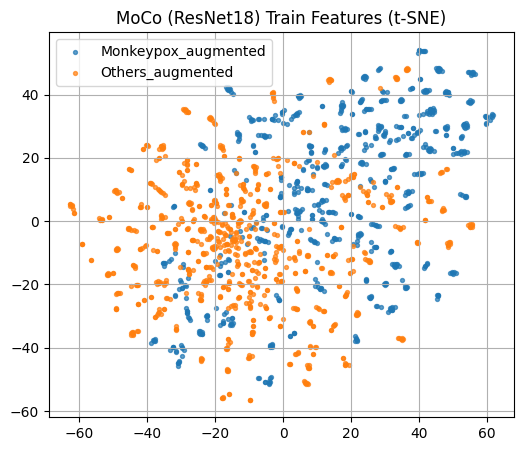

In [10]:
# Cell 10: Build a Plain ResNet-18 Encoder for Visualization + Train Feature t-SNE

# Load encoder for visualization with Identity head (no projection)
encoder_vis = models.resnet18(weights=None)
encoder_vis.fc = nn.Identity()
state = torch.load(os.path.join(SAVE_DIR, "moco_resnet18_encoder.pth"), map_location=DEVICE)

# The saved weights include a projection head (fc) sized PROJ_DIM.
# We load them into a model with Identity fc; only matching layers will load.
missing, unexpected = encoder_vis.load_state_dict(state, strict=False)
# It's normal that 'fc.weight'/'fc.bias' are missing due to Identity.
encoder_vis = encoder_vis.to(DEVICE)
encoder_vis.eval()

vis_features, vis_labels = extract_features(vis_loader, encoder_vis)

print("Computing t-SNE on TRAIN features...")
tsne = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=SEED)
tsne_2d = tsne.fit_transform(vis_features)
plt.figure(figsize=(6,5))
for c in np.unique(vis_labels):
    idx = vis_labels == c
    plt.scatter(tsne_2d[idx,0], tsne_2d[idx,1], s=8, label=IDX_TO_CLASS[c], alpha=0.7)
plt.legend()
plt.title("MoCo (ResNet18) Train Features (t-SNE)")
plt.grid(True)
plt.show()


Computing UMAP on TRAIN features...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


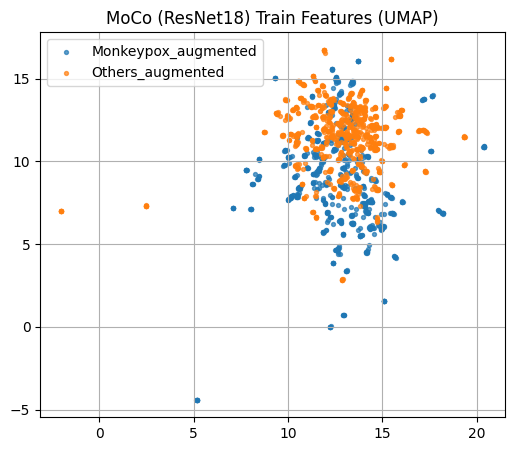

In [11]:
# Cell 11: UMAP on Train Features

print("Computing UMAP on TRAIN features...")
reducer = umap.UMAP(n_components=2, random_state=SEED)
umap_2d = reducer.fit_transform(vis_features)
plt.figure(figsize=(6,5))
for c in np.unique(vis_labels):
    idx = vis_labels == c
    plt.scatter(umap_2d[idx,0], umap_2d[idx,1], s=8, label=IDX_TO_CLASS[c], alpha=0.7)
plt.legend()
plt.title("MoCo (ResNet18) Train Features (UMAP)")
plt.grid(True)
plt.show()


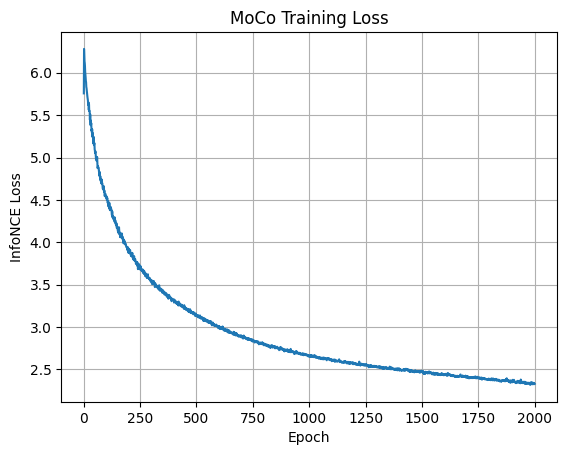

In [12]:
# Cell 12: SSL Loss Curve

plot_curve(moco_loss_history, "MoCo Training Loss", "Epoch", "InfoNCE Loss")


In [13]:
# Cell 13: Linear Evaluation (Train on 50%  Train Split)

# Freeze encoder backbone (no projection) for linear eval
encoder_linear = models.resnet18(weights=None)
encoder_linear.fc = nn.Identity()
encoder_linear.load_state_dict(torch.load(os.path.join(SAVE_DIR, "moco_resnet18_encoder.pth"),
                                          map_location=DEVICE), strict=False)
encoder_linear = encoder_linear.to(DEVICE)
for p in encoder_linear.parameters():
    p.requires_grad = False
encoder_linear.eval()

classifier = nn.Linear(FEATURE_DIM, NUM_CLASSES).to(DEVICE)
opt_lin = torch.optim.Adam(classifier.parameters(), lr=LR_LINEAR)
criterion_ce = nn.CrossEntropyLoss()

lin_train_losses, lin_val_losses = [], []   # (we don't have a separate val split here)
lin_train_accs, lin_val_accs = [], []

print("Starting linear evaluation (training on 50%  train split)...")
for epoch in range(1, EPOCHS_LINEAR + 1):
    classifier.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in tqdm(train_loader, desc=f"Linear Epoch {epoch}/{EPOCHS_LINEAR}"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        with torch.no_grad():
            feats = encoder_linear(imgs)
        logits = classifier(feats)
        loss = criterion_ce(logits, labels)

        opt_lin.zero_grad()
        loss.backward()
        opt_lin.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    lin_train_losses.append(train_loss)
    lin_train_accs.append(train_acc)

    print(f"Linear Epoch {epoch}: TrainLoss={train_loss:.4f} Acc={train_acc:.3f}")


Starting linear evaluation (training on 50%  train split)...


Linear Epoch 1/2000: 100%|██████████| 25/25 [00:02<00:00,  9.59it/s]


Linear Epoch 1: TrainLoss=0.6800 Acc=0.599


Linear Epoch 2/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 2: TrainLoss=0.6352 Acc=0.674


Linear Epoch 3/2000: 100%|██████████| 25/25 [00:02<00:00,  9.75it/s]


Linear Epoch 3: TrainLoss=0.6058 Acc=0.738


Linear Epoch 4/2000: 100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


Linear Epoch 4: TrainLoss=0.5846 Acc=0.768


Linear Epoch 5/2000: 100%|██████████| 25/25 [00:02<00:00,  9.86it/s]


Linear Epoch 5: TrainLoss=0.5665 Acc=0.779


Linear Epoch 6/2000: 100%|██████████| 25/25 [00:02<00:00,  9.67it/s]


Linear Epoch 6: TrainLoss=0.5513 Acc=0.789


Linear Epoch 7/2000: 100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Linear Epoch 7: TrainLoss=0.5376 Acc=0.803


Linear Epoch 8/2000: 100%|██████████| 25/25 [00:02<00:00,  9.52it/s]


Linear Epoch 8: TrainLoss=0.5252 Acc=0.817


Linear Epoch 9/2000: 100%|██████████| 25/25 [00:02<00:00,  9.88it/s]


Linear Epoch 9: TrainLoss=0.5140 Acc=0.822


Linear Epoch 10/2000: 100%|██████████| 25/25 [00:02<00:00,  9.73it/s]


Linear Epoch 10: TrainLoss=0.5037 Acc=0.825


Linear Epoch 11/2000: 100%|██████████| 25/25 [00:02<00:00,  9.84it/s]


Linear Epoch 11: TrainLoss=0.4941 Acc=0.828


Linear Epoch 12/2000: 100%|██████████| 25/25 [00:02<00:00,  9.38it/s]


Linear Epoch 12: TrainLoss=0.4850 Acc=0.830


Linear Epoch 13/2000: 100%|██████████| 25/25 [00:02<00:00,  9.02it/s]


Linear Epoch 13: TrainLoss=0.4767 Acc=0.833


Linear Epoch 14/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 14: TrainLoss=0.4688 Acc=0.835


Linear Epoch 15/2000: 100%|██████████| 25/25 [00:02<00:00,  9.67it/s]


Linear Epoch 15: TrainLoss=0.4616 Acc=0.838


Linear Epoch 16/2000: 100%|██████████| 25/25 [00:02<00:00,  9.51it/s]


Linear Epoch 16: TrainLoss=0.4543 Acc=0.840


Linear Epoch 17/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 17: TrainLoss=0.4478 Acc=0.841


Linear Epoch 18/2000: 100%|██████████| 25/25 [00:02<00:00,  9.83it/s]


Linear Epoch 18: TrainLoss=0.4415 Acc=0.842


Linear Epoch 19/2000: 100%|██████████| 25/25 [00:02<00:00,  9.61it/s]


Linear Epoch 19: TrainLoss=0.4352 Acc=0.843


Linear Epoch 20/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 20: TrainLoss=0.4296 Acc=0.843


Linear Epoch 21/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 21: TrainLoss=0.4240 Acc=0.845


Linear Epoch 22/2000: 100%|██████████| 25/25 [00:02<00:00,  9.81it/s]


Linear Epoch 22: TrainLoss=0.4187 Acc=0.848


Linear Epoch 23/2000: 100%|██████████| 25/25 [00:02<00:00,  9.72it/s]


Linear Epoch 23: TrainLoss=0.4136 Acc=0.850


Linear Epoch 24/2000: 100%|██████████| 25/25 [00:02<00:00,  9.83it/s]


Linear Epoch 24: TrainLoss=0.4089 Acc=0.853


Linear Epoch 25/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 25: TrainLoss=0.4041 Acc=0.855


Linear Epoch 26/2000: 100%|██████████| 25/25 [00:02<00:00,  9.15it/s]


Linear Epoch 26: TrainLoss=0.3996 Acc=0.857


Linear Epoch 27/2000: 100%|██████████| 25/25 [00:02<00:00,  9.29it/s]


Linear Epoch 27: TrainLoss=0.3951 Acc=0.857


Linear Epoch 28/2000: 100%|██████████| 25/25 [00:02<00:00,  9.56it/s]


Linear Epoch 28: TrainLoss=0.3910 Acc=0.857


Linear Epoch 29/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 29: TrainLoss=0.3867 Acc=0.861


Linear Epoch 30/2000: 100%|██████████| 25/25 [00:02<00:00,  9.66it/s]


Linear Epoch 30: TrainLoss=0.3827 Acc=0.863


Linear Epoch 31/2000: 100%|██████████| 25/25 [00:02<00:00,  9.91it/s]


Linear Epoch 31: TrainLoss=0.3788 Acc=0.861


Linear Epoch 32/2000: 100%|██████████| 25/25 [00:02<00:00, 10.42it/s]


Linear Epoch 32: TrainLoss=0.3751 Acc=0.865


Linear Epoch 33/2000: 100%|██████████| 25/25 [00:02<00:00,  9.96it/s]


Linear Epoch 33: TrainLoss=0.3713 Acc=0.867


Linear Epoch 34/2000: 100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


Linear Epoch 34: TrainLoss=0.3678 Acc=0.870


Linear Epoch 35/2000: 100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Linear Epoch 35: TrainLoss=0.3643 Acc=0.868


Linear Epoch 36/2000: 100%|██████████| 25/25 [00:02<00:00,  9.84it/s]


Linear Epoch 36: TrainLoss=0.3609 Acc=0.872


Linear Epoch 37/2000: 100%|██████████| 25/25 [00:02<00:00, 10.31it/s]


Linear Epoch 37: TrainLoss=0.3577 Acc=0.873


Linear Epoch 38/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 38: TrainLoss=0.3544 Acc=0.875


Linear Epoch 39/2000: 100%|██████████| 25/25 [00:02<00:00,  9.37it/s]


Linear Epoch 39: TrainLoss=0.3512 Acc=0.876


Linear Epoch 40/2000: 100%|██████████| 25/25 [00:02<00:00,  9.28it/s]


Linear Epoch 40: TrainLoss=0.3481 Acc=0.879


Linear Epoch 41/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 41: TrainLoss=0.3451 Acc=0.882


Linear Epoch 42/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 42: TrainLoss=0.3421 Acc=0.885


Linear Epoch 43/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 43: TrainLoss=0.3393 Acc=0.887


Linear Epoch 44/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 44: TrainLoss=0.3364 Acc=0.889


Linear Epoch 45/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 45: TrainLoss=0.3336 Acc=0.893


Linear Epoch 46/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 46: TrainLoss=0.3309 Acc=0.893


Linear Epoch 47/2000: 100%|██████████| 25/25 [00:02<00:00,  9.72it/s]


Linear Epoch 47: TrainLoss=0.3282 Acc=0.893


Linear Epoch 48/2000: 100%|██████████| 25/25 [00:02<00:00,  9.96it/s]


Linear Epoch 48: TrainLoss=0.3256 Acc=0.894


Linear Epoch 49/2000: 100%|██████████| 25/25 [00:02<00:00,  9.96it/s]


Linear Epoch 49: TrainLoss=0.3231 Acc=0.896


Linear Epoch 50/2000: 100%|██████████| 25/25 [00:02<00:00,  9.98it/s]


Linear Epoch 50: TrainLoss=0.3207 Acc=0.897


Linear Epoch 51/2000: 100%|██████████| 25/25 [00:02<00:00,  9.67it/s]


Linear Epoch 51: TrainLoss=0.3180 Acc=0.898


Linear Epoch 52/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 52: TrainLoss=0.3157 Acc=0.897


Linear Epoch 53/2000: 100%|██████████| 25/25 [00:02<00:00,  9.29it/s]


Linear Epoch 53: TrainLoss=0.3133 Acc=0.897


Linear Epoch 54/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 54: TrainLoss=0.3110 Acc=0.898


Linear Epoch 55/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 55: TrainLoss=0.3087 Acc=0.900


Linear Epoch 56/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 56: TrainLoss=0.3063 Acc=0.900


Linear Epoch 57/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 57: TrainLoss=0.3040 Acc=0.900


Linear Epoch 58/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 58: TrainLoss=0.3019 Acc=0.900


Linear Epoch 59/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 59: TrainLoss=0.2999 Acc=0.902


Linear Epoch 60/2000: 100%|██████████| 25/25 [00:02<00:00, 10.35it/s]


Linear Epoch 60: TrainLoss=0.2976 Acc=0.904


Linear Epoch 61/2000: 100%|██████████| 25/25 [00:02<00:00, 10.42it/s]


Linear Epoch 61: TrainLoss=0.2954 Acc=0.904


Linear Epoch 62/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 62: TrainLoss=0.2935 Acc=0.905


Linear Epoch 63/2000: 100%|██████████| 25/25 [00:02<00:00,  9.89it/s]


Linear Epoch 63: TrainLoss=0.2914 Acc=0.904


Linear Epoch 64/2000: 100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


Linear Epoch 64: TrainLoss=0.2893 Acc=0.905


Linear Epoch 65/2000: 100%|██████████| 25/25 [00:02<00:00, 10.43it/s]


Linear Epoch 65: TrainLoss=0.2874 Acc=0.906


Linear Epoch 66/2000: 100%|██████████| 25/25 [00:02<00:00,  9.76it/s]


Linear Epoch 66: TrainLoss=0.2855 Acc=0.907


Linear Epoch 67/2000: 100%|██████████| 25/25 [00:02<00:00,  9.31it/s]


Linear Epoch 67: TrainLoss=0.2835 Acc=0.907


Linear Epoch 68/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 68: TrainLoss=0.2816 Acc=0.907


Linear Epoch 69/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 69: TrainLoss=0.2797 Acc=0.909


Linear Epoch 70/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 70: TrainLoss=0.2780 Acc=0.912


Linear Epoch 71/2000: 100%|██████████| 25/25 [00:02<00:00,  9.91it/s]


Linear Epoch 71: TrainLoss=0.2762 Acc=0.912


Linear Epoch 72/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 72: TrainLoss=0.2742 Acc=0.914


Linear Epoch 73/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 73: TrainLoss=0.2727 Acc=0.913


Linear Epoch 74/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 74: TrainLoss=0.2708 Acc=0.915


Linear Epoch 75/2000: 100%|██████████| 25/25 [00:02<00:00,  9.64it/s]


Linear Epoch 75: TrainLoss=0.2690 Acc=0.916


Linear Epoch 76/2000: 100%|██████████| 25/25 [00:02<00:00, 10.13it/s]


Linear Epoch 76: TrainLoss=0.2673 Acc=0.918


Linear Epoch 77/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 77: TrainLoss=0.2656 Acc=0.918


Linear Epoch 78/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 78: TrainLoss=0.2640 Acc=0.919


Linear Epoch 79/2000: 100%|██████████| 25/25 [00:02<00:00, 10.27it/s]


Linear Epoch 79: TrainLoss=0.2624 Acc=0.919


Linear Epoch 80/2000: 100%|██████████| 25/25 [00:02<00:00,  9.68it/s]


Linear Epoch 80: TrainLoss=0.2606 Acc=0.919


Linear Epoch 81/2000: 100%|██████████| 25/25 [00:02<00:00,  9.59it/s]


Linear Epoch 81: TrainLoss=0.2591 Acc=0.918


Linear Epoch 82/2000: 100%|██████████| 25/25 [00:02<00:00, 10.49it/s]


Linear Epoch 82: TrainLoss=0.2574 Acc=0.920


Linear Epoch 83/2000: 100%|██████████| 25/25 [00:02<00:00, 10.33it/s]


Linear Epoch 83: TrainLoss=0.2559 Acc=0.921


Linear Epoch 84/2000: 100%|██████████| 25/25 [00:02<00:00, 10.42it/s]


Linear Epoch 84: TrainLoss=0.2543 Acc=0.923


Linear Epoch 85/2000: 100%|██████████| 25/25 [00:02<00:00, 10.27it/s]


Linear Epoch 85: TrainLoss=0.2528 Acc=0.922


Linear Epoch 86/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 86: TrainLoss=0.2512 Acc=0.924


Linear Epoch 87/2000: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Linear Epoch 87: TrainLoss=0.2497 Acc=0.925


Linear Epoch 88/2000: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Linear Epoch 88: TrainLoss=0.2482 Acc=0.925


Linear Epoch 89/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 89: TrainLoss=0.2468 Acc=0.925


Linear Epoch 90/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 90: TrainLoss=0.2453 Acc=0.926


Linear Epoch 91/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 91: TrainLoss=0.2440 Acc=0.927


Linear Epoch 92/2000: 100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


Linear Epoch 92: TrainLoss=0.2423 Acc=0.927


Linear Epoch 93/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 93: TrainLoss=0.2410 Acc=0.927


Linear Epoch 94/2000: 100%|██████████| 25/25 [00:02<00:00,  9.30it/s]


Linear Epoch 94: TrainLoss=0.2396 Acc=0.927


Linear Epoch 95/2000: 100%|██████████| 25/25 [00:02<00:00,  9.49it/s]


Linear Epoch 95: TrainLoss=0.2383 Acc=0.927


Linear Epoch 96/2000: 100%|██████████| 25/25 [00:02<00:00,  9.73it/s]


Linear Epoch 96: TrainLoss=0.2368 Acc=0.927


Linear Epoch 97/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 97: TrainLoss=0.2354 Acc=0.929


Linear Epoch 98/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 98: TrainLoss=0.2341 Acc=0.930


Linear Epoch 99/2000: 100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Linear Epoch 99: TrainLoss=0.2328 Acc=0.931


Linear Epoch 100/2000: 100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Linear Epoch 100: TrainLoss=0.2316 Acc=0.932


Linear Epoch 101/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 101: TrainLoss=0.2302 Acc=0.932


Linear Epoch 102/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 102: TrainLoss=0.2290 Acc=0.932


Linear Epoch 103/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 103: TrainLoss=0.2277 Acc=0.934


Linear Epoch 104/2000: 100%|██████████| 25/25 [00:02<00:00, 10.35it/s]


Linear Epoch 104: TrainLoss=0.2265 Acc=0.935


Linear Epoch 105/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 105: TrainLoss=0.2251 Acc=0.937


Linear Epoch 106/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 106: TrainLoss=0.2239 Acc=0.937


Linear Epoch 107/2000: 100%|██████████| 25/25 [00:02<00:00,  9.80it/s]


Linear Epoch 107: TrainLoss=0.2227 Acc=0.937


Linear Epoch 108/2000: 100%|██████████| 25/25 [00:02<00:00,  9.23it/s]


Linear Epoch 108: TrainLoss=0.2215 Acc=0.938


Linear Epoch 109/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 109: TrainLoss=0.2204 Acc=0.937


Linear Epoch 110/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 110: TrainLoss=0.2194 Acc=0.939


Linear Epoch 111/2000: 100%|██████████| 25/25 [00:02<00:00,  9.67it/s]


Linear Epoch 111: TrainLoss=0.2180 Acc=0.940


Linear Epoch 112/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 112: TrainLoss=0.2168 Acc=0.940


Linear Epoch 113/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 113: TrainLoss=0.2157 Acc=0.940


Linear Epoch 114/2000: 100%|██████████| 25/25 [00:02<00:00,  9.96it/s]


Linear Epoch 114: TrainLoss=0.2145 Acc=0.940


Linear Epoch 115/2000: 100%|██████████| 25/25 [00:02<00:00,  9.98it/s]


Linear Epoch 115: TrainLoss=0.2134 Acc=0.940


Linear Epoch 116/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 116: TrainLoss=0.2123 Acc=0.940


Linear Epoch 117/2000: 100%|██████████| 25/25 [00:02<00:00,  9.74it/s]


Linear Epoch 117: TrainLoss=0.2111 Acc=0.940


Linear Epoch 118/2000: 100%|██████████| 25/25 [00:02<00:00,  9.73it/s]


Linear Epoch 118: TrainLoss=0.2101 Acc=0.941


Linear Epoch 119/2000: 100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Linear Epoch 119: TrainLoss=0.2090 Acc=0.942


Linear Epoch 120/2000: 100%|██████████| 25/25 [00:02<00:00,  9.68it/s]


Linear Epoch 120: TrainLoss=0.2079 Acc=0.942


Linear Epoch 121/2000: 100%|██████████| 25/25 [00:02<00:00,  8.57it/s]


Linear Epoch 121: TrainLoss=0.2068 Acc=0.943


Linear Epoch 122/2000: 100%|██████████| 25/25 [00:02<00:00,  9.59it/s]


Linear Epoch 122: TrainLoss=0.2058 Acc=0.944


Linear Epoch 123/2000: 100%|██████████| 25/25 [00:02<00:00,  9.50it/s]


Linear Epoch 123: TrainLoss=0.2047 Acc=0.944


Linear Epoch 124/2000: 100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Linear Epoch 124: TrainLoss=0.2036 Acc=0.944


Linear Epoch 125/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 125: TrainLoss=0.2027 Acc=0.944


Linear Epoch 126/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 126: TrainLoss=0.2017 Acc=0.945


Linear Epoch 127/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 127: TrainLoss=0.2007 Acc=0.945


Linear Epoch 128/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 128: TrainLoss=0.1996 Acc=0.946


Linear Epoch 129/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 129: TrainLoss=0.1986 Acc=0.946


Linear Epoch 130/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 130: TrainLoss=0.1977 Acc=0.946


Linear Epoch 131/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 131: TrainLoss=0.1966 Acc=0.947


Linear Epoch 132/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 132: TrainLoss=0.1957 Acc=0.947


Linear Epoch 133/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 133: TrainLoss=0.1947 Acc=0.947


Linear Epoch 134/2000: 100%|██████████| 25/25 [00:02<00:00,  9.11it/s]


Linear Epoch 134: TrainLoss=0.1938 Acc=0.948


Linear Epoch 135/2000: 100%|██████████| 25/25 [00:02<00:00,  9.26it/s]


Linear Epoch 135: TrainLoss=0.1929 Acc=0.948


Linear Epoch 136/2000: 100%|██████████| 25/25 [00:02<00:00,  9.67it/s]


Linear Epoch 136: TrainLoss=0.1919 Acc=0.951


Linear Epoch 137/2000: 100%|██████████| 25/25 [00:02<00:00,  9.69it/s]


Linear Epoch 137: TrainLoss=0.1910 Acc=0.951


Linear Epoch 138/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 138: TrainLoss=0.1901 Acc=0.951


Linear Epoch 139/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 139: TrainLoss=0.1892 Acc=0.951


Linear Epoch 140/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 140: TrainLoss=0.1882 Acc=0.951


Linear Epoch 141/2000: 100%|██████████| 25/25 [00:02<00:00,  9.86it/s]


Linear Epoch 141: TrainLoss=0.1874 Acc=0.951


Linear Epoch 142/2000: 100%|██████████| 25/25 [00:02<00:00,  9.39it/s]


Linear Epoch 142: TrainLoss=0.1865 Acc=0.951


Linear Epoch 143/2000: 100%|██████████| 25/25 [00:02<00:00,  9.23it/s]


Linear Epoch 143: TrainLoss=0.1856 Acc=0.952


Linear Epoch 144/2000: 100%|██████████| 25/25 [00:02<00:00,  9.48it/s]


Linear Epoch 144: TrainLoss=0.1848 Acc=0.952


Linear Epoch 145/2000: 100%|██████████| 25/25 [00:02<00:00,  9.75it/s]


Linear Epoch 145: TrainLoss=0.1838 Acc=0.953


Linear Epoch 146/2000: 100%|██████████| 25/25 [00:02<00:00,  8.51it/s]


Linear Epoch 146: TrainLoss=0.1831 Acc=0.953


Linear Epoch 147/2000: 100%|██████████| 25/25 [00:03<00:00,  7.73it/s]


Linear Epoch 147: TrainLoss=0.1822 Acc=0.953


Linear Epoch 148/2000: 100%|██████████| 25/25 [00:02<00:00,  9.20it/s]


Linear Epoch 148: TrainLoss=0.1814 Acc=0.954


Linear Epoch 149/2000: 100%|██████████| 25/25 [00:02<00:00,  9.83it/s]


Linear Epoch 149: TrainLoss=0.1805 Acc=0.954


Linear Epoch 150/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 150: TrainLoss=0.1797 Acc=0.954


Linear Epoch 151/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 151: TrainLoss=0.1789 Acc=0.954


Linear Epoch 152/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 152: TrainLoss=0.1780 Acc=0.954


Linear Epoch 153/2000: 100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


Linear Epoch 153: TrainLoss=0.1772 Acc=0.955


Linear Epoch 154/2000: 100%|██████████| 25/25 [00:02<00:00,  9.61it/s]


Linear Epoch 154: TrainLoss=0.1764 Acc=0.956


Linear Epoch 155/2000: 100%|██████████| 25/25 [00:02<00:00,  9.57it/s]


Linear Epoch 155: TrainLoss=0.1757 Acc=0.956


Linear Epoch 156/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 156: TrainLoss=0.1748 Acc=0.956


Linear Epoch 157/2000: 100%|██████████| 25/25 [00:02<00:00,  9.81it/s]


Linear Epoch 157: TrainLoss=0.1740 Acc=0.956


Linear Epoch 158/2000: 100%|██████████| 25/25 [00:02<00:00,  9.98it/s]


Linear Epoch 158: TrainLoss=0.1733 Acc=0.956


Linear Epoch 159/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 159: TrainLoss=0.1725 Acc=0.956


Linear Epoch 160/2000: 100%|██████████| 25/25 [00:02<00:00,  9.05it/s]


Linear Epoch 160: TrainLoss=0.1717 Acc=0.956


Linear Epoch 161/2000: 100%|██████████| 25/25 [00:02<00:00,  8.96it/s]


Linear Epoch 161: TrainLoss=0.1710 Acc=0.957


Linear Epoch 162/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 162: TrainLoss=0.1702 Acc=0.957


Linear Epoch 163/2000: 100%|██████████| 25/25 [00:02<00:00,  9.90it/s]


Linear Epoch 163: TrainLoss=0.1695 Acc=0.957


Linear Epoch 164/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 164: TrainLoss=0.1687 Acc=0.957


Linear Epoch 165/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 165: TrainLoss=0.1683 Acc=0.958


Linear Epoch 166/2000: 100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


Linear Epoch 166: TrainLoss=0.1673 Acc=0.959


Linear Epoch 167/2000: 100%|██████████| 25/25 [00:02<00:00,  9.25it/s]


Linear Epoch 167: TrainLoss=0.1665 Acc=0.959


Linear Epoch 168/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 168: TrainLoss=0.1658 Acc=0.959


Linear Epoch 169/2000: 100%|██████████| 25/25 [00:02<00:00,  9.48it/s]


Linear Epoch 169: TrainLoss=0.1652 Acc=0.960


Linear Epoch 170/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 170: TrainLoss=0.1644 Acc=0.959


Linear Epoch 171/2000: 100%|██████████| 25/25 [00:02<00:00,  9.86it/s]


Linear Epoch 171: TrainLoss=0.1637 Acc=0.959


Linear Epoch 172/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 172: TrainLoss=0.1630 Acc=0.959


Linear Epoch 173/2000: 100%|██████████| 25/25 [00:02<00:00,  8.94it/s]


Linear Epoch 173: TrainLoss=0.1622 Acc=0.960


Linear Epoch 174/2000: 100%|██████████| 25/25 [00:02<00:00,  9.49it/s]


Linear Epoch 174: TrainLoss=0.1617 Acc=0.959


Linear Epoch 175/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 175: TrainLoss=0.1610 Acc=0.960


Linear Epoch 176/2000: 100%|██████████| 25/25 [00:02<00:00,  9.96it/s]


Linear Epoch 176: TrainLoss=0.1603 Acc=0.961


Linear Epoch 177/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 177: TrainLoss=0.1596 Acc=0.961


Linear Epoch 178/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 178: TrainLoss=0.1589 Acc=0.961


Linear Epoch 179/2000: 100%|██████████| 25/25 [00:02<00:00,  9.44it/s]


Linear Epoch 179: TrainLoss=0.1582 Acc=0.961


Linear Epoch 180/2000: 100%|██████████| 25/25 [00:02<00:00,  9.39it/s]


Linear Epoch 180: TrainLoss=0.1576 Acc=0.961


Linear Epoch 181/2000: 100%|██████████| 25/25 [00:02<00:00,  9.83it/s]


Linear Epoch 181: TrainLoss=0.1570 Acc=0.961


Linear Epoch 182/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 182: TrainLoss=0.1563 Acc=0.961


Linear Epoch 183/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 183: TrainLoss=0.1557 Acc=0.962


Linear Epoch 184/2000: 100%|██████████| 25/25 [00:02<00:00,  9.84it/s]


Linear Epoch 184: TrainLoss=0.1550 Acc=0.962


Linear Epoch 185/2000: 100%|██████████| 25/25 [00:02<00:00,  9.66it/s]


Linear Epoch 185: TrainLoss=0.1544 Acc=0.962


Linear Epoch 186/2000: 100%|██████████| 25/25 [00:02<00:00,  9.35it/s]


Linear Epoch 186: TrainLoss=0.1537 Acc=0.962


Linear Epoch 187/2000: 100%|██████████| 25/25 [00:02<00:00,  9.32it/s]


Linear Epoch 187: TrainLoss=0.1531 Acc=0.962


Linear Epoch 188/2000: 100%|██████████| 25/25 [00:02<00:00,  9.69it/s]


Linear Epoch 188: TrainLoss=0.1525 Acc=0.962


Linear Epoch 189/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 189: TrainLoss=0.1519 Acc=0.962


Linear Epoch 190/2000: 100%|██████████| 25/25 [00:02<00:00,  9.63it/s]


Linear Epoch 190: TrainLoss=0.1513 Acc=0.962


Linear Epoch 191/2000: 100%|██████████| 25/25 [00:02<00:00,  9.44it/s]


Linear Epoch 191: TrainLoss=0.1506 Acc=0.962


Linear Epoch 192/2000: 100%|██████████| 25/25 [00:02<00:00,  9.28it/s]


Linear Epoch 192: TrainLoss=0.1501 Acc=0.962


Linear Epoch 193/2000: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Linear Epoch 193: TrainLoss=0.1495 Acc=0.962


Linear Epoch 194/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 194: TrainLoss=0.1489 Acc=0.962


Linear Epoch 195/2000: 100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Linear Epoch 195: TrainLoss=0.1484 Acc=0.962


Linear Epoch 196/2000: 100%|██████████| 25/25 [00:02<00:00,  9.81it/s]


Linear Epoch 196: TrainLoss=0.1477 Acc=0.963


Linear Epoch 197/2000: 100%|██████████| 25/25 [00:02<00:00,  9.88it/s]


Linear Epoch 197: TrainLoss=0.1471 Acc=0.962


Linear Epoch 198/2000: 100%|██████████| 25/25 [00:02<00:00,  9.64it/s]


Linear Epoch 198: TrainLoss=0.1465 Acc=0.963


Linear Epoch 199/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 199: TrainLoss=0.1460 Acc=0.964


Linear Epoch 200/2000: 100%|██████████| 25/25 [00:02<00:00,  9.19it/s]


Linear Epoch 200: TrainLoss=0.1455 Acc=0.963


Linear Epoch 201/2000: 100%|██████████| 25/25 [00:02<00:00,  9.55it/s]


Linear Epoch 201: TrainLoss=0.1448 Acc=0.964


Linear Epoch 202/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 202: TrainLoss=0.1443 Acc=0.964


Linear Epoch 203/2000: 100%|██████████| 25/25 [00:02<00:00,  9.79it/s]


Linear Epoch 203: TrainLoss=0.1437 Acc=0.964


Linear Epoch 204/2000: 100%|██████████| 25/25 [00:02<00:00,  9.54it/s]


Linear Epoch 204: TrainLoss=0.1432 Acc=0.964


Linear Epoch 205/2000: 100%|██████████| 25/25 [00:02<00:00,  9.90it/s]


Linear Epoch 205: TrainLoss=0.1426 Acc=0.964


Linear Epoch 206/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 206: TrainLoss=0.1420 Acc=0.964


Linear Epoch 207/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 207: TrainLoss=0.1415 Acc=0.964


Linear Epoch 208/2000: 100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Linear Epoch 208: TrainLoss=0.1410 Acc=0.964


Linear Epoch 209/2000: 100%|██████████| 25/25 [00:02<00:00,  9.78it/s]


Linear Epoch 209: TrainLoss=0.1404 Acc=0.964


Linear Epoch 210/2000: 100%|██████████| 25/25 [00:02<00:00,  9.52it/s]


Linear Epoch 210: TrainLoss=0.1398 Acc=0.964


Linear Epoch 211/2000: 100%|██████████| 25/25 [00:02<00:00,  9.87it/s]


Linear Epoch 211: TrainLoss=0.1393 Acc=0.965


Linear Epoch 212/2000: 100%|██████████| 25/25 [00:02<00:00,  9.56it/s]


Linear Epoch 212: TrainLoss=0.1388 Acc=0.966


Linear Epoch 213/2000: 100%|██████████| 25/25 [00:02<00:00,  8.96it/s]


Linear Epoch 213: TrainLoss=0.1383 Acc=0.966


Linear Epoch 214/2000: 100%|██████████| 25/25 [00:02<00:00,  9.32it/s]


Linear Epoch 214: TrainLoss=0.1378 Acc=0.966


Linear Epoch 215/2000: 100%|██████████| 25/25 [00:02<00:00,  9.33it/s]


Linear Epoch 215: TrainLoss=0.1372 Acc=0.966


Linear Epoch 216/2000: 100%|██████████| 25/25 [00:02<00:00,  9.83it/s]


Linear Epoch 216: TrainLoss=0.1367 Acc=0.967


Linear Epoch 217/2000: 100%|██████████| 25/25 [00:02<00:00, 10.27it/s]


Linear Epoch 217: TrainLoss=0.1362 Acc=0.967


Linear Epoch 218/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 218: TrainLoss=0.1357 Acc=0.967


Linear Epoch 219/2000: 100%|██████████| 25/25 [00:02<00:00,  9.55it/s]


Linear Epoch 219: TrainLoss=0.1352 Acc=0.967


Linear Epoch 220/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 220: TrainLoss=0.1347 Acc=0.967


Linear Epoch 221/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 221: TrainLoss=0.1342 Acc=0.967


Linear Epoch 222/2000: 100%|██████████| 25/25 [00:02<00:00,  9.81it/s]


Linear Epoch 222: TrainLoss=0.1337 Acc=0.967


Linear Epoch 223/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 223: TrainLoss=0.1332 Acc=0.967


Linear Epoch 224/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 224: TrainLoss=0.1327 Acc=0.967


Linear Epoch 225/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 225: TrainLoss=0.1322 Acc=0.968


Linear Epoch 226/2000: 100%|██████████| 25/25 [00:02<00:00,  9.75it/s]


Linear Epoch 226: TrainLoss=0.1318 Acc=0.968


Linear Epoch 227/2000: 100%|██████████| 25/25 [00:02<00:00,  8.93it/s]


Linear Epoch 227: TrainLoss=0.1313 Acc=0.968


Linear Epoch 228/2000: 100%|██████████| 25/25 [00:02<00:00,  9.26it/s]


Linear Epoch 228: TrainLoss=0.1308 Acc=0.968


Linear Epoch 229/2000: 100%|██████████| 25/25 [00:02<00:00, 10.35it/s]


Linear Epoch 229: TrainLoss=0.1304 Acc=0.967


Linear Epoch 230/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 230: TrainLoss=0.1300 Acc=0.969


Linear Epoch 231/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 231: TrainLoss=0.1294 Acc=0.968


Linear Epoch 232/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 232: TrainLoss=0.1290 Acc=0.969


Linear Epoch 233/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 233: TrainLoss=0.1285 Acc=0.969


Linear Epoch 234/2000: 100%|██████████| 25/25 [00:02<00:00,  9.73it/s]


Linear Epoch 234: TrainLoss=0.1281 Acc=0.969


Linear Epoch 235/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 235: TrainLoss=0.1276 Acc=0.970


Linear Epoch 236/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 236: TrainLoss=0.1272 Acc=0.969


Linear Epoch 237/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 237: TrainLoss=0.1267 Acc=0.971


Linear Epoch 238/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 238: TrainLoss=0.1262 Acc=0.970


Linear Epoch 239/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 239: TrainLoss=0.1258 Acc=0.971


Linear Epoch 240/2000: 100%|██████████| 25/25 [00:02<00:00,  9.16it/s]


Linear Epoch 240: TrainLoss=0.1253 Acc=0.971


Linear Epoch 241/2000: 100%|██████████| 25/25 [00:02<00:00,  9.45it/s]


Linear Epoch 241: TrainLoss=0.1249 Acc=0.972


Linear Epoch 242/2000: 100%|██████████| 25/25 [00:02<00:00, 10.34it/s]


Linear Epoch 242: TrainLoss=0.1245 Acc=0.971


Linear Epoch 243/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 243: TrainLoss=0.1240 Acc=0.972


Linear Epoch 244/2000: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Linear Epoch 244: TrainLoss=0.1236 Acc=0.972


Linear Epoch 245/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 245: TrainLoss=0.1232 Acc=0.972


Linear Epoch 246/2000: 100%|██████████| 25/25 [00:02<00:00,  9.66it/s]


Linear Epoch 246: TrainLoss=0.1228 Acc=0.972


Linear Epoch 247/2000: 100%|██████████| 25/25 [00:02<00:00,  9.44it/s]


Linear Epoch 247: TrainLoss=0.1223 Acc=0.974


Linear Epoch 248/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 248: TrainLoss=0.1219 Acc=0.974


Linear Epoch 249/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 249: TrainLoss=0.1215 Acc=0.974


Linear Epoch 250/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 250: TrainLoss=0.1211 Acc=0.973


Linear Epoch 251/2000: 100%|██████████| 25/25 [00:02<00:00,  9.87it/s]


Linear Epoch 251: TrainLoss=0.1207 Acc=0.974


Linear Epoch 252/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 252: TrainLoss=0.1203 Acc=0.974


Linear Epoch 253/2000: 100%|██████████| 25/25 [00:02<00:00,  9.39it/s]


Linear Epoch 253: TrainLoss=0.1198 Acc=0.974


Linear Epoch 254/2000: 100%|██████████| 25/25 [00:02<00:00,  9.22it/s]


Linear Epoch 254: TrainLoss=0.1194 Acc=0.974


Linear Epoch 255/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 255: TrainLoss=0.1190 Acc=0.974


Linear Epoch 256/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 256: TrainLoss=0.1187 Acc=0.974


Linear Epoch 257/2000: 100%|██████████| 25/25 [00:02<00:00, 10.27it/s]


Linear Epoch 257: TrainLoss=0.1183 Acc=0.974


Linear Epoch 258/2000: 100%|██████████| 25/25 [00:02<00:00,  9.64it/s]


Linear Epoch 258: TrainLoss=0.1179 Acc=0.974


Linear Epoch 259/2000: 100%|██████████| 25/25 [00:02<00:00,  9.55it/s]


Linear Epoch 259: TrainLoss=0.1175 Acc=0.974


Linear Epoch 260/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 260: TrainLoss=0.1171 Acc=0.974


Linear Epoch 261/2000: 100%|██████████| 25/25 [00:02<00:00,  9.82it/s]


Linear Epoch 261: TrainLoss=0.1167 Acc=0.974


Linear Epoch 262/2000: 100%|██████████| 25/25 [00:02<00:00,  9.74it/s]


Linear Epoch 262: TrainLoss=0.1163 Acc=0.974


Linear Epoch 263/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 263: TrainLoss=0.1159 Acc=0.974


Linear Epoch 264/2000: 100%|██████████| 25/25 [00:02<00:00,  9.80it/s]


Linear Epoch 264: TrainLoss=0.1155 Acc=0.974


Linear Epoch 265/2000: 100%|██████████| 25/25 [00:02<00:00,  9.67it/s]


Linear Epoch 265: TrainLoss=0.1152 Acc=0.974


Linear Epoch 266/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 266: TrainLoss=0.1148 Acc=0.974


Linear Epoch 267/2000: 100%|██████████| 25/25 [00:02<00:00,  9.61it/s]


Linear Epoch 267: TrainLoss=0.1144 Acc=0.974


Linear Epoch 268/2000: 100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


Linear Epoch 268: TrainLoss=0.1140 Acc=0.974


Linear Epoch 269/2000: 100%|██████████| 25/25 [00:02<00:00, 10.33it/s]


Linear Epoch 269: TrainLoss=0.1137 Acc=0.974


Linear Epoch 270/2000: 100%|██████████| 25/25 [00:02<00:00, 10.39it/s]


Linear Epoch 270: TrainLoss=0.1133 Acc=0.974


Linear Epoch 271/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 271: TrainLoss=0.1129 Acc=0.974


Linear Epoch 272/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 272: TrainLoss=0.1126 Acc=0.974


Linear Epoch 273/2000: 100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


Linear Epoch 273: TrainLoss=0.1122 Acc=0.974


Linear Epoch 274/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 274: TrainLoss=0.1118 Acc=0.974


Linear Epoch 275/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 275: TrainLoss=0.1114 Acc=0.974


Linear Epoch 276/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 276: TrainLoss=0.1111 Acc=0.974


Linear Epoch 277/2000: 100%|██████████| 25/25 [00:02<00:00,  9.91it/s]


Linear Epoch 277: TrainLoss=0.1108 Acc=0.974


Linear Epoch 278/2000: 100%|██████████| 25/25 [00:02<00:00,  9.58it/s]


Linear Epoch 278: TrainLoss=0.1104 Acc=0.974


Linear Epoch 279/2000: 100%|██████████| 25/25 [00:02<00:00,  9.98it/s]


Linear Epoch 279: TrainLoss=0.1101 Acc=0.974


Linear Epoch 280/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 280: TrainLoss=0.1097 Acc=0.974


Linear Epoch 281/2000: 100%|██████████| 25/25 [00:02<00:00,  9.08it/s]


Linear Epoch 281: TrainLoss=0.1094 Acc=0.974


Linear Epoch 282/2000: 100%|██████████| 25/25 [00:02<00:00,  9.79it/s]


Linear Epoch 282: TrainLoss=0.1090 Acc=0.974


Linear Epoch 283/2000: 100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


Linear Epoch 283: TrainLoss=0.1087 Acc=0.974


Linear Epoch 284/2000: 100%|██████████| 25/25 [00:02<00:00,  9.56it/s]


Linear Epoch 284: TrainLoss=0.1083 Acc=0.974


Linear Epoch 285/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 285: TrainLoss=0.1080 Acc=0.974


Linear Epoch 286/2000: 100%|██████████| 25/25 [00:02<00:00,  9.69it/s]


Linear Epoch 286: TrainLoss=0.1077 Acc=0.974


Linear Epoch 287/2000: 100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


Linear Epoch 287: TrainLoss=0.1073 Acc=0.974


Linear Epoch 288/2000: 100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Linear Epoch 288: TrainLoss=0.1070 Acc=0.974


Linear Epoch 289/2000: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Linear Epoch 289: TrainLoss=0.1066 Acc=0.974


Linear Epoch 290/2000: 100%|██████████| 25/25 [00:02<00:00,  9.81it/s]


Linear Epoch 290: TrainLoss=0.1063 Acc=0.974


Linear Epoch 291/2000: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Linear Epoch 291: TrainLoss=0.1060 Acc=0.974


Linear Epoch 292/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 292: TrainLoss=0.1057 Acc=0.975


Linear Epoch 293/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 293: TrainLoss=0.1054 Acc=0.976


Linear Epoch 294/2000: 100%|██████████| 25/25 [00:02<00:00,  9.51it/s]


Linear Epoch 294: TrainLoss=0.1051 Acc=0.975


Linear Epoch 295/2000: 100%|██████████| 25/25 [00:02<00:00,  9.27it/s]


Linear Epoch 295: TrainLoss=0.1048 Acc=0.976


Linear Epoch 296/2000: 100%|██████████| 25/25 [00:02<00:00,  9.44it/s]


Linear Epoch 296: TrainLoss=0.1044 Acc=0.976


Linear Epoch 297/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 297: TrainLoss=0.1041 Acc=0.977


Linear Epoch 298/2000: 100%|██████████| 25/25 [00:02<00:00,  9.91it/s]


Linear Epoch 298: TrainLoss=0.1038 Acc=0.976


Linear Epoch 299/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 299: TrainLoss=0.1034 Acc=0.976


Linear Epoch 300/2000: 100%|██████████| 25/25 [00:02<00:00,  9.83it/s]


Linear Epoch 300: TrainLoss=0.1031 Acc=0.976


Linear Epoch 301/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 301: TrainLoss=0.1028 Acc=0.976


Linear Epoch 302/2000: 100%|██████████| 25/25 [00:02<00:00,  9.87it/s]


Linear Epoch 302: TrainLoss=0.1025 Acc=0.976


Linear Epoch 303/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 303: TrainLoss=0.1022 Acc=0.977


Linear Epoch 304/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 304: TrainLoss=0.1019 Acc=0.977


Linear Epoch 305/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 305: TrainLoss=0.1016 Acc=0.977


Linear Epoch 306/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 306: TrainLoss=0.1013 Acc=0.977


Linear Epoch 307/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 307: TrainLoss=0.1010 Acc=0.977


Linear Epoch 308/2000: 100%|██████████| 25/25 [00:02<00:00,  9.43it/s]


Linear Epoch 308: TrainLoss=0.1007 Acc=0.977


Linear Epoch 309/2000: 100%|██████████| 25/25 [00:02<00:00,  9.29it/s]


Linear Epoch 309: TrainLoss=0.1004 Acc=0.977


Linear Epoch 310/2000: 100%|██████████| 25/25 [00:02<00:00,  9.66it/s]


Linear Epoch 310: TrainLoss=0.1001 Acc=0.977


Linear Epoch 311/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 311: TrainLoss=0.0999 Acc=0.977


Linear Epoch 312/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 312: TrainLoss=0.0995 Acc=0.977


Linear Epoch 313/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 313: TrainLoss=0.0993 Acc=0.977


Linear Epoch 314/2000: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Linear Epoch 314: TrainLoss=0.0989 Acc=0.977


Linear Epoch 315/2000: 100%|██████████| 25/25 [00:02<00:00, 10.51it/s]


Linear Epoch 315: TrainLoss=0.0986 Acc=0.977


Linear Epoch 316/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 316: TrainLoss=0.0984 Acc=0.977


Linear Epoch 317/2000: 100%|██████████| 25/25 [00:02<00:00, 10.43it/s]


Linear Epoch 317: TrainLoss=0.0981 Acc=0.977


Linear Epoch 318/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 318: TrainLoss=0.0978 Acc=0.977


Linear Epoch 319/2000: 100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


Linear Epoch 319: TrainLoss=0.0975 Acc=0.977


Linear Epoch 320/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 320: TrainLoss=0.0973 Acc=0.977


Linear Epoch 321/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 321: TrainLoss=0.0970 Acc=0.977


Linear Epoch 322/2000: 100%|██████████| 25/25 [00:02<00:00,  9.09it/s]


Linear Epoch 322: TrainLoss=0.0967 Acc=0.977


Linear Epoch 323/2000: 100%|██████████| 25/25 [00:02<00:00,  8.79it/s]


Linear Epoch 323: TrainLoss=0.0964 Acc=0.977


Linear Epoch 324/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 324: TrainLoss=0.0961 Acc=0.977


Linear Epoch 325/2000: 100%|██████████| 25/25 [00:02<00:00, 10.39it/s]


Linear Epoch 325: TrainLoss=0.0959 Acc=0.977


Linear Epoch 326/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 326: TrainLoss=0.0956 Acc=0.977


Linear Epoch 327/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 327: TrainLoss=0.0953 Acc=0.977


Linear Epoch 328/2000: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Linear Epoch 328: TrainLoss=0.0950 Acc=0.977


Linear Epoch 329/2000: 100%|██████████| 25/25 [00:02<00:00,  9.75it/s]


Linear Epoch 329: TrainLoss=0.0948 Acc=0.977


Linear Epoch 330/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 330: TrainLoss=0.0945 Acc=0.977


Linear Epoch 331/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 331: TrainLoss=0.0943 Acc=0.977


Linear Epoch 332/2000: 100%|██████████| 25/25 [00:02<00:00,  9.91it/s]


Linear Epoch 332: TrainLoss=0.0940 Acc=0.978


Linear Epoch 333/2000: 100%|██████████| 25/25 [00:02<00:00,  9.96it/s]


Linear Epoch 333: TrainLoss=0.0937 Acc=0.978


Linear Epoch 334/2000: 100%|██████████| 25/25 [00:02<00:00,  9.39it/s]


Linear Epoch 334: TrainLoss=0.0935 Acc=0.978


Linear Epoch 335/2000: 100%|██████████| 25/25 [00:02<00:00,  9.25it/s]


Linear Epoch 335: TrainLoss=0.0932 Acc=0.978


Linear Epoch 336/2000: 100%|██████████| 25/25 [00:02<00:00,  9.03it/s]


Linear Epoch 336: TrainLoss=0.0929 Acc=0.979


Linear Epoch 337/2000: 100%|██████████| 25/25 [00:02<00:00,  9.80it/s]


Linear Epoch 337: TrainLoss=0.0926 Acc=0.979


Linear Epoch 338/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 338: TrainLoss=0.0925 Acc=0.979


Linear Epoch 339/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 339: TrainLoss=0.0922 Acc=0.979


Linear Epoch 340/2000: 100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


Linear Epoch 340: TrainLoss=0.0919 Acc=0.979


Linear Epoch 341/2000: 100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


Linear Epoch 341: TrainLoss=0.0917 Acc=0.979


Linear Epoch 342/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 342: TrainLoss=0.0914 Acc=0.979


Linear Epoch 343/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 343: TrainLoss=0.0912 Acc=0.979


Linear Epoch 344/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 344: TrainLoss=0.0909 Acc=0.980


Linear Epoch 345/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 345: TrainLoss=0.0907 Acc=0.980


Linear Epoch 346/2000: 100%|██████████| 25/25 [00:02<00:00,  9.86it/s]


Linear Epoch 346: TrainLoss=0.0904 Acc=0.980


Linear Epoch 347/2000: 100%|██████████| 25/25 [00:02<00:00,  9.61it/s]


Linear Epoch 347: TrainLoss=0.0902 Acc=0.980


Linear Epoch 348/2000: 100%|██████████| 25/25 [00:02<00:00,  9.75it/s]


Linear Epoch 348: TrainLoss=0.0899 Acc=0.980


Linear Epoch 349/2000: 100%|██████████| 25/25 [00:02<00:00,  9.30it/s]


Linear Epoch 349: TrainLoss=0.0897 Acc=0.980


Linear Epoch 350/2000: 100%|██████████| 25/25 [00:02<00:00,  9.37it/s]


Linear Epoch 350: TrainLoss=0.0894 Acc=0.980


Linear Epoch 351/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 351: TrainLoss=0.0892 Acc=0.981


Linear Epoch 352/2000: 100%|██████████| 25/25 [00:02<00:00,  9.89it/s]


Linear Epoch 352: TrainLoss=0.0890 Acc=0.981


Linear Epoch 353/2000: 100%|██████████| 25/25 [00:02<00:00,  9.75it/s]


Linear Epoch 353: TrainLoss=0.0887 Acc=0.981


Linear Epoch 354/2000: 100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Linear Epoch 354: TrainLoss=0.0885 Acc=0.981


Linear Epoch 355/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 355: TrainLoss=0.0882 Acc=0.981


Linear Epoch 356/2000: 100%|██████████| 25/25 [00:02<00:00,  9.67it/s]


Linear Epoch 356: TrainLoss=0.0880 Acc=0.981


Linear Epoch 357/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 357: TrainLoss=0.0878 Acc=0.982


Linear Epoch 358/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 358: TrainLoss=0.0876 Acc=0.981


Linear Epoch 359/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 359: TrainLoss=0.0873 Acc=0.982


Linear Epoch 360/2000: 100%|██████████| 25/25 [00:02<00:00,  9.63it/s]


Linear Epoch 360: TrainLoss=0.0871 Acc=0.982


Linear Epoch 361/2000: 100%|██████████| 25/25 [00:02<00:00,  9.90it/s]


Linear Epoch 361: TrainLoss=0.0869 Acc=0.982


Linear Epoch 362/2000: 100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


Linear Epoch 362: TrainLoss=0.0867 Acc=0.982


Linear Epoch 363/2000: 100%|██████████| 25/25 [00:02<00:00,  9.23it/s]


Linear Epoch 363: TrainLoss=0.0864 Acc=0.983


Linear Epoch 364/2000: 100%|██████████| 25/25 [00:02<00:00,  9.45it/s]


Linear Epoch 364: TrainLoss=0.0862 Acc=0.982


Linear Epoch 365/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 365: TrainLoss=0.0860 Acc=0.982


Linear Epoch 366/2000: 100%|██████████| 25/25 [00:02<00:00, 10.13it/s]


Linear Epoch 366: TrainLoss=0.0857 Acc=0.983


Linear Epoch 367/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 367: TrainLoss=0.0856 Acc=0.982


Linear Epoch 368/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 368: TrainLoss=0.0853 Acc=0.982


Linear Epoch 369/2000: 100%|██████████| 25/25 [00:02<00:00,  9.84it/s]


Linear Epoch 369: TrainLoss=0.0851 Acc=0.983


Linear Epoch 370/2000: 100%|██████████| 25/25 [00:02<00:00,  9.80it/s]


Linear Epoch 370: TrainLoss=0.0849 Acc=0.984


Linear Epoch 371/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 371: TrainLoss=0.0847 Acc=0.984


Linear Epoch 372/2000: 100%|██████████| 25/25 [00:02<00:00,  9.73it/s]


Linear Epoch 372: TrainLoss=0.0844 Acc=0.983


Linear Epoch 373/2000: 100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


Linear Epoch 373: TrainLoss=0.0842 Acc=0.983


Linear Epoch 374/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 374: TrainLoss=0.0840 Acc=0.983


Linear Epoch 375/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 375: TrainLoss=0.0838 Acc=0.983


Linear Epoch 376/2000: 100%|██████████| 25/25 [00:02<00:00,  9.58it/s]


Linear Epoch 376: TrainLoss=0.0837 Acc=0.983


Linear Epoch 377/2000: 100%|██████████| 25/25 [00:02<00:00,  9.30it/s]


Linear Epoch 377: TrainLoss=0.0834 Acc=0.983


Linear Epoch 378/2000: 100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


Linear Epoch 378: TrainLoss=0.0832 Acc=0.983


Linear Epoch 379/2000: 100%|██████████| 25/25 [00:02<00:00,  9.87it/s]


Linear Epoch 379: TrainLoss=0.0829 Acc=0.983


Linear Epoch 380/2000: 100%|██████████| 25/25 [00:02<00:00,  9.71it/s]


Linear Epoch 380: TrainLoss=0.0827 Acc=0.983


Linear Epoch 381/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 381: TrainLoss=0.0825 Acc=0.983


Linear Epoch 382/2000: 100%|██████████| 25/25 [00:02<00:00, 10.44it/s]


Linear Epoch 382: TrainLoss=0.0823 Acc=0.983


Linear Epoch 383/2000: 100%|██████████| 25/25 [00:02<00:00, 10.35it/s]


Linear Epoch 383: TrainLoss=0.0821 Acc=0.984


Linear Epoch 384/2000: 100%|██████████| 25/25 [00:02<00:00, 10.67it/s]


Linear Epoch 384: TrainLoss=0.0819 Acc=0.984


Linear Epoch 385/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 385: TrainLoss=0.0817 Acc=0.984


Linear Epoch 386/2000: 100%|██████████| 25/25 [00:02<00:00, 10.32it/s]


Linear Epoch 386: TrainLoss=0.0815 Acc=0.984


Linear Epoch 387/2000: 100%|██████████| 25/25 [00:02<00:00, 10.46it/s]


Linear Epoch 387: TrainLoss=0.0813 Acc=0.984


Linear Epoch 388/2000: 100%|██████████| 25/25 [00:02<00:00, 10.49it/s]


Linear Epoch 388: TrainLoss=0.0811 Acc=0.984


Linear Epoch 389/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 389: TrainLoss=0.0809 Acc=0.984


Linear Epoch 390/2000: 100%|██████████| 25/25 [00:02<00:00,  9.83it/s]


Linear Epoch 390: TrainLoss=0.0807 Acc=0.984


Linear Epoch 391/2000: 100%|██████████| 25/25 [00:02<00:00,  9.38it/s]


Linear Epoch 391: TrainLoss=0.0805 Acc=0.984


Linear Epoch 392/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 392: TrainLoss=0.0803 Acc=0.984


Linear Epoch 393/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 393: TrainLoss=0.0801 Acc=0.984


Linear Epoch 394/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 394: TrainLoss=0.0799 Acc=0.985


Linear Epoch 395/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 395: TrainLoss=0.0797 Acc=0.984


Linear Epoch 396/2000: 100%|██████████| 25/25 [00:02<00:00, 10.47it/s]


Linear Epoch 396: TrainLoss=0.0795 Acc=0.984


Linear Epoch 397/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 397: TrainLoss=0.0793 Acc=0.984


Linear Epoch 398/2000: 100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


Linear Epoch 398: TrainLoss=0.0792 Acc=0.984


Linear Epoch 399/2000: 100%|██████████| 25/25 [00:02<00:00, 10.54it/s]


Linear Epoch 399: TrainLoss=0.0790 Acc=0.984


Linear Epoch 400/2000: 100%|██████████| 25/25 [00:02<00:00, 10.46it/s]


Linear Epoch 400: TrainLoss=0.0788 Acc=0.985


Linear Epoch 401/2000: 100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Linear Epoch 401: TrainLoss=0.0786 Acc=0.985


Linear Epoch 402/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 402: TrainLoss=0.0784 Acc=0.986


Linear Epoch 403/2000: 100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


Linear Epoch 403: TrainLoss=0.0782 Acc=0.985


Linear Epoch 404/2000: 100%|██████████| 25/25 [00:02<00:00,  9.62it/s]


Linear Epoch 404: TrainLoss=0.0780 Acc=0.985


Linear Epoch 405/2000: 100%|██████████| 25/25 [00:02<00:00,  9.13it/s]


Linear Epoch 405: TrainLoss=0.0778 Acc=0.985


Linear Epoch 406/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 406: TrainLoss=0.0777 Acc=0.986


Linear Epoch 407/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 407: TrainLoss=0.0775 Acc=0.987


Linear Epoch 408/2000: 100%|██████████| 25/25 [00:02<00:00, 10.65it/s]


Linear Epoch 408: TrainLoss=0.0772 Acc=0.986


Linear Epoch 409/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 409: TrainLoss=0.0771 Acc=0.986


Linear Epoch 410/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 410: TrainLoss=0.0769 Acc=0.986


Linear Epoch 411/2000: 100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


Linear Epoch 411: TrainLoss=0.0768 Acc=0.986


Linear Epoch 412/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 412: TrainLoss=0.0765 Acc=0.987


Linear Epoch 413/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 413: TrainLoss=0.0764 Acc=0.987


Linear Epoch 414/2000: 100%|██████████| 25/25 [00:02<00:00, 10.62it/s]


Linear Epoch 414: TrainLoss=0.0762 Acc=0.987


Linear Epoch 415/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 415: TrainLoss=0.0760 Acc=0.987


Linear Epoch 416/2000: 100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


Linear Epoch 416: TrainLoss=0.0758 Acc=0.987


Linear Epoch 417/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 417: TrainLoss=0.0757 Acc=0.988


Linear Epoch 418/2000: 100%|██████████| 25/25 [00:02<00:00,  9.50it/s]


Linear Epoch 418: TrainLoss=0.0755 Acc=0.988


Linear Epoch 419/2000: 100%|██████████| 25/25 [00:02<00:00,  9.25it/s]


Linear Epoch 419: TrainLoss=0.0753 Acc=0.988


Linear Epoch 420/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 420: TrainLoss=0.0751 Acc=0.988


Linear Epoch 421/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 421: TrainLoss=0.0749 Acc=0.988


Linear Epoch 422/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 422: TrainLoss=0.0747 Acc=0.988


Linear Epoch 423/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 423: TrainLoss=0.0746 Acc=0.988


Linear Epoch 424/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 424: TrainLoss=0.0744 Acc=0.988


Linear Epoch 425/2000: 100%|██████████| 25/25 [00:02<00:00,  9.81it/s]


Linear Epoch 425: TrainLoss=0.0742 Acc=0.988


Linear Epoch 426/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 426: TrainLoss=0.0741 Acc=0.988


Linear Epoch 427/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 427: TrainLoss=0.0739 Acc=0.988


Linear Epoch 428/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 428: TrainLoss=0.0737 Acc=0.988


Linear Epoch 429/2000: 100%|██████████| 25/25 [00:02<00:00,  9.67it/s]


Linear Epoch 429: TrainLoss=0.0736 Acc=0.988


Linear Epoch 430/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 430: TrainLoss=0.0734 Acc=0.988


Linear Epoch 431/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 431: TrainLoss=0.0732 Acc=0.988


Linear Epoch 432/2000: 100%|██████████| 25/25 [00:02<00:00,  9.34it/s]


Linear Epoch 432: TrainLoss=0.0731 Acc=0.988


Linear Epoch 433/2000: 100%|██████████| 25/25 [00:02<00:00,  9.80it/s]


Linear Epoch 433: TrainLoss=0.0729 Acc=0.988


Linear Epoch 434/2000: 100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


Linear Epoch 434: TrainLoss=0.0727 Acc=0.988


Linear Epoch 435/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 435: TrainLoss=0.0726 Acc=0.988


Linear Epoch 436/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 436: TrainLoss=0.0724 Acc=0.988


Linear Epoch 437/2000: 100%|██████████| 25/25 [00:02<00:00, 10.43it/s]


Linear Epoch 437: TrainLoss=0.0722 Acc=0.988


Linear Epoch 438/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 438: TrainLoss=0.0721 Acc=0.988


Linear Epoch 439/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 439: TrainLoss=0.0719 Acc=0.988


Linear Epoch 440/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 440: TrainLoss=0.0717 Acc=0.988


Linear Epoch 441/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 441: TrainLoss=0.0716 Acc=0.988


Linear Epoch 442/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 442: TrainLoss=0.0714 Acc=0.988


Linear Epoch 443/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 443: TrainLoss=0.0713 Acc=0.988


Linear Epoch 444/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 444: TrainLoss=0.0711 Acc=0.988


Linear Epoch 445/2000: 100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


Linear Epoch 445: TrainLoss=0.0709 Acc=0.988


Linear Epoch 446/2000: 100%|██████████| 25/25 [00:02<00:00,  9.45it/s]


Linear Epoch 446: TrainLoss=0.0708 Acc=0.988


Linear Epoch 447/2000: 100%|██████████| 25/25 [00:02<00:00,  9.48it/s]


Linear Epoch 447: TrainLoss=0.0706 Acc=0.988


Linear Epoch 448/2000: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Linear Epoch 448: TrainLoss=0.0705 Acc=0.988


Linear Epoch 449/2000: 100%|██████████| 25/25 [00:02<00:00,  9.68it/s]


Linear Epoch 449: TrainLoss=0.0704 Acc=0.988


Linear Epoch 450/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 450: TrainLoss=0.0701 Acc=0.988


Linear Epoch 451/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 451: TrainLoss=0.0700 Acc=0.989


Linear Epoch 452/2000: 100%|██████████| 25/25 [00:02<00:00,  9.79it/s]


Linear Epoch 452: TrainLoss=0.0699 Acc=0.989


Linear Epoch 453/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 453: TrainLoss=0.0697 Acc=0.989


Linear Epoch 454/2000: 100%|██████████| 25/25 [00:02<00:00, 10.55it/s]


Linear Epoch 454: TrainLoss=0.0696 Acc=0.989


Linear Epoch 455/2000: 100%|██████████| 25/25 [00:02<00:00, 10.59it/s]


Linear Epoch 455: TrainLoss=0.0694 Acc=0.989


Linear Epoch 456/2000: 100%|██████████| 25/25 [00:02<00:00, 10.52it/s]


Linear Epoch 456: TrainLoss=0.0692 Acc=0.989


Linear Epoch 457/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 457: TrainLoss=0.0691 Acc=0.989


Linear Epoch 458/2000: 100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


Linear Epoch 458: TrainLoss=0.0689 Acc=0.989


Linear Epoch 459/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 459: TrainLoss=0.0688 Acc=0.989


Linear Epoch 460/2000: 100%|██████████| 25/25 [00:02<00:00,  9.36it/s]


Linear Epoch 460: TrainLoss=0.0686 Acc=0.989


Linear Epoch 461/2000: 100%|██████████| 25/25 [00:02<00:00,  9.52it/s]


Linear Epoch 461: TrainLoss=0.0685 Acc=0.989


Linear Epoch 462/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 462: TrainLoss=0.0683 Acc=0.989


Linear Epoch 463/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 463: TrainLoss=0.0682 Acc=0.989


Linear Epoch 464/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 464: TrainLoss=0.0681 Acc=0.989


Linear Epoch 465/2000: 100%|██████████| 25/25 [00:02<00:00,  9.79it/s]


Linear Epoch 465: TrainLoss=0.0679 Acc=0.989


Linear Epoch 466/2000: 100%|██████████| 25/25 [00:02<00:00, 10.27it/s]


Linear Epoch 466: TrainLoss=0.0678 Acc=0.989


Linear Epoch 467/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 467: TrainLoss=0.0676 Acc=0.989


Linear Epoch 468/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 468: TrainLoss=0.0675 Acc=0.989


Linear Epoch 469/2000: 100%|██████████| 25/25 [00:02<00:00,  9.86it/s]


Linear Epoch 469: TrainLoss=0.0673 Acc=0.989


Linear Epoch 470/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 470: TrainLoss=0.0672 Acc=0.989


Linear Epoch 471/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 471: TrainLoss=0.0670 Acc=0.989


Linear Epoch 472/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 472: TrainLoss=0.0670 Acc=0.989


Linear Epoch 473/2000: 100%|██████████| 25/25 [00:02<00:00,  9.15it/s]


Linear Epoch 473: TrainLoss=0.0668 Acc=0.989


Linear Epoch 474/2000: 100%|██████████| 25/25 [00:02<00:00,  9.12it/s]


Linear Epoch 474: TrainLoss=0.0667 Acc=0.989


Linear Epoch 475/2000: 100%|██████████| 25/25 [00:02<00:00,  9.64it/s]


Linear Epoch 475: TrainLoss=0.0665 Acc=0.989


Linear Epoch 476/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 476: TrainLoss=0.0663 Acc=0.989


Linear Epoch 477/2000: 100%|██████████| 25/25 [00:02<00:00,  9.70it/s]


Linear Epoch 477: TrainLoss=0.0662 Acc=0.989


Linear Epoch 478/2000: 100%|██████████| 25/25 [00:02<00:00, 10.43it/s]


Linear Epoch 478: TrainLoss=0.0661 Acc=0.989


Linear Epoch 479/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 479: TrainLoss=0.0659 Acc=0.989


Linear Epoch 480/2000: 100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


Linear Epoch 480: TrainLoss=0.0658 Acc=0.989


Linear Epoch 481/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 481: TrainLoss=0.0656 Acc=0.989


Linear Epoch 482/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 482: TrainLoss=0.0655 Acc=0.989


Linear Epoch 483/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 483: TrainLoss=0.0654 Acc=0.989


Linear Epoch 484/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 484: TrainLoss=0.0652 Acc=0.989


Linear Epoch 485/2000: 100%|██████████| 25/25 [00:02<00:00, 10.31it/s]


Linear Epoch 485: TrainLoss=0.0651 Acc=0.989


Linear Epoch 486/2000: 100%|██████████| 25/25 [00:02<00:00, 10.33it/s]


Linear Epoch 486: TrainLoss=0.0650 Acc=0.989


Linear Epoch 487/2000: 100%|██████████| 25/25 [00:02<00:00,  9.83it/s]


Linear Epoch 487: TrainLoss=0.0648 Acc=0.989


Linear Epoch 488/2000: 100%|██████████| 25/25 [00:02<00:00,  9.17it/s]


Linear Epoch 488: TrainLoss=0.0647 Acc=0.989


Linear Epoch 489/2000: 100%|██████████| 25/25 [00:02<00:00,  9.88it/s]


Linear Epoch 489: TrainLoss=0.0646 Acc=0.989


Linear Epoch 490/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 490: TrainLoss=0.0644 Acc=0.989


Linear Epoch 491/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 491: TrainLoss=0.0643 Acc=0.989


Linear Epoch 492/2000: 100%|██████████| 25/25 [00:02<00:00, 10.49it/s]


Linear Epoch 492: TrainLoss=0.0642 Acc=0.989


Linear Epoch 493/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 493: TrainLoss=0.0640 Acc=0.989


Linear Epoch 494/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 494: TrainLoss=0.0639 Acc=0.989


Linear Epoch 495/2000: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Linear Epoch 495: TrainLoss=0.0638 Acc=0.989


Linear Epoch 496/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 496: TrainLoss=0.0636 Acc=0.989


Linear Epoch 497/2000: 100%|██████████| 25/25 [00:02<00:00,  9.79it/s]


Linear Epoch 497: TrainLoss=0.0635 Acc=0.989


Linear Epoch 498/2000: 100%|██████████| 25/25 [00:02<00:00,  9.96it/s]


Linear Epoch 498: TrainLoss=0.0634 Acc=0.989


Linear Epoch 499/2000: 100%|██████████| 25/25 [00:02<00:00, 10.13it/s]


Linear Epoch 499: TrainLoss=0.0633 Acc=0.989


Linear Epoch 500/2000: 100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Linear Epoch 500: TrainLoss=0.0631 Acc=0.989


Linear Epoch 501/2000: 100%|██████████| 25/25 [00:02<00:00,  9.07it/s]


Linear Epoch 501: TrainLoss=0.0630 Acc=0.989


Linear Epoch 502/2000: 100%|██████████| 25/25 [00:02<00:00,  9.39it/s]


Linear Epoch 502: TrainLoss=0.0629 Acc=0.989


Linear Epoch 503/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 503: TrainLoss=0.0627 Acc=0.989


Linear Epoch 504/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 504: TrainLoss=0.0627 Acc=0.989


Linear Epoch 505/2000: 100%|██████████| 25/25 [00:02<00:00, 10.49it/s]


Linear Epoch 505: TrainLoss=0.0625 Acc=0.989


Linear Epoch 506/2000: 100%|██████████| 25/25 [00:02<00:00, 10.51it/s]


Linear Epoch 506: TrainLoss=0.0624 Acc=0.989


Linear Epoch 507/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 507: TrainLoss=0.0622 Acc=0.989


Linear Epoch 508/2000: 100%|██████████| 25/25 [00:02<00:00, 10.33it/s]


Linear Epoch 508: TrainLoss=0.0621 Acc=0.989


Linear Epoch 509/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 509: TrainLoss=0.0620 Acc=0.989


Linear Epoch 510/2000: 100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


Linear Epoch 510: TrainLoss=0.0619 Acc=0.989


Linear Epoch 511/2000: 100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


Linear Epoch 511: TrainLoss=0.0617 Acc=0.989


Linear Epoch 512/2000: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Linear Epoch 512: TrainLoss=0.0616 Acc=0.989


Linear Epoch 513/2000: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Linear Epoch 513: TrainLoss=0.0615 Acc=0.989


Linear Epoch 514/2000: 100%|██████████| 25/25 [00:02<00:00, 10.35it/s]


Linear Epoch 514: TrainLoss=0.0614 Acc=0.990


Linear Epoch 515/2000: 100%|██████████| 25/25 [00:02<00:00,  9.52it/s]


Linear Epoch 515: TrainLoss=0.0612 Acc=0.989


Linear Epoch 516/2000: 100%|██████████| 25/25 [00:02<00:00,  9.57it/s]


Linear Epoch 516: TrainLoss=0.0611 Acc=0.989


Linear Epoch 517/2000: 100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Linear Epoch 517: TrainLoss=0.0610 Acc=0.990


Linear Epoch 518/2000: 100%|██████████| 25/25 [00:02<00:00, 10.44it/s]


Linear Epoch 518: TrainLoss=0.0609 Acc=0.990


Linear Epoch 519/2000: 100%|██████████| 25/25 [00:02<00:00, 10.43it/s]


Linear Epoch 519: TrainLoss=0.0608 Acc=0.989


Linear Epoch 520/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 520: TrainLoss=0.0606 Acc=0.989


Linear Epoch 521/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 521: TrainLoss=0.0605 Acc=0.990


Linear Epoch 522/2000: 100%|██████████| 25/25 [00:02<00:00, 10.33it/s]


Linear Epoch 522: TrainLoss=0.0604 Acc=0.989


Linear Epoch 523/2000: 100%|██████████| 25/25 [00:02<00:00, 10.46it/s]


Linear Epoch 523: TrainLoss=0.0603 Acc=0.989


Linear Epoch 524/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 524: TrainLoss=0.0602 Acc=0.990


Linear Epoch 525/2000: 100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Linear Epoch 525: TrainLoss=0.0600 Acc=0.989


Linear Epoch 526/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 526: TrainLoss=0.0600 Acc=0.989


Linear Epoch 527/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 527: TrainLoss=0.0598 Acc=0.990


Linear Epoch 528/2000: 100%|██████████| 25/25 [00:02<00:00, 10.34it/s]


Linear Epoch 528: TrainLoss=0.0597 Acc=0.990


Linear Epoch 529/2000: 100%|██████████| 25/25 [00:02<00:00,  9.54it/s]


Linear Epoch 529: TrainLoss=0.0596 Acc=0.989


Linear Epoch 530/2000: 100%|██████████| 25/25 [00:02<00:00,  9.30it/s]


Linear Epoch 530: TrainLoss=0.0595 Acc=0.989


Linear Epoch 531/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 531: TrainLoss=0.0593 Acc=0.989


Linear Epoch 532/2000: 100%|██████████| 25/25 [00:02<00:00, 10.48it/s]


Linear Epoch 532: TrainLoss=0.0592 Acc=0.990


Linear Epoch 533/2000: 100%|██████████| 25/25 [00:02<00:00, 10.42it/s]


Linear Epoch 533: TrainLoss=0.0591 Acc=0.989


Linear Epoch 534/2000: 100%|██████████| 25/25 [00:02<00:00, 10.45it/s]


Linear Epoch 534: TrainLoss=0.0590 Acc=0.990


Linear Epoch 535/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 535: TrainLoss=0.0589 Acc=0.990


Linear Epoch 536/2000: 100%|██████████| 25/25 [00:02<00:00, 10.35it/s]


Linear Epoch 536: TrainLoss=0.0588 Acc=0.990


Linear Epoch 537/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 537: TrainLoss=0.0587 Acc=0.990


Linear Epoch 538/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 538: TrainLoss=0.0586 Acc=0.990


Linear Epoch 539/2000: 100%|██████████| 25/25 [00:02<00:00, 10.40it/s]


Linear Epoch 539: TrainLoss=0.0584 Acc=0.990


Linear Epoch 540/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 540: TrainLoss=0.0583 Acc=0.990


Linear Epoch 541/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 541: TrainLoss=0.0582 Acc=0.990


Linear Epoch 542/2000: 100%|██████████| 25/25 [00:02<00:00, 10.40it/s]


Linear Epoch 542: TrainLoss=0.0581 Acc=0.990


Linear Epoch 543/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 543: TrainLoss=0.0580 Acc=0.990


Linear Epoch 544/2000: 100%|██████████| 25/25 [00:02<00:00,  9.31it/s]


Linear Epoch 544: TrainLoss=0.0579 Acc=0.990


Linear Epoch 545/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 545: TrainLoss=0.0578 Acc=0.990


Linear Epoch 546/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 546: TrainLoss=0.0577 Acc=0.990


Linear Epoch 547/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 547: TrainLoss=0.0576 Acc=0.989


Linear Epoch 548/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 548: TrainLoss=0.0575 Acc=0.990


Linear Epoch 549/2000: 100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


Linear Epoch 549: TrainLoss=0.0573 Acc=0.990


Linear Epoch 550/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 550: TrainLoss=0.0573 Acc=0.990


Linear Epoch 551/2000: 100%|██████████| 25/25 [00:02<00:00, 10.45it/s]


Linear Epoch 551: TrainLoss=0.0572 Acc=0.990


Linear Epoch 552/2000: 100%|██████████| 25/25 [00:02<00:00, 10.35it/s]


Linear Epoch 552: TrainLoss=0.0570 Acc=0.990


Linear Epoch 553/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 553: TrainLoss=0.0569 Acc=0.990


Linear Epoch 554/2000: 100%|██████████| 25/25 [00:02<00:00, 10.33it/s]


Linear Epoch 554: TrainLoss=0.0568 Acc=0.990


Linear Epoch 555/2000: 100%|██████████| 25/25 [00:02<00:00, 10.40it/s]


Linear Epoch 555: TrainLoss=0.0567 Acc=0.990


Linear Epoch 556/2000: 100%|██████████| 25/25 [00:02<00:00, 10.49it/s]


Linear Epoch 556: TrainLoss=0.0566 Acc=0.990


Linear Epoch 557/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 557: TrainLoss=0.0565 Acc=0.990


Linear Epoch 558/2000: 100%|██████████| 25/25 [00:02<00:00,  9.47it/s]


Linear Epoch 558: TrainLoss=0.0564 Acc=0.990


Linear Epoch 559/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 559: TrainLoss=0.0563 Acc=0.990


Linear Epoch 560/2000: 100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


Linear Epoch 560: TrainLoss=0.0562 Acc=0.990


Linear Epoch 561/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 561: TrainLoss=0.0561 Acc=0.990


Linear Epoch 562/2000: 100%|██████████| 25/25 [00:02<00:00, 10.40it/s]


Linear Epoch 562: TrainLoss=0.0560 Acc=0.990


Linear Epoch 563/2000: 100%|██████████| 25/25 [00:02<00:00, 10.51it/s]


Linear Epoch 563: TrainLoss=0.0559 Acc=0.990


Linear Epoch 564/2000: 100%|██████████| 25/25 [00:02<00:00, 10.42it/s]


Linear Epoch 564: TrainLoss=0.0557 Acc=0.990


Linear Epoch 565/2000: 100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


Linear Epoch 565: TrainLoss=0.0557 Acc=0.990


Linear Epoch 566/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 566: TrainLoss=0.0555 Acc=0.990


Linear Epoch 567/2000: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Linear Epoch 567: TrainLoss=0.0555 Acc=0.990


Linear Epoch 568/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 568: TrainLoss=0.0554 Acc=0.990


Linear Epoch 569/2000: 100%|██████████| 25/25 [00:02<00:00, 10.62it/s]


Linear Epoch 569: TrainLoss=0.0552 Acc=0.990


Linear Epoch 570/2000: 100%|██████████| 25/25 [00:02<00:00, 10.39it/s]


Linear Epoch 570: TrainLoss=0.0552 Acc=0.990


Linear Epoch 571/2000: 100%|██████████| 25/25 [00:02<00:00,  9.58it/s]


Linear Epoch 571: TrainLoss=0.0550 Acc=0.990


Linear Epoch 572/2000: 100%|██████████| 25/25 [00:02<00:00,  9.36it/s]


Linear Epoch 572: TrainLoss=0.0549 Acc=0.990


Linear Epoch 573/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 573: TrainLoss=0.0548 Acc=0.990


Linear Epoch 574/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 574: TrainLoss=0.0547 Acc=0.990


Linear Epoch 575/2000: 100%|██████████| 25/25 [00:02<00:00, 10.49it/s]


Linear Epoch 575: TrainLoss=0.0547 Acc=0.990


Linear Epoch 576/2000: 100%|██████████| 25/25 [00:02<00:00, 10.62it/s]


Linear Epoch 576: TrainLoss=0.0545 Acc=0.990


Linear Epoch 577/2000: 100%|██████████| 25/25 [00:02<00:00, 10.77it/s]


Linear Epoch 577: TrainLoss=0.0545 Acc=0.990


Linear Epoch 578/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 578: TrainLoss=0.0544 Acc=0.990


Linear Epoch 579/2000: 100%|██████████| 25/25 [00:02<00:00, 10.49it/s]


Linear Epoch 579: TrainLoss=0.0542 Acc=0.990


Linear Epoch 580/2000: 100%|██████████| 25/25 [00:02<00:00, 10.53it/s]


Linear Epoch 580: TrainLoss=0.0542 Acc=0.990


Linear Epoch 581/2000: 100%|██████████| 25/25 [00:02<00:00, 10.52it/s]


Linear Epoch 581: TrainLoss=0.0541 Acc=0.990


Linear Epoch 582/2000: 100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Linear Epoch 582: TrainLoss=0.0539 Acc=0.990


Linear Epoch 583/2000: 100%|██████████| 25/25 [00:02<00:00, 10.61it/s]


Linear Epoch 583: TrainLoss=0.0538 Acc=0.990


Linear Epoch 584/2000: 100%|██████████| 25/25 [00:02<00:00, 10.51it/s]


Linear Epoch 584: TrainLoss=0.0538 Acc=0.990


Linear Epoch 585/2000: 100%|██████████| 25/25 [00:02<00:00, 10.33it/s]


Linear Epoch 585: TrainLoss=0.0537 Acc=0.990


Linear Epoch 586/2000: 100%|██████████| 25/25 [00:02<00:00,  9.10it/s]


Linear Epoch 586: TrainLoss=0.0535 Acc=0.990


Linear Epoch 587/2000: 100%|██████████| 25/25 [00:02<00:00,  9.68it/s]


Linear Epoch 587: TrainLoss=0.0535 Acc=0.990


Linear Epoch 588/2000: 100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


Linear Epoch 588: TrainLoss=0.0534 Acc=0.990


Linear Epoch 589/2000: 100%|██████████| 25/25 [00:02<00:00, 10.42it/s]


Linear Epoch 589: TrainLoss=0.0533 Acc=0.990


Linear Epoch 590/2000: 100%|██████████| 25/25 [00:02<00:00, 10.33it/s]


Linear Epoch 590: TrainLoss=0.0532 Acc=0.990


Linear Epoch 591/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 591: TrainLoss=0.0531 Acc=0.990


Linear Epoch 592/2000: 100%|██████████| 25/25 [00:02<00:00, 10.66it/s]


Linear Epoch 592: TrainLoss=0.0530 Acc=0.990


Linear Epoch 593/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 593: TrainLoss=0.0529 Acc=0.990


Linear Epoch 594/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 594: TrainLoss=0.0528 Acc=0.990


Linear Epoch 595/2000: 100%|██████████| 25/25 [00:02<00:00, 10.32it/s]


Linear Epoch 595: TrainLoss=0.0527 Acc=0.990


Linear Epoch 596/2000: 100%|██████████| 25/25 [00:02<00:00, 10.34it/s]


Linear Epoch 596: TrainLoss=0.0526 Acc=0.990


Linear Epoch 597/2000: 100%|██████████| 25/25 [00:02<00:00,  9.78it/s]


Linear Epoch 597: TrainLoss=0.0525 Acc=0.990


Linear Epoch 598/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 598: TrainLoss=0.0525 Acc=0.990


Linear Epoch 599/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 599: TrainLoss=0.0523 Acc=0.990


Linear Epoch 600/2000: 100%|██████████| 25/25 [00:02<00:00,  9.41it/s]


Linear Epoch 600: TrainLoss=0.0522 Acc=0.990


Linear Epoch 601/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 601: TrainLoss=0.0521 Acc=0.990


Linear Epoch 602/2000: 100%|██████████| 25/25 [00:02<00:00, 10.44it/s]


Linear Epoch 602: TrainLoss=0.0520 Acc=0.990


Linear Epoch 603/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 603: TrainLoss=0.0519 Acc=0.990


Linear Epoch 604/2000: 100%|██████████| 25/25 [00:02<00:00, 10.61it/s]


Linear Epoch 604: TrainLoss=0.0519 Acc=0.990


Linear Epoch 605/2000: 100%|██████████| 25/25 [00:02<00:00, 10.63it/s]


Linear Epoch 605: TrainLoss=0.0518 Acc=0.990


Linear Epoch 606/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 606: TrainLoss=0.0517 Acc=0.990


Linear Epoch 607/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 607: TrainLoss=0.0516 Acc=0.990


Linear Epoch 608/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 608: TrainLoss=0.0515 Acc=0.990


Linear Epoch 609/2000: 100%|██████████| 25/25 [00:02<00:00, 10.63it/s]


Linear Epoch 609: TrainLoss=0.0514 Acc=0.990


Linear Epoch 610/2000: 100%|██████████| 25/25 [00:02<00:00, 10.34it/s]


Linear Epoch 610: TrainLoss=0.0513 Acc=0.990


Linear Epoch 611/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 611: TrainLoss=0.0512 Acc=0.990


Linear Epoch 612/2000: 100%|██████████| 25/25 [00:02<00:00, 10.46it/s]


Linear Epoch 612: TrainLoss=0.0511 Acc=0.990


Linear Epoch 613/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 613: TrainLoss=0.0511 Acc=0.990


Linear Epoch 614/2000: 100%|██████████| 25/25 [00:02<00:00,  9.59it/s]


Linear Epoch 614: TrainLoss=0.0510 Acc=0.990


Linear Epoch 615/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 615: TrainLoss=0.0509 Acc=0.990


Linear Epoch 616/2000: 100%|██████████| 25/25 [00:02<00:00, 10.49it/s]


Linear Epoch 616: TrainLoss=0.0508 Acc=0.990


Linear Epoch 617/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 617: TrainLoss=0.0507 Acc=0.990


Linear Epoch 618/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 618: TrainLoss=0.0506 Acc=0.990


Linear Epoch 619/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 619: TrainLoss=0.0505 Acc=0.990


Linear Epoch 620/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 620: TrainLoss=0.0504 Acc=0.990


Linear Epoch 621/2000: 100%|██████████| 25/25 [00:02<00:00,  9.86it/s]


Linear Epoch 621: TrainLoss=0.0504 Acc=0.990


Linear Epoch 622/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 622: TrainLoss=0.0503 Acc=0.990


Linear Epoch 623/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 623: TrainLoss=0.0501 Acc=0.990


Linear Epoch 624/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 624: TrainLoss=0.0501 Acc=0.990


Linear Epoch 625/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 625: TrainLoss=0.0500 Acc=0.990


Linear Epoch 626/2000: 100%|██████████| 25/25 [00:02<00:00, 10.49it/s]


Linear Epoch 626: TrainLoss=0.0499 Acc=0.990


Linear Epoch 627/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 627: TrainLoss=0.0498 Acc=0.990


Linear Epoch 628/2000: 100%|██████████| 25/25 [00:02<00:00,  9.40it/s]


Linear Epoch 628: TrainLoss=0.0498 Acc=0.990


Linear Epoch 629/2000: 100%|██████████| 25/25 [00:02<00:00,  9.75it/s]


Linear Epoch 629: TrainLoss=0.0497 Acc=0.990


Linear Epoch 630/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 630: TrainLoss=0.0496 Acc=0.990


Linear Epoch 631/2000: 100%|██████████| 25/25 [00:02<00:00, 10.46it/s]


Linear Epoch 631: TrainLoss=0.0495 Acc=0.990


Linear Epoch 632/2000: 100%|██████████| 25/25 [00:02<00:00, 10.46it/s]


Linear Epoch 632: TrainLoss=0.0494 Acc=0.990


Linear Epoch 633/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 633: TrainLoss=0.0493 Acc=0.990


Linear Epoch 634/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 634: TrainLoss=0.0492 Acc=0.990


Linear Epoch 635/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 635: TrainLoss=0.0492 Acc=0.990


Linear Epoch 636/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 636: TrainLoss=0.0491 Acc=0.991


Linear Epoch 637/2000: 100%|██████████| 25/25 [00:02<00:00, 10.47it/s]


Linear Epoch 637: TrainLoss=0.0490 Acc=0.990


Linear Epoch 638/2000: 100%|██████████| 25/25 [00:02<00:00, 10.58it/s]


Linear Epoch 638: TrainLoss=0.0489 Acc=0.990


Linear Epoch 639/2000: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Linear Epoch 639: TrainLoss=0.0488 Acc=0.991


Linear Epoch 640/2000: 100%|██████████| 25/25 [00:02<00:00, 10.49it/s]


Linear Epoch 640: TrainLoss=0.0487 Acc=0.991


Linear Epoch 641/2000: 100%|██████████| 25/25 [00:02<00:00, 10.45it/s]


Linear Epoch 641: TrainLoss=0.0486 Acc=0.990


Linear Epoch 642/2000: 100%|██████████| 25/25 [00:02<00:00,  9.48it/s]


Linear Epoch 642: TrainLoss=0.0485 Acc=0.991


Linear Epoch 643/2000: 100%|██████████| 25/25 [00:02<00:00,  9.50it/s]


Linear Epoch 643: TrainLoss=0.0485 Acc=0.991


Linear Epoch 644/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 644: TrainLoss=0.0484 Acc=0.991


Linear Epoch 645/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 645: TrainLoss=0.0483 Acc=0.991


Linear Epoch 646/2000: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Linear Epoch 646: TrainLoss=0.0482 Acc=0.991


Linear Epoch 647/2000: 100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


Linear Epoch 647: TrainLoss=0.0481 Acc=0.991


Linear Epoch 648/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 648: TrainLoss=0.0481 Acc=0.991


Linear Epoch 649/2000: 100%|██████████| 25/25 [00:02<00:00, 10.33it/s]


Linear Epoch 649: TrainLoss=0.0480 Acc=0.991


Linear Epoch 650/2000: 100%|██████████| 25/25 [00:02<00:00, 10.53it/s]


Linear Epoch 650: TrainLoss=0.0479 Acc=0.991


Linear Epoch 651/2000: 100%|██████████| 25/25 [00:02<00:00, 10.34it/s]


Linear Epoch 651: TrainLoss=0.0478 Acc=0.991


Linear Epoch 652/2000: 100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


Linear Epoch 652: TrainLoss=0.0477 Acc=0.991


Linear Epoch 653/2000: 100%|██████████| 25/25 [00:02<00:00, 10.47it/s]


Linear Epoch 653: TrainLoss=0.0476 Acc=0.991


Linear Epoch 654/2000: 100%|██████████| 25/25 [00:02<00:00, 10.62it/s]


Linear Epoch 654: TrainLoss=0.0476 Acc=0.991


Linear Epoch 655/2000: 100%|██████████| 25/25 [00:02<00:00, 10.35it/s]


Linear Epoch 655: TrainLoss=0.0475 Acc=0.991


Linear Epoch 656/2000: 100%|██████████| 25/25 [00:02<00:00,  9.81it/s]


Linear Epoch 656: TrainLoss=0.0474 Acc=0.991


Linear Epoch 657/2000: 100%|██████████| 25/25 [00:02<00:00,  9.47it/s]


Linear Epoch 657: TrainLoss=0.0473 Acc=0.992


Linear Epoch 658/2000: 100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


Linear Epoch 658: TrainLoss=0.0473 Acc=0.992


Linear Epoch 659/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 659: TrainLoss=0.0472 Acc=0.991


Linear Epoch 660/2000: 100%|██████████| 25/25 [00:02<00:00, 10.35it/s]


Linear Epoch 660: TrainLoss=0.0471 Acc=0.992


Linear Epoch 661/2000: 100%|██████████| 25/25 [00:02<00:00, 10.54it/s]


Linear Epoch 661: TrainLoss=0.0471 Acc=0.992


Linear Epoch 662/2000: 100%|██████████| 25/25 [00:02<00:00, 10.48it/s]


Linear Epoch 662: TrainLoss=0.0469 Acc=0.992


Linear Epoch 663/2000: 100%|██████████| 25/25 [00:02<00:00, 10.31it/s]


Linear Epoch 663: TrainLoss=0.0469 Acc=0.992


Linear Epoch 664/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 664: TrainLoss=0.0468 Acc=0.992


Linear Epoch 665/2000: 100%|██████████| 25/25 [00:02<00:00, 10.40it/s]


Linear Epoch 665: TrainLoss=0.0468 Acc=0.992


Linear Epoch 666/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 666: TrainLoss=0.0466 Acc=0.992


Linear Epoch 667/2000: 100%|██████████| 25/25 [00:02<00:00,  9.96it/s]


Linear Epoch 667: TrainLoss=0.0466 Acc=0.992


Linear Epoch 668/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 668: TrainLoss=0.0465 Acc=0.992


Linear Epoch 669/2000: 100%|██████████| 25/25 [00:02<00:00, 10.49it/s]


Linear Epoch 669: TrainLoss=0.0464 Acc=0.992


Linear Epoch 670/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 670: TrainLoss=0.0463 Acc=0.992


Linear Epoch 671/2000: 100%|██████████| 25/25 [00:02<00:00,  9.11it/s]


Linear Epoch 671: TrainLoss=0.0463 Acc=0.992


Linear Epoch 672/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 672: TrainLoss=0.0462 Acc=0.992


Linear Epoch 673/2000: 100%|██████████| 25/25 [00:02<00:00, 10.47it/s]


Linear Epoch 673: TrainLoss=0.0461 Acc=0.992


Linear Epoch 674/2000: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Linear Epoch 674: TrainLoss=0.0460 Acc=0.992


Linear Epoch 675/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 675: TrainLoss=0.0460 Acc=0.993


Linear Epoch 676/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 676: TrainLoss=0.0459 Acc=0.993


Linear Epoch 677/2000: 100%|██████████| 25/25 [00:02<00:00, 10.39it/s]


Linear Epoch 677: TrainLoss=0.0458 Acc=0.992


Linear Epoch 678/2000: 100%|██████████| 25/25 [00:02<00:00, 10.34it/s]


Linear Epoch 678: TrainLoss=0.0458 Acc=0.992


Linear Epoch 679/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 679: TrainLoss=0.0457 Acc=0.993


Linear Epoch 680/2000: 100%|██████████| 25/25 [00:02<00:00, 10.31it/s]


Linear Epoch 680: TrainLoss=0.0456 Acc=0.993


Linear Epoch 681/2000: 100%|██████████| 25/25 [00:02<00:00, 10.44it/s]


Linear Epoch 681: TrainLoss=0.0455 Acc=0.993


Linear Epoch 682/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 682: TrainLoss=0.0455 Acc=0.992


Linear Epoch 683/2000: 100%|██████████| 25/25 [00:02<00:00, 10.55it/s]


Linear Epoch 683: TrainLoss=0.0454 Acc=0.993


Linear Epoch 684/2000: 100%|██████████| 25/25 [00:02<00:00,  9.75it/s]


Linear Epoch 684: TrainLoss=0.0453 Acc=0.993


Linear Epoch 685/2000: 100%|██████████| 25/25 [00:02<00:00,  9.27it/s]


Linear Epoch 685: TrainLoss=0.0452 Acc=0.993


Linear Epoch 686/2000: 100%|██████████| 25/25 [00:02<00:00,  9.79it/s]


Linear Epoch 686: TrainLoss=0.0452 Acc=0.993


Linear Epoch 687/2000: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Linear Epoch 687: TrainLoss=0.0451 Acc=0.993


Linear Epoch 688/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 688: TrainLoss=0.0450 Acc=0.993


Linear Epoch 689/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 689: TrainLoss=0.0449 Acc=0.993


Linear Epoch 690/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 690: TrainLoss=0.0448 Acc=0.993


Linear Epoch 691/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 691: TrainLoss=0.0448 Acc=0.993


Linear Epoch 692/2000: 100%|██████████| 25/25 [00:02<00:00,  9.87it/s]


Linear Epoch 692: TrainLoss=0.0447 Acc=0.993


Linear Epoch 693/2000: 100%|██████████| 25/25 [00:02<00:00,  9.79it/s]


Linear Epoch 693: TrainLoss=0.0447 Acc=0.993


Linear Epoch 694/2000: 100%|██████████| 25/25 [00:02<00:00,  9.83it/s]


Linear Epoch 694: TrainLoss=0.0446 Acc=0.993


Linear Epoch 695/2000: 100%|██████████| 25/25 [00:02<00:00,  9.87it/s]


Linear Epoch 695: TrainLoss=0.0445 Acc=0.993


Linear Epoch 696/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 696: TrainLoss=0.0444 Acc=0.993


Linear Epoch 697/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 697: TrainLoss=0.0444 Acc=0.993


Linear Epoch 698/2000: 100%|██████████| 25/25 [00:02<00:00,  9.55it/s]


Linear Epoch 698: TrainLoss=0.0443 Acc=0.993


Linear Epoch 699/2000: 100%|██████████| 25/25 [00:02<00:00,  9.26it/s]


Linear Epoch 699: TrainLoss=0.0442 Acc=0.993


Linear Epoch 700/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 700: TrainLoss=0.0441 Acc=0.993


Linear Epoch 701/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 701: TrainLoss=0.0441 Acc=0.993


Linear Epoch 702/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 702: TrainLoss=0.0440 Acc=0.993


Linear Epoch 703/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 703: TrainLoss=0.0439 Acc=0.993


Linear Epoch 704/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 704: TrainLoss=0.0438 Acc=0.993


Linear Epoch 705/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 705: TrainLoss=0.0438 Acc=0.993


Linear Epoch 706/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 706: TrainLoss=0.0437 Acc=0.993


Linear Epoch 707/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 707: TrainLoss=0.0437 Acc=0.993


Linear Epoch 708/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 708: TrainLoss=0.0436 Acc=0.993


Linear Epoch 709/2000: 100%|██████████| 25/25 [00:02<00:00, 10.31it/s]


Linear Epoch 709: TrainLoss=0.0435 Acc=0.993


Linear Epoch 710/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 710: TrainLoss=0.0434 Acc=0.993


Linear Epoch 711/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 711: TrainLoss=0.0434 Acc=0.993


Linear Epoch 712/2000: 100%|██████████| 25/25 [00:02<00:00,  9.12it/s]


Linear Epoch 712: TrainLoss=0.0433 Acc=0.993


Linear Epoch 713/2000: 100%|██████████| 25/25 [00:02<00:00,  9.33it/s]


Linear Epoch 713: TrainLoss=0.0432 Acc=0.993


Linear Epoch 714/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 714: TrainLoss=0.0431 Acc=0.993


Linear Epoch 715/2000: 100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


Linear Epoch 715: TrainLoss=0.0431 Acc=0.993


Linear Epoch 716/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 716: TrainLoss=0.0430 Acc=0.993


Linear Epoch 717/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 717: TrainLoss=0.0430 Acc=0.993


Linear Epoch 718/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 718: TrainLoss=0.0429 Acc=0.993


Linear Epoch 719/2000: 100%|██████████| 25/25 [00:02<00:00,  9.66it/s]


Linear Epoch 719: TrainLoss=0.0428 Acc=0.993


Linear Epoch 720/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 720: TrainLoss=0.0427 Acc=0.993


Linear Epoch 721/2000: 100%|██████████| 25/25 [00:02<00:00, 10.31it/s]


Linear Epoch 721: TrainLoss=0.0427 Acc=0.993


Linear Epoch 722/2000: 100%|██████████| 25/25 [00:02<00:00, 10.34it/s]


Linear Epoch 722: TrainLoss=0.0427 Acc=0.993


Linear Epoch 723/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 723: TrainLoss=0.0426 Acc=0.993


Linear Epoch 724/2000: 100%|██████████| 25/25 [00:02<00:00, 10.27it/s]


Linear Epoch 724: TrainLoss=0.0425 Acc=0.993


Linear Epoch 725/2000: 100%|██████████| 25/25 [00:02<00:00, 10.34it/s]


Linear Epoch 725: TrainLoss=0.0424 Acc=0.993


Linear Epoch 726/2000: 100%|██████████| 25/25 [00:02<00:00,  9.40it/s]


Linear Epoch 726: TrainLoss=0.0423 Acc=0.993


Linear Epoch 727/2000: 100%|██████████| 25/25 [00:02<00:00,  9.61it/s]


Linear Epoch 727: TrainLoss=0.0423 Acc=0.993


Linear Epoch 728/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 728: TrainLoss=0.0422 Acc=0.993


Linear Epoch 729/2000: 100%|██████████| 25/25 [00:02<00:00, 10.35it/s]


Linear Epoch 729: TrainLoss=0.0421 Acc=0.993


Linear Epoch 730/2000: 100%|██████████| 25/25 [00:02<00:00, 10.44it/s]


Linear Epoch 730: TrainLoss=0.0421 Acc=0.993


Linear Epoch 731/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 731: TrainLoss=0.0420 Acc=0.993


Linear Epoch 732/2000: 100%|██████████| 25/25 [00:02<00:00,  9.84it/s]


Linear Epoch 732: TrainLoss=0.0420 Acc=0.993


Linear Epoch 733/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 733: TrainLoss=0.0419 Acc=0.993


Linear Epoch 734/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 734: TrainLoss=0.0418 Acc=0.993


Linear Epoch 735/2000: 100%|██████████| 25/25 [00:02<00:00,  9.88it/s]


Linear Epoch 735: TrainLoss=0.0417 Acc=0.993


Linear Epoch 736/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 736: TrainLoss=0.0417 Acc=0.993


Linear Epoch 737/2000: 100%|██████████| 25/25 [00:02<00:00,  9.96it/s]


Linear Epoch 737: TrainLoss=0.0416 Acc=0.993


Linear Epoch 738/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 738: TrainLoss=0.0415 Acc=0.993


Linear Epoch 739/2000: 100%|██████████| 25/25 [00:02<00:00,  9.51it/s]


Linear Epoch 739: TrainLoss=0.0415 Acc=0.993


Linear Epoch 740/2000: 100%|██████████| 25/25 [00:02<00:00,  9.00it/s]


Linear Epoch 740: TrainLoss=0.0414 Acc=0.993


Linear Epoch 741/2000: 100%|██████████| 25/25 [00:02<00:00,  9.55it/s]


Linear Epoch 741: TrainLoss=0.0414 Acc=0.993


Linear Epoch 742/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 742: TrainLoss=0.0413 Acc=0.993


Linear Epoch 743/2000: 100%|██████████| 25/25 [00:02<00:00,  9.54it/s]


Linear Epoch 743: TrainLoss=0.0412 Acc=0.993


Linear Epoch 744/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 744: TrainLoss=0.0412 Acc=0.993


Linear Epoch 745/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 745: TrainLoss=0.0411 Acc=0.993


Linear Epoch 746/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 746: TrainLoss=0.0410 Acc=0.993


Linear Epoch 747/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 747: TrainLoss=0.0410 Acc=0.993


Linear Epoch 748/2000: 100%|██████████| 25/25 [00:02<00:00,  9.91it/s]


Linear Epoch 748: TrainLoss=0.0409 Acc=0.993


Linear Epoch 749/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 749: TrainLoss=0.0408 Acc=0.993


Linear Epoch 750/2000: 100%|██████████| 25/25 [00:02<00:00, 10.33it/s]


Linear Epoch 750: TrainLoss=0.0408 Acc=0.993


Linear Epoch 751/2000: 100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


Linear Epoch 751: TrainLoss=0.0407 Acc=0.994


Linear Epoch 752/2000: 100%|██████████| 25/25 [00:02<00:00, 10.32it/s]


Linear Epoch 752: TrainLoss=0.0407 Acc=0.994


Linear Epoch 753/2000: 100%|██████████| 25/25 [00:02<00:00,  9.63it/s]


Linear Epoch 753: TrainLoss=0.0406 Acc=0.993


Linear Epoch 754/2000: 100%|██████████| 25/25 [00:02<00:00,  9.02it/s]


Linear Epoch 754: TrainLoss=0.0405 Acc=0.993


Linear Epoch 755/2000: 100%|██████████| 25/25 [00:02<00:00,  9.81it/s]


Linear Epoch 755: TrainLoss=0.0405 Acc=0.993


Linear Epoch 756/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 756: TrainLoss=0.0404 Acc=0.993


Linear Epoch 757/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 757: TrainLoss=0.0404 Acc=0.993


Linear Epoch 758/2000: 100%|██████████| 25/25 [00:02<00:00,  9.70it/s]


Linear Epoch 758: TrainLoss=0.0403 Acc=0.993


Linear Epoch 759/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 759: TrainLoss=0.0402 Acc=0.993


Linear Epoch 760/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 760: TrainLoss=0.0402 Acc=0.993


Linear Epoch 761/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 761: TrainLoss=0.0401 Acc=0.994


Linear Epoch 762/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 762: TrainLoss=0.0401 Acc=0.993


Linear Epoch 763/2000: 100%|██████████| 25/25 [00:02<00:00,  9.90it/s]


Linear Epoch 763: TrainLoss=0.0400 Acc=0.994


Linear Epoch 764/2000: 100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Linear Epoch 764: TrainLoss=0.0399 Acc=0.993


Linear Epoch 765/2000: 100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


Linear Epoch 765: TrainLoss=0.0398 Acc=0.994


Linear Epoch 766/2000: 100%|██████████| 25/25 [00:02<00:00, 10.40it/s]


Linear Epoch 766: TrainLoss=0.0398 Acc=0.994


Linear Epoch 767/2000: 100%|██████████| 25/25 [00:02<00:00,  9.16it/s]


Linear Epoch 767: TrainLoss=0.0397 Acc=0.994


Linear Epoch 768/2000: 100%|██████████| 25/25 [00:02<00:00,  9.43it/s]


Linear Epoch 768: TrainLoss=0.0397 Acc=0.994


Linear Epoch 769/2000: 100%|██████████| 25/25 [00:02<00:00, 10.43it/s]


Linear Epoch 769: TrainLoss=0.0396 Acc=0.993


Linear Epoch 770/2000: 100%|██████████| 25/25 [00:02<00:00, 10.44it/s]


Linear Epoch 770: TrainLoss=0.0395 Acc=0.993


Linear Epoch 771/2000: 100%|██████████| 25/25 [00:02<00:00, 10.55it/s]


Linear Epoch 771: TrainLoss=0.0395 Acc=0.994


Linear Epoch 772/2000: 100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


Linear Epoch 772: TrainLoss=0.0394 Acc=0.993


Linear Epoch 773/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 773: TrainLoss=0.0394 Acc=0.993


Linear Epoch 774/2000: 100%|██████████| 25/25 [00:02<00:00, 10.34it/s]


Linear Epoch 774: TrainLoss=0.0393 Acc=0.994


Linear Epoch 775/2000: 100%|██████████| 25/25 [00:02<00:00, 10.13it/s]


Linear Epoch 775: TrainLoss=0.0392 Acc=0.994


Linear Epoch 776/2000: 100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


Linear Epoch 776: TrainLoss=0.0392 Acc=0.994


Linear Epoch 777/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 777: TrainLoss=0.0391 Acc=0.994


Linear Epoch 778/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 778: TrainLoss=0.0391 Acc=0.994


Linear Epoch 779/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 779: TrainLoss=0.0390 Acc=0.994


Linear Epoch 780/2000: 100%|██████████| 25/25 [00:02<00:00,  9.90it/s]


Linear Epoch 780: TrainLoss=0.0390 Acc=0.994


Linear Epoch 781/2000: 100%|██████████| 25/25 [00:02<00:00,  9.64it/s]


Linear Epoch 781: TrainLoss=0.0389 Acc=0.994


Linear Epoch 782/2000: 100%|██████████| 25/25 [00:02<00:00,  9.42it/s]


Linear Epoch 782: TrainLoss=0.0389 Acc=0.994


Linear Epoch 783/2000: 100%|██████████| 25/25 [00:02<00:00,  9.86it/s]


Linear Epoch 783: TrainLoss=0.0388 Acc=0.994


Linear Epoch 784/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 784: TrainLoss=0.0388 Acc=0.994


Linear Epoch 785/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 785: TrainLoss=0.0387 Acc=0.994


Linear Epoch 786/2000: 100%|██████████| 25/25 [00:02<00:00,  9.89it/s]


Linear Epoch 786: TrainLoss=0.0386 Acc=0.994


Linear Epoch 787/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 787: TrainLoss=0.0385 Acc=0.994


Linear Epoch 788/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 788: TrainLoss=0.0385 Acc=0.994


Linear Epoch 789/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 789: TrainLoss=0.0384 Acc=0.994


Linear Epoch 790/2000: 100%|██████████| 25/25 [00:02<00:00,  9.89it/s]


Linear Epoch 790: TrainLoss=0.0384 Acc=0.994


Linear Epoch 791/2000: 100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Linear Epoch 791: TrainLoss=0.0383 Acc=0.994


Linear Epoch 792/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 792: TrainLoss=0.0383 Acc=0.994


Linear Epoch 793/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 793: TrainLoss=0.0382 Acc=0.994


Linear Epoch 794/2000: 100%|██████████| 25/25 [00:02<00:00, 10.53it/s]


Linear Epoch 794: TrainLoss=0.0381 Acc=0.994


Linear Epoch 795/2000: 100%|██████████| 25/25 [00:02<00:00,  9.57it/s]


Linear Epoch 795: TrainLoss=0.0381 Acc=0.994


Linear Epoch 796/2000: 100%|██████████| 25/25 [00:02<00:00,  9.39it/s]


Linear Epoch 796: TrainLoss=0.0380 Acc=0.994


Linear Epoch 797/2000: 100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


Linear Epoch 797: TrainLoss=0.0380 Acc=0.994


Linear Epoch 798/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 798: TrainLoss=0.0379 Acc=0.994


Linear Epoch 799/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 799: TrainLoss=0.0379 Acc=0.994


Linear Epoch 800/2000: 100%|██████████| 25/25 [00:02<00:00, 10.43it/s]


Linear Epoch 800: TrainLoss=0.0378 Acc=0.994


Linear Epoch 801/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 801: TrainLoss=0.0377 Acc=0.994


Linear Epoch 802/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 802: TrainLoss=0.0377 Acc=0.994


Linear Epoch 803/2000: 100%|██████████| 25/25 [00:02<00:00,  9.88it/s]


Linear Epoch 803: TrainLoss=0.0376 Acc=0.994


Linear Epoch 804/2000: 100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Linear Epoch 804: TrainLoss=0.0376 Acc=0.994


Linear Epoch 805/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 805: TrainLoss=0.0375 Acc=0.994


Linear Epoch 806/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 806: TrainLoss=0.0375 Acc=0.994


Linear Epoch 807/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 807: TrainLoss=0.0374 Acc=0.995


Linear Epoch 808/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 808: TrainLoss=0.0373 Acc=0.994


Linear Epoch 809/2000: 100%|██████████| 25/25 [00:02<00:00,  9.65it/s]


Linear Epoch 809: TrainLoss=0.0373 Acc=0.994


Linear Epoch 810/2000: 100%|██████████| 25/25 [00:02<00:00,  9.27it/s]


Linear Epoch 810: TrainLoss=0.0372 Acc=0.995


Linear Epoch 811/2000: 100%|██████████| 25/25 [00:02<00:00,  9.84it/s]


Linear Epoch 811: TrainLoss=0.0372 Acc=0.995


Linear Epoch 812/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 812: TrainLoss=0.0371 Acc=0.995


Linear Epoch 813/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 813: TrainLoss=0.0371 Acc=0.995


Linear Epoch 814/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 814: TrainLoss=0.0371 Acc=0.994


Linear Epoch 815/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 815: TrainLoss=0.0370 Acc=0.995


Linear Epoch 816/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 816: TrainLoss=0.0369 Acc=0.995


Linear Epoch 817/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 817: TrainLoss=0.0369 Acc=0.995


Linear Epoch 818/2000: 100%|██████████| 25/25 [00:02<00:00, 10.69it/s]


Linear Epoch 818: TrainLoss=0.0368 Acc=0.995


Linear Epoch 819/2000: 100%|██████████| 25/25 [00:02<00:00, 10.53it/s]


Linear Epoch 819: TrainLoss=0.0367 Acc=0.995


Linear Epoch 820/2000: 100%|██████████| 25/25 [00:02<00:00, 10.32it/s]


Linear Epoch 820: TrainLoss=0.0367 Acc=0.995


Linear Epoch 821/2000: 100%|██████████| 25/25 [00:02<00:00, 10.40it/s]


Linear Epoch 821: TrainLoss=0.0367 Acc=0.996


Linear Epoch 822/2000: 100%|██████████| 25/25 [00:02<00:00, 10.62it/s]


Linear Epoch 822: TrainLoss=0.0366 Acc=0.996


Linear Epoch 823/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 823: TrainLoss=0.0365 Acc=0.995


Linear Epoch 824/2000: 100%|██████████| 25/25 [00:02<00:00,  9.49it/s]


Linear Epoch 824: TrainLoss=0.0365 Acc=0.995


Linear Epoch 825/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 825: TrainLoss=0.0364 Acc=0.995


Linear Epoch 826/2000: 100%|██████████| 25/25 [00:02<00:00, 10.39it/s]


Linear Epoch 826: TrainLoss=0.0364 Acc=0.996


Linear Epoch 827/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 827: TrainLoss=0.0363 Acc=0.996


Linear Epoch 828/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 828: TrainLoss=0.0363 Acc=0.996


Linear Epoch 829/2000: 100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


Linear Epoch 829: TrainLoss=0.0362 Acc=0.996


Linear Epoch 830/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 830: TrainLoss=0.0362 Acc=0.996


Linear Epoch 831/2000: 100%|██████████| 25/25 [00:02<00:00,  9.91it/s]


Linear Epoch 831: TrainLoss=0.0361 Acc=0.996


Linear Epoch 832/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 832: TrainLoss=0.0360 Acc=0.996


Linear Epoch 833/2000: 100%|██████████| 25/25 [00:02<00:00, 10.42it/s]


Linear Epoch 833: TrainLoss=0.0360 Acc=0.996


Linear Epoch 834/2000: 100%|██████████| 25/25 [00:02<00:00, 10.48it/s]


Linear Epoch 834: TrainLoss=0.0359 Acc=0.996


Linear Epoch 835/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 835: TrainLoss=0.0359 Acc=0.996


Linear Epoch 836/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 836: TrainLoss=0.0358 Acc=0.996


Linear Epoch 837/2000: 100%|██████████| 25/25 [00:02<00:00,  9.84it/s]


Linear Epoch 837: TrainLoss=0.0358 Acc=0.996


Linear Epoch 838/2000: 100%|██████████| 25/25 [00:02<00:00,  9.11it/s]


Linear Epoch 838: TrainLoss=0.0357 Acc=0.996


Linear Epoch 839/2000: 100%|██████████| 25/25 [00:02<00:00,  9.56it/s]


Linear Epoch 839: TrainLoss=0.0357 Acc=0.996


Linear Epoch 840/2000: 100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


Linear Epoch 840: TrainLoss=0.0356 Acc=0.996


Linear Epoch 841/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 841: TrainLoss=0.0356 Acc=0.996


Linear Epoch 842/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 842: TrainLoss=0.0355 Acc=0.996


Linear Epoch 843/2000: 100%|██████████| 25/25 [00:02<00:00, 10.13it/s]


Linear Epoch 843: TrainLoss=0.0355 Acc=0.996


Linear Epoch 844/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 844: TrainLoss=0.0354 Acc=0.996


Linear Epoch 845/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 845: TrainLoss=0.0354 Acc=0.996


Linear Epoch 846/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 846: TrainLoss=0.0353 Acc=0.996


Linear Epoch 847/2000: 100%|██████████| 25/25 [00:02<00:00, 10.45it/s]


Linear Epoch 847: TrainLoss=0.0353 Acc=0.996


Linear Epoch 848/2000: 100%|██████████| 25/25 [00:02<00:00, 10.34it/s]


Linear Epoch 848: TrainLoss=0.0352 Acc=0.996


Linear Epoch 849/2000: 100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Linear Epoch 849: TrainLoss=0.0352 Acc=0.996


Linear Epoch 850/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 850: TrainLoss=0.0351 Acc=0.996


Linear Epoch 851/2000: 100%|██████████| 25/25 [00:02<00:00,  9.42it/s]


Linear Epoch 851: TrainLoss=0.0351 Acc=0.996


Linear Epoch 852/2000: 100%|██████████| 25/25 [00:02<00:00,  9.21it/s]


Linear Epoch 852: TrainLoss=0.0350 Acc=0.996


Linear Epoch 853/2000: 100%|██████████| 25/25 [00:02<00:00,  9.89it/s]


Linear Epoch 853: TrainLoss=0.0350 Acc=0.996


Linear Epoch 854/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 854: TrainLoss=0.0349 Acc=0.996


Linear Epoch 855/2000: 100%|██████████| 25/25 [00:02<00:00,  9.73it/s]


Linear Epoch 855: TrainLoss=0.0349 Acc=0.996


Linear Epoch 856/2000: 100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


Linear Epoch 856: TrainLoss=0.0348 Acc=0.996


Linear Epoch 857/2000: 100%|██████████| 25/25 [00:02<00:00, 10.39it/s]


Linear Epoch 857: TrainLoss=0.0348 Acc=0.996


Linear Epoch 858/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 858: TrainLoss=0.0347 Acc=0.996


Linear Epoch 859/2000: 100%|██████████| 25/25 [00:02<00:00,  9.54it/s]


Linear Epoch 859: TrainLoss=0.0347 Acc=0.996


Linear Epoch 860/2000: 100%|██████████| 25/25 [00:02<00:00,  9.57it/s]


Linear Epoch 860: TrainLoss=0.0346 Acc=0.996


Linear Epoch 861/2000: 100%|██████████| 25/25 [00:02<00:00,  9.69it/s]


Linear Epoch 861: TrainLoss=0.0346 Acc=0.996


Linear Epoch 862/2000: 100%|██████████| 25/25 [00:02<00:00,  9.68it/s]


Linear Epoch 862: TrainLoss=0.0346 Acc=0.996


Linear Epoch 863/2000: 100%|██████████| 25/25 [00:02<00:00,  9.75it/s]


Linear Epoch 863: TrainLoss=0.0345 Acc=0.996


Linear Epoch 864/2000: 100%|██████████| 25/25 [00:02<00:00, 10.35it/s]


Linear Epoch 864: TrainLoss=0.0344 Acc=0.996


Linear Epoch 865/2000: 100%|██████████| 25/25 [00:02<00:00,  9.37it/s]


Linear Epoch 865: TrainLoss=0.0344 Acc=0.996


Linear Epoch 866/2000: 100%|██████████| 25/25 [00:02<00:00,  9.16it/s]


Linear Epoch 866: TrainLoss=0.0343 Acc=0.996


Linear Epoch 867/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 867: TrainLoss=0.0343 Acc=0.996


Linear Epoch 868/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 868: TrainLoss=0.0342 Acc=0.996


Linear Epoch 869/2000: 100%|██████████| 25/25 [00:02<00:00, 10.48it/s]


Linear Epoch 869: TrainLoss=0.0342 Acc=0.996


Linear Epoch 870/2000: 100%|██████████| 25/25 [00:02<00:00, 10.35it/s]


Linear Epoch 870: TrainLoss=0.0342 Acc=0.996


Linear Epoch 871/2000: 100%|██████████| 25/25 [00:02<00:00, 10.40it/s]


Linear Epoch 871: TrainLoss=0.0341 Acc=0.996


Linear Epoch 872/2000: 100%|██████████| 25/25 [00:02<00:00, 10.48it/s]


Linear Epoch 872: TrainLoss=0.0340 Acc=0.996


Linear Epoch 873/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 873: TrainLoss=0.0340 Acc=0.996


Linear Epoch 874/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 874: TrainLoss=0.0339 Acc=0.996


Linear Epoch 875/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 875: TrainLoss=0.0339 Acc=0.996


Linear Epoch 876/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 876: TrainLoss=0.0339 Acc=0.996


Linear Epoch 877/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 877: TrainLoss=0.0338 Acc=0.996


Linear Epoch 878/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 878: TrainLoss=0.0337 Acc=0.996


Linear Epoch 879/2000: 100%|██████████| 25/25 [00:02<00:00,  9.37it/s]


Linear Epoch 879: TrainLoss=0.0337 Acc=0.996


Linear Epoch 880/2000: 100%|██████████| 25/25 [00:02<00:00,  9.58it/s]


Linear Epoch 880: TrainLoss=0.0337 Acc=0.996


Linear Epoch 881/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 881: TrainLoss=0.0336 Acc=0.996


Linear Epoch 882/2000: 100%|██████████| 25/25 [00:02<00:00, 10.27it/s]


Linear Epoch 882: TrainLoss=0.0336 Acc=0.996


Linear Epoch 883/2000: 100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


Linear Epoch 883: TrainLoss=0.0335 Acc=0.996


Linear Epoch 884/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 884: TrainLoss=0.0335 Acc=0.996


Linear Epoch 885/2000: 100%|██████████| 25/25 [00:02<00:00,  9.90it/s]


Linear Epoch 885: TrainLoss=0.0334 Acc=0.996


Linear Epoch 886/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 886: TrainLoss=0.0334 Acc=0.996


Linear Epoch 887/2000: 100%|██████████| 25/25 [00:02<00:00,  9.88it/s]


Linear Epoch 887: TrainLoss=0.0333 Acc=0.996


Linear Epoch 888/2000: 100%|██████████| 25/25 [00:02<00:00, 10.32it/s]


Linear Epoch 888: TrainLoss=0.0333 Acc=0.996


Linear Epoch 889/2000: 100%|██████████| 25/25 [00:02<00:00, 10.39it/s]


Linear Epoch 889: TrainLoss=0.0332 Acc=0.996


Linear Epoch 890/2000: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Linear Epoch 890: TrainLoss=0.0332 Acc=0.996


Linear Epoch 891/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 891: TrainLoss=0.0331 Acc=0.996


Linear Epoch 892/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 892: TrainLoss=0.0331 Acc=0.996


Linear Epoch 893/2000: 100%|██████████| 25/25 [00:02<00:00,  9.42it/s]


Linear Epoch 893: TrainLoss=0.0330 Acc=0.996


Linear Epoch 894/2000: 100%|██████████| 25/25 [00:02<00:00,  9.36it/s]


Linear Epoch 894: TrainLoss=0.0330 Acc=0.996


Linear Epoch 895/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 895: TrainLoss=0.0330 Acc=0.996


Linear Epoch 896/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 896: TrainLoss=0.0329 Acc=0.996


Linear Epoch 897/2000: 100%|██████████| 25/25 [00:02<00:00,  9.91it/s]


Linear Epoch 897: TrainLoss=0.0329 Acc=0.996


Linear Epoch 898/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 898: TrainLoss=0.0328 Acc=0.996


Linear Epoch 899/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 899: TrainLoss=0.0327 Acc=0.996


Linear Epoch 900/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 900: TrainLoss=0.0327 Acc=0.996


Linear Epoch 901/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 901: TrainLoss=0.0327 Acc=0.996


Linear Epoch 902/2000: 100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


Linear Epoch 902: TrainLoss=0.0327 Acc=0.996


Linear Epoch 903/2000: 100%|██████████| 25/25 [00:02<00:00, 10.32it/s]


Linear Epoch 903: TrainLoss=0.0326 Acc=0.996


Linear Epoch 904/2000: 100%|██████████| 25/25 [00:02<00:00, 10.43it/s]


Linear Epoch 904: TrainLoss=0.0326 Acc=0.996


Linear Epoch 905/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 905: TrainLoss=0.0325 Acc=0.996


Linear Epoch 906/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 906: TrainLoss=0.0324 Acc=0.996


Linear Epoch 907/2000: 100%|██████████| 25/25 [00:02<00:00,  9.28it/s]


Linear Epoch 907: TrainLoss=0.0324 Acc=0.996


Linear Epoch 908/2000: 100%|██████████| 25/25 [00:02<00:00,  9.26it/s]


Linear Epoch 908: TrainLoss=0.0324 Acc=0.996


Linear Epoch 909/2000: 100%|██████████| 25/25 [00:02<00:00,  9.87it/s]


Linear Epoch 909: TrainLoss=0.0323 Acc=0.996


Linear Epoch 910/2000: 100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


Linear Epoch 910: TrainLoss=0.0323 Acc=0.996


Linear Epoch 911/2000: 100%|██████████| 25/25 [00:02<00:00, 10.33it/s]


Linear Epoch 911: TrainLoss=0.0322 Acc=0.996


Linear Epoch 912/2000: 100%|██████████| 25/25 [00:02<00:00, 10.49it/s]


Linear Epoch 912: TrainLoss=0.0322 Acc=0.996


Linear Epoch 913/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 913: TrainLoss=0.0321 Acc=0.996


Linear Epoch 914/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 914: TrainLoss=0.0321 Acc=0.996


Linear Epoch 915/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 915: TrainLoss=0.0321 Acc=0.996


Linear Epoch 916/2000: 100%|██████████| 25/25 [00:02<00:00,  9.88it/s]


Linear Epoch 916: TrainLoss=0.0320 Acc=0.996


Linear Epoch 917/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 917: TrainLoss=0.0320 Acc=0.996


Linear Epoch 918/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 918: TrainLoss=0.0319 Acc=0.996


Linear Epoch 919/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 919: TrainLoss=0.0319 Acc=0.996


Linear Epoch 920/2000: 100%|██████████| 25/25 [00:02<00:00, 10.39it/s]


Linear Epoch 920: TrainLoss=0.0318 Acc=0.996


Linear Epoch 921/2000: 100%|██████████| 25/25 [00:02<00:00,  9.65it/s]


Linear Epoch 921: TrainLoss=0.0318 Acc=0.996


Linear Epoch 922/2000: 100%|██████████| 25/25 [00:02<00:00,  9.40it/s]


Linear Epoch 922: TrainLoss=0.0317 Acc=0.996


Linear Epoch 923/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 923: TrainLoss=0.0317 Acc=0.996


Linear Epoch 924/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 924: TrainLoss=0.0316 Acc=0.996


Linear Epoch 925/2000: 100%|██████████| 25/25 [00:02<00:00, 10.43it/s]


Linear Epoch 925: TrainLoss=0.0316 Acc=0.996


Linear Epoch 926/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 926: TrainLoss=0.0316 Acc=0.996


Linear Epoch 927/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 927: TrainLoss=0.0315 Acc=0.996


Linear Epoch 928/2000: 100%|██████████| 25/25 [00:02<00:00, 10.33it/s]


Linear Epoch 928: TrainLoss=0.0315 Acc=0.996


Linear Epoch 929/2000: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Linear Epoch 929: TrainLoss=0.0314 Acc=0.996


Linear Epoch 930/2000: 100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Linear Epoch 930: TrainLoss=0.0314 Acc=0.996


Linear Epoch 931/2000: 100%|██████████| 25/25 [00:02<00:00,  9.84it/s]


Linear Epoch 931: TrainLoss=0.0313 Acc=0.996


Linear Epoch 932/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 932: TrainLoss=0.0313 Acc=0.996


Linear Epoch 933/2000: 100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Linear Epoch 933: TrainLoss=0.0313 Acc=0.996


Linear Epoch 934/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 934: TrainLoss=0.0312 Acc=0.997


Linear Epoch 935/2000: 100%|██████████| 25/25 [00:02<00:00,  9.10it/s]


Linear Epoch 935: TrainLoss=0.0312 Acc=0.996


Linear Epoch 936/2000: 100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


Linear Epoch 936: TrainLoss=0.0311 Acc=0.996


Linear Epoch 937/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 937: TrainLoss=0.0311 Acc=0.997


Linear Epoch 938/2000: 100%|██████████| 25/25 [00:02<00:00, 10.43it/s]


Linear Epoch 938: TrainLoss=0.0310 Acc=0.997


Linear Epoch 939/2000: 100%|██████████| 25/25 [00:02<00:00, 10.62it/s]


Linear Epoch 939: TrainLoss=0.0310 Acc=0.997


Linear Epoch 940/2000: 100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


Linear Epoch 940: TrainLoss=0.0309 Acc=0.997


Linear Epoch 941/2000: 100%|██████████| 25/25 [00:02<00:00, 10.31it/s]


Linear Epoch 941: TrainLoss=0.0309 Acc=0.997


Linear Epoch 942/2000: 100%|██████████| 25/25 [00:02<00:00, 10.35it/s]


Linear Epoch 942: TrainLoss=0.0309 Acc=0.997


Linear Epoch 943/2000: 100%|██████████| 25/25 [00:02<00:00, 10.31it/s]


Linear Epoch 943: TrainLoss=0.0308 Acc=0.997


Linear Epoch 944/2000: 100%|██████████| 25/25 [00:02<00:00, 10.44it/s]


Linear Epoch 944: TrainLoss=0.0308 Acc=0.997


Linear Epoch 945/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 945: TrainLoss=0.0308 Acc=0.997


Linear Epoch 946/2000: 100%|██████████| 25/25 [00:02<00:00, 10.33it/s]


Linear Epoch 946: TrainLoss=0.0307 Acc=0.997


Linear Epoch 947/2000: 100%|██████████| 25/25 [00:02<00:00,  9.90it/s]


Linear Epoch 947: TrainLoss=0.0307 Acc=0.997


Linear Epoch 948/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 948: TrainLoss=0.0306 Acc=0.997


Linear Epoch 949/2000: 100%|██████████| 25/25 [00:02<00:00,  9.65it/s]


Linear Epoch 949: TrainLoss=0.0306 Acc=0.997


Linear Epoch 950/2000: 100%|██████████| 25/25 [00:02<00:00,  9.31it/s]


Linear Epoch 950: TrainLoss=0.0305 Acc=0.997


Linear Epoch 951/2000: 100%|██████████| 25/25 [00:02<00:00,  9.75it/s]


Linear Epoch 951: TrainLoss=0.0305 Acc=0.997


Linear Epoch 952/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 952: TrainLoss=0.0304 Acc=0.997


Linear Epoch 953/2000: 100%|██████████| 25/25 [00:02<00:00, 10.27it/s]


Linear Epoch 953: TrainLoss=0.0304 Acc=0.997


Linear Epoch 954/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 954: TrainLoss=0.0304 Acc=0.997


Linear Epoch 955/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 955: TrainLoss=0.0303 Acc=0.997


Linear Epoch 956/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 956: TrainLoss=0.0303 Acc=0.997


Linear Epoch 957/2000: 100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Linear Epoch 957: TrainLoss=0.0303 Acc=0.997


Linear Epoch 958/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 958: TrainLoss=0.0302 Acc=0.997


Linear Epoch 959/2000: 100%|██████████| 25/25 [00:02<00:00,  9.83it/s]


Linear Epoch 959: TrainLoss=0.0301 Acc=0.997


Linear Epoch 960/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 960: TrainLoss=0.0301 Acc=0.997


Linear Epoch 961/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 961: TrainLoss=0.0301 Acc=0.997


Linear Epoch 962/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 962: TrainLoss=0.0300 Acc=0.997


Linear Epoch 963/2000: 100%|██████████| 25/25 [00:02<00:00,  9.75it/s]


Linear Epoch 963: TrainLoss=0.0300 Acc=0.997


Linear Epoch 964/2000: 100%|██████████| 25/25 [00:02<00:00,  9.59it/s]


Linear Epoch 964: TrainLoss=0.0299 Acc=0.997


Linear Epoch 965/2000: 100%|██████████| 25/25 [00:02<00:00,  9.82it/s]


Linear Epoch 965: TrainLoss=0.0299 Acc=0.997


Linear Epoch 966/2000: 100%|██████████| 25/25 [00:02<00:00, 10.51it/s]


Linear Epoch 966: TrainLoss=0.0299 Acc=0.997


Linear Epoch 967/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 967: TrainLoss=0.0298 Acc=0.997


Linear Epoch 968/2000: 100%|██████████| 25/25 [00:02<00:00, 10.40it/s]


Linear Epoch 968: TrainLoss=0.0298 Acc=0.997


Linear Epoch 969/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 969: TrainLoss=0.0297 Acc=0.997


Linear Epoch 970/2000: 100%|██████████| 25/25 [00:02<00:00, 10.43it/s]


Linear Epoch 970: TrainLoss=0.0297 Acc=0.997


Linear Epoch 971/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 971: TrainLoss=0.0297 Acc=0.997


Linear Epoch 972/2000: 100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


Linear Epoch 972: TrainLoss=0.0296 Acc=0.997


Linear Epoch 973/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 973: TrainLoss=0.0296 Acc=0.997


Linear Epoch 974/2000: 100%|██████████| 25/25 [00:02<00:00, 10.34it/s]


Linear Epoch 974: TrainLoss=0.0295 Acc=0.997


Linear Epoch 975/2000: 100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


Linear Epoch 975: TrainLoss=0.0295 Acc=0.997


Linear Epoch 976/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 976: TrainLoss=0.0295 Acc=0.997


Linear Epoch 977/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 977: TrainLoss=0.0294 Acc=0.997


Linear Epoch 978/2000: 100%|██████████| 25/25 [00:02<00:00,  9.41it/s]


Linear Epoch 978: TrainLoss=0.0294 Acc=0.997


Linear Epoch 979/2000: 100%|██████████| 25/25 [00:02<00:00,  9.50it/s]


Linear Epoch 979: TrainLoss=0.0293 Acc=0.997


Linear Epoch 980/2000: 100%|██████████| 25/25 [00:02<00:00, 10.46it/s]


Linear Epoch 980: TrainLoss=0.0293 Acc=0.997


Linear Epoch 981/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 981: TrainLoss=0.0293 Acc=0.997


Linear Epoch 982/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 982: TrainLoss=0.0292 Acc=0.997


Linear Epoch 983/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 983: TrainLoss=0.0292 Acc=0.997


Linear Epoch 984/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 984: TrainLoss=0.0292 Acc=0.997


Linear Epoch 985/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 985: TrainLoss=0.0291 Acc=0.997


Linear Epoch 986/2000: 100%|██████████| 25/25 [00:02<00:00, 10.60it/s]


Linear Epoch 986: TrainLoss=0.0291 Acc=0.997


Linear Epoch 987/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 987: TrainLoss=0.0290 Acc=0.997


Linear Epoch 988/2000: 100%|██████████| 25/25 [00:02<00:00,  9.48it/s]


Linear Epoch 988: TrainLoss=0.0290 Acc=0.997


Linear Epoch 989/2000: 100%|██████████| 25/25 [00:02<00:00, 10.45it/s]


Linear Epoch 989: TrainLoss=0.0290 Acc=0.997


Linear Epoch 990/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 990: TrainLoss=0.0289 Acc=0.997


Linear Epoch 991/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 991: TrainLoss=0.0289 Acc=0.997


Linear Epoch 992/2000: 100%|██████████| 25/25 [00:02<00:00,  8.89it/s]


Linear Epoch 992: TrainLoss=0.0288 Acc=0.997


Linear Epoch 993/2000: 100%|██████████| 25/25 [00:02<00:00,  9.41it/s]


Linear Epoch 993: TrainLoss=0.0288 Acc=0.997


Linear Epoch 994/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 994: TrainLoss=0.0288 Acc=0.997


Linear Epoch 995/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 995: TrainLoss=0.0287 Acc=0.997


Linear Epoch 996/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 996: TrainLoss=0.0287 Acc=0.997


Linear Epoch 997/2000: 100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


Linear Epoch 997: TrainLoss=0.0286 Acc=0.997


Linear Epoch 998/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 998: TrainLoss=0.0286 Acc=0.997


Linear Epoch 999/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 999: TrainLoss=0.0286 Acc=0.997


Linear Epoch 1000/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 1000: TrainLoss=0.0285 Acc=0.997


Linear Epoch 1001/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 1001: TrainLoss=0.0285 Acc=0.997


Linear Epoch 1002/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 1002: TrainLoss=0.0285 Acc=0.997


Linear Epoch 1003/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 1003: TrainLoss=0.0284 Acc=0.997


Linear Epoch 1004/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 1004: TrainLoss=0.0284 Acc=0.997


Linear Epoch 1005/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 1005: TrainLoss=0.0283 Acc=0.997


Linear Epoch 1006/2000: 100%|██████████| 25/25 [00:02<00:00,  9.41it/s]


Linear Epoch 1006: TrainLoss=0.0283 Acc=0.997


Linear Epoch 1007/2000: 100%|██████████| 25/25 [00:02<00:00,  9.09it/s]


Linear Epoch 1007: TrainLoss=0.0283 Acc=0.997


Linear Epoch 1008/2000: 100%|██████████| 25/25 [00:02<00:00, 10.32it/s]


Linear Epoch 1008: TrainLoss=0.0282 Acc=0.997


Linear Epoch 1009/2000: 100%|██████████| 25/25 [00:02<00:00, 10.42it/s]


Linear Epoch 1009: TrainLoss=0.0282 Acc=0.997


Linear Epoch 1010/2000: 100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


Linear Epoch 1010: TrainLoss=0.0281 Acc=0.997


Linear Epoch 1011/2000: 100%|██████████| 25/25 [00:02<00:00, 10.48it/s]


Linear Epoch 1011: TrainLoss=0.0281 Acc=0.997


Linear Epoch 1012/2000: 100%|██████████| 25/25 [00:02<00:00, 10.59it/s]


Linear Epoch 1012: TrainLoss=0.0281 Acc=0.997


Linear Epoch 1013/2000: 100%|██████████| 25/25 [00:02<00:00, 10.63it/s]


Linear Epoch 1013: TrainLoss=0.0280 Acc=0.997


Linear Epoch 1014/2000: 100%|██████████| 25/25 [00:02<00:00, 10.55it/s]


Linear Epoch 1014: TrainLoss=0.0280 Acc=0.997


Linear Epoch 1015/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 1015: TrainLoss=0.0280 Acc=0.997


Linear Epoch 1016/2000: 100%|██████████| 25/25 [00:02<00:00, 10.35it/s]


Linear Epoch 1016: TrainLoss=0.0279 Acc=0.997


Linear Epoch 1017/2000: 100%|██████████| 25/25 [00:02<00:00, 10.34it/s]


Linear Epoch 1017: TrainLoss=0.0279 Acc=0.997


Linear Epoch 1018/2000: 100%|██████████| 25/25 [00:02<00:00, 10.32it/s]


Linear Epoch 1018: TrainLoss=0.0279 Acc=0.997


Linear Epoch 1019/2000: 100%|██████████| 25/25 [00:02<00:00, 10.27it/s]


Linear Epoch 1019: TrainLoss=0.0279 Acc=0.997


Linear Epoch 1020/2000: 100%|██████████| 25/25 [00:02<00:00,  9.69it/s]


Linear Epoch 1020: TrainLoss=0.0278 Acc=0.997


Linear Epoch 1021/2000: 100%|██████████| 25/25 [00:02<00:00,  9.45it/s]


Linear Epoch 1021: TrainLoss=0.0277 Acc=0.997


Linear Epoch 1022/2000: 100%|██████████| 25/25 [00:02<00:00,  9.83it/s]


Linear Epoch 1022: TrainLoss=0.0277 Acc=0.997


Linear Epoch 1023/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 1023: TrainLoss=0.0277 Acc=0.997


Linear Epoch 1024/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 1024: TrainLoss=0.0276 Acc=0.997


Linear Epoch 1025/2000: 100%|██████████| 25/25 [00:02<00:00,  9.90it/s]


Linear Epoch 1025: TrainLoss=0.0276 Acc=0.997


Linear Epoch 1026/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 1026: TrainLoss=0.0276 Acc=0.997


Linear Epoch 1027/2000: 100%|██████████| 25/25 [00:02<00:00,  9.38it/s]


Linear Epoch 1027: TrainLoss=0.0275 Acc=0.997


Linear Epoch 1028/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 1028: TrainLoss=0.0275 Acc=0.997


Linear Epoch 1029/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 1029: TrainLoss=0.0274 Acc=0.997


Linear Epoch 1030/2000: 100%|██████████| 25/25 [00:02<00:00,  9.86it/s]


Linear Epoch 1030: TrainLoss=0.0274 Acc=0.997


Linear Epoch 1031/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 1031: TrainLoss=0.0274 Acc=0.997


Linear Epoch 1032/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 1032: TrainLoss=0.0273 Acc=0.997


Linear Epoch 1033/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 1033: TrainLoss=0.0273 Acc=0.997


Linear Epoch 1034/2000: 100%|██████████| 25/25 [00:02<00:00,  9.43it/s]


Linear Epoch 1034: TrainLoss=0.0273 Acc=0.997


Linear Epoch 1035/2000: 100%|██████████| 25/25 [00:02<00:00,  9.34it/s]


Linear Epoch 1035: TrainLoss=0.0272 Acc=0.997


Linear Epoch 1036/2000: 100%|██████████| 25/25 [00:02<00:00, 10.31it/s]


Linear Epoch 1036: TrainLoss=0.0272 Acc=0.997


Linear Epoch 1037/2000: 100%|██████████| 25/25 [00:02<00:00,  9.79it/s]


Linear Epoch 1037: TrainLoss=0.0271 Acc=0.997


Linear Epoch 1038/2000: 100%|██████████| 25/25 [00:02<00:00,  9.71it/s]


Linear Epoch 1038: TrainLoss=0.0271 Acc=0.997


Linear Epoch 1039/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 1039: TrainLoss=0.0271 Acc=0.997


Linear Epoch 1040/2000: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Linear Epoch 1040: TrainLoss=0.0271 Acc=0.997


Linear Epoch 1041/2000: 100%|██████████| 25/25 [00:02<00:00,  9.80it/s]


Linear Epoch 1041: TrainLoss=0.0270 Acc=0.997


Linear Epoch 1042/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 1042: TrainLoss=0.0270 Acc=0.997


Linear Epoch 1043/2000: 100%|██████████| 25/25 [00:02<00:00,  9.17it/s]


Linear Epoch 1043: TrainLoss=0.0269 Acc=0.997


Linear Epoch 1044/2000: 100%|██████████| 25/25 [00:02<00:00,  9.35it/s]


Linear Epoch 1044: TrainLoss=0.0269 Acc=0.997


Linear Epoch 1045/2000: 100%|██████████| 25/25 [00:02<00:00,  9.71it/s]


Linear Epoch 1045: TrainLoss=0.0269 Acc=0.997


Linear Epoch 1046/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 1046: TrainLoss=0.0268 Acc=0.997


Linear Epoch 1047/2000: 100%|██████████| 25/25 [00:02<00:00,  9.66it/s]


Linear Epoch 1047: TrainLoss=0.0268 Acc=0.997


Linear Epoch 1048/2000: 100%|██████████| 25/25 [00:02<00:00,  9.05it/s]


Linear Epoch 1048: TrainLoss=0.0268 Acc=0.997


Linear Epoch 1049/2000: 100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


Linear Epoch 1049: TrainLoss=0.0267 Acc=0.997


Linear Epoch 1050/2000: 100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Linear Epoch 1050: TrainLoss=0.0267 Acc=0.997


Linear Epoch 1051/2000: 100%|██████████| 25/25 [00:02<00:00,  9.84it/s]


Linear Epoch 1051: TrainLoss=0.0266 Acc=0.997


Linear Epoch 1052/2000: 100%|██████████| 25/25 [00:02<00:00,  9.71it/s]


Linear Epoch 1052: TrainLoss=0.0266 Acc=0.997


Linear Epoch 1053/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 1053: TrainLoss=0.0266 Acc=0.997


Linear Epoch 1054/2000: 100%|██████████| 25/25 [00:02<00:00,  9.30it/s]


Linear Epoch 1054: TrainLoss=0.0266 Acc=0.997


Linear Epoch 1055/2000: 100%|██████████| 25/25 [00:02<00:00,  9.55it/s]


Linear Epoch 1055: TrainLoss=0.0265 Acc=0.997


Linear Epoch 1056/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 1056: TrainLoss=0.0265 Acc=0.997


Linear Epoch 1057/2000: 100%|██████████| 25/25 [00:02<00:00,  9.89it/s]


Linear Epoch 1057: TrainLoss=0.0265 Acc=0.997


Linear Epoch 1058/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 1058: TrainLoss=0.0264 Acc=0.997


Linear Epoch 1059/2000: 100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


Linear Epoch 1059: TrainLoss=0.0264 Acc=0.997


Linear Epoch 1060/2000: 100%|██████████| 25/25 [00:02<00:00, 10.31it/s]


Linear Epoch 1060: TrainLoss=0.0263 Acc=0.997


Linear Epoch 1061/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 1061: TrainLoss=0.0263 Acc=0.997


Linear Epoch 1062/2000: 100%|██████████| 25/25 [00:02<00:00,  9.01it/s]


Linear Epoch 1062: TrainLoss=0.0263 Acc=0.997


Linear Epoch 1063/2000: 100%|██████████| 25/25 [00:02<00:00,  9.40it/s]


Linear Epoch 1063: TrainLoss=0.0262 Acc=0.997


Linear Epoch 1064/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 1064: TrainLoss=0.0262 Acc=0.997


Linear Epoch 1065/2000: 100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


Linear Epoch 1065: TrainLoss=0.0262 Acc=0.997


Linear Epoch 1066/2000: 100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Linear Epoch 1066: TrainLoss=0.0261 Acc=0.997


Linear Epoch 1067/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 1067: TrainLoss=0.0261 Acc=0.997


Linear Epoch 1068/2000: 100%|██████████| 25/25 [00:02<00:00,  9.78it/s]


Linear Epoch 1068: TrainLoss=0.0261 Acc=0.997


Linear Epoch 1069/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 1069: TrainLoss=0.0260 Acc=0.997


Linear Epoch 1070/2000: 100%|██████████| 25/25 [00:02<00:00,  9.89it/s]


Linear Epoch 1070: TrainLoss=0.0260 Acc=0.997


Linear Epoch 1071/2000: 100%|██████████| 25/25 [00:02<00:00,  9.84it/s]


Linear Epoch 1071: TrainLoss=0.0260 Acc=0.997


Linear Epoch 1072/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 1072: TrainLoss=0.0259 Acc=0.997


Linear Epoch 1073/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 1073: TrainLoss=0.0259 Acc=0.997


Linear Epoch 1074/2000: 100%|██████████| 25/25 [00:02<00:00,  9.86it/s]


Linear Epoch 1074: TrainLoss=0.0259 Acc=0.997


Linear Epoch 1075/2000: 100%|██████████| 25/25 [00:02<00:00,  9.23it/s]


Linear Epoch 1075: TrainLoss=0.0258 Acc=0.997


Linear Epoch 1076/2000: 100%|██████████| 25/25 [00:02<00:00,  8.85it/s]


Linear Epoch 1076: TrainLoss=0.0258 Acc=0.997


Linear Epoch 1077/2000: 100%|██████████| 25/25 [00:02<00:00,  9.36it/s]


Linear Epoch 1077: TrainLoss=0.0258 Acc=0.997


Linear Epoch 1078/2000: 100%|██████████| 25/25 [00:02<00:00,  9.57it/s]


Linear Epoch 1078: TrainLoss=0.0257 Acc=0.997


Linear Epoch 1079/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 1079: TrainLoss=0.0257 Acc=0.997


Linear Epoch 1080/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 1080: TrainLoss=0.0257 Acc=0.997


Linear Epoch 1081/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 1081: TrainLoss=0.0256 Acc=0.997


Linear Epoch 1082/2000: 100%|██████████| 25/25 [00:02<00:00, 10.50it/s]


Linear Epoch 1082: TrainLoss=0.0256 Acc=0.997


Linear Epoch 1083/2000: 100%|██████████| 25/25 [00:02<00:00,  9.84it/s]


Linear Epoch 1083: TrainLoss=0.0255 Acc=0.997


Linear Epoch 1084/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 1084: TrainLoss=0.0255 Acc=0.997


Linear Epoch 1085/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 1085: TrainLoss=0.0255 Acc=0.997


Linear Epoch 1086/2000: 100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Linear Epoch 1086: TrainLoss=0.0254 Acc=0.997


Linear Epoch 1087/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 1087: TrainLoss=0.0254 Acc=0.997


Linear Epoch 1088/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 1088: TrainLoss=0.0254 Acc=0.997


Linear Epoch 1089/2000: 100%|██████████| 25/25 [00:02<00:00,  9.61it/s]


Linear Epoch 1089: TrainLoss=0.0253 Acc=0.997


Linear Epoch 1090/2000: 100%|██████████| 25/25 [00:02<00:00,  9.09it/s]


Linear Epoch 1090: TrainLoss=0.0253 Acc=0.997


Linear Epoch 1091/2000: 100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


Linear Epoch 1091: TrainLoss=0.0253 Acc=0.997


Linear Epoch 1092/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 1092: TrainLoss=0.0253 Acc=0.997


Linear Epoch 1093/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 1093: TrainLoss=0.0252 Acc=0.997


Linear Epoch 1094/2000: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Linear Epoch 1094: TrainLoss=0.0252 Acc=0.997


Linear Epoch 1095/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 1095: TrainLoss=0.0252 Acc=0.997


Linear Epoch 1096/2000: 100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


Linear Epoch 1096: TrainLoss=0.0251 Acc=0.997


Linear Epoch 1097/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 1097: TrainLoss=0.0251 Acc=0.997


Linear Epoch 1098/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 1098: TrainLoss=0.0251 Acc=0.997


Linear Epoch 1099/2000: 100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


Linear Epoch 1099: TrainLoss=0.0250 Acc=0.997


Linear Epoch 1100/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 1100: TrainLoss=0.0250 Acc=0.997


Linear Epoch 1101/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 1101: TrainLoss=0.0250 Acc=0.997


Linear Epoch 1102/2000: 100%|██████████| 25/25 [00:02<00:00,  9.89it/s]


Linear Epoch 1102: TrainLoss=0.0249 Acc=0.997


Linear Epoch 1103/2000: 100%|██████████| 25/25 [00:02<00:00,  9.44it/s]


Linear Epoch 1103: TrainLoss=0.0249 Acc=0.997


Linear Epoch 1104/2000: 100%|██████████| 25/25 [00:02<00:00,  9.54it/s]


Linear Epoch 1104: TrainLoss=0.0249 Acc=0.997


Linear Epoch 1105/2000: 100%|██████████| 25/25 [00:02<00:00,  9.74it/s]


Linear Epoch 1105: TrainLoss=0.0248 Acc=0.997


Linear Epoch 1106/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 1106: TrainLoss=0.0248 Acc=0.997


Linear Epoch 1107/2000: 100%|██████████| 25/25 [00:02<00:00, 10.32it/s]


Linear Epoch 1107: TrainLoss=0.0248 Acc=0.997


Linear Epoch 1108/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 1108: TrainLoss=0.0247 Acc=0.997


Linear Epoch 1109/2000: 100%|██████████| 25/25 [00:02<00:00, 10.13it/s]


Linear Epoch 1109: TrainLoss=0.0247 Acc=0.997


Linear Epoch 1110/2000: 100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Linear Epoch 1110: TrainLoss=0.0247 Acc=0.997


Linear Epoch 1111/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 1111: TrainLoss=0.0246 Acc=0.997


Linear Epoch 1112/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 1112: TrainLoss=0.0246 Acc=0.997


Linear Epoch 1113/2000: 100%|██████████| 25/25 [00:02<00:00, 10.27it/s]


Linear Epoch 1113: TrainLoss=0.0246 Acc=0.997


Linear Epoch 1114/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 1114: TrainLoss=0.0245 Acc=0.997


Linear Epoch 1115/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 1115: TrainLoss=0.0245 Acc=0.997


Linear Epoch 1116/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 1116: TrainLoss=0.0245 Acc=0.997


Linear Epoch 1117/2000: 100%|██████████| 25/25 [00:02<00:00,  9.70it/s]


Linear Epoch 1117: TrainLoss=0.0245 Acc=0.997


Linear Epoch 1118/2000: 100%|██████████| 25/25 [00:02<00:00,  9.65it/s]


Linear Epoch 1118: TrainLoss=0.0244 Acc=0.997


Linear Epoch 1119/2000: 100%|██████████| 25/25 [00:02<00:00,  9.81it/s]


Linear Epoch 1119: TrainLoss=0.0244 Acc=0.997


Linear Epoch 1120/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 1120: TrainLoss=0.0243 Acc=0.997


Linear Epoch 1121/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 1121: TrainLoss=0.0243 Acc=0.997


Linear Epoch 1122/2000: 100%|██████████| 25/25 [00:02<00:00, 10.31it/s]


Linear Epoch 1122: TrainLoss=0.0243 Acc=0.997


Linear Epoch 1123/2000: 100%|██████████| 25/25 [00:02<00:00,  9.98it/s]


Linear Epoch 1123: TrainLoss=0.0243 Acc=0.997


Linear Epoch 1124/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 1124: TrainLoss=0.0242 Acc=0.997


Linear Epoch 1125/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 1125: TrainLoss=0.0242 Acc=0.997


Linear Epoch 1126/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 1126: TrainLoss=0.0242 Acc=0.997


Linear Epoch 1127/2000: 100%|██████████| 25/25 [00:02<00:00, 10.35it/s]


Linear Epoch 1127: TrainLoss=0.0242 Acc=0.997


Linear Epoch 1128/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 1128: TrainLoss=0.0241 Acc=0.997


Linear Epoch 1129/2000: 100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


Linear Epoch 1129: TrainLoss=0.0241 Acc=0.997


Linear Epoch 1130/2000: 100%|██████████| 25/25 [00:02<00:00, 10.34it/s]


Linear Epoch 1130: TrainLoss=0.0241 Acc=0.997


Linear Epoch 1131/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 1131: TrainLoss=0.0240 Acc=0.997


Linear Epoch 1132/2000: 100%|██████████| 25/25 [00:02<00:00,  9.57it/s]


Linear Epoch 1132: TrainLoss=0.0240 Acc=0.997


Linear Epoch 1133/2000: 100%|██████████| 25/25 [00:02<00:00,  9.43it/s]


Linear Epoch 1133: TrainLoss=0.0240 Acc=0.997


Linear Epoch 1134/2000: 100%|██████████| 25/25 [00:02<00:00, 10.40it/s]


Linear Epoch 1134: TrainLoss=0.0239 Acc=0.997


Linear Epoch 1135/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 1135: TrainLoss=0.0239 Acc=0.997


Linear Epoch 1136/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 1136: TrainLoss=0.0239 Acc=0.997


Linear Epoch 1137/2000: 100%|██████████| 25/25 [00:02<00:00, 10.45it/s]


Linear Epoch 1137: TrainLoss=0.0238 Acc=0.997


Linear Epoch 1138/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 1138: TrainLoss=0.0238 Acc=0.997


Linear Epoch 1139/2000: 100%|██████████| 25/25 [00:02<00:00, 10.32it/s]


Linear Epoch 1139: TrainLoss=0.0238 Acc=0.997


Linear Epoch 1140/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 1140: TrainLoss=0.0237 Acc=0.997


Linear Epoch 1141/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 1141: TrainLoss=0.0237 Acc=0.997


Linear Epoch 1142/2000: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Linear Epoch 1142: TrainLoss=0.0237 Acc=0.997


Linear Epoch 1143/2000: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Linear Epoch 1143: TrainLoss=0.0237 Acc=0.997


Linear Epoch 1144/2000: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Linear Epoch 1144: TrainLoss=0.0236 Acc=0.997


Linear Epoch 1145/2000: 100%|██████████| 25/25 [00:02<00:00, 10.35it/s]


Linear Epoch 1145: TrainLoss=0.0236 Acc=0.997


Linear Epoch 1146/2000: 100%|██████████| 25/25 [00:02<00:00,  9.37it/s]


Linear Epoch 1146: TrainLoss=0.0236 Acc=0.997


Linear Epoch 1147/2000: 100%|██████████| 25/25 [00:02<00:00,  9.29it/s]


Linear Epoch 1147: TrainLoss=0.0235 Acc=0.997


Linear Epoch 1148/2000: 100%|██████████| 25/25 [00:02<00:00,  9.71it/s]


Linear Epoch 1148: TrainLoss=0.0235 Acc=0.997


Linear Epoch 1149/2000: 100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


Linear Epoch 1149: TrainLoss=0.0235 Acc=0.997


Linear Epoch 1150/2000: 100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


Linear Epoch 1150: TrainLoss=0.0234 Acc=0.997


Linear Epoch 1151/2000: 100%|██████████| 25/25 [00:02<00:00, 10.34it/s]


Linear Epoch 1151: TrainLoss=0.0234 Acc=0.997


Linear Epoch 1152/2000: 100%|██████████| 25/25 [00:02<00:00, 10.57it/s]


Linear Epoch 1152: TrainLoss=0.0234 Acc=0.997


Linear Epoch 1153/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 1153: TrainLoss=0.0234 Acc=0.997


Linear Epoch 1154/2000: 100%|██████████| 25/25 [00:02<00:00, 10.48it/s]


Linear Epoch 1154: TrainLoss=0.0233 Acc=0.997


Linear Epoch 1155/2000: 100%|██████████| 25/25 [00:02<00:00, 10.55it/s]


Linear Epoch 1155: TrainLoss=0.0233 Acc=0.997


Linear Epoch 1156/2000: 100%|██████████| 25/25 [00:02<00:00, 10.44it/s]


Linear Epoch 1156: TrainLoss=0.0233 Acc=0.997


Linear Epoch 1157/2000: 100%|██████████| 25/25 [00:02<00:00, 10.35it/s]


Linear Epoch 1157: TrainLoss=0.0232 Acc=0.997


Linear Epoch 1158/2000: 100%|██████████| 25/25 [00:02<00:00, 10.32it/s]


Linear Epoch 1158: TrainLoss=0.0232 Acc=0.997


Linear Epoch 1159/2000: 100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


Linear Epoch 1159: TrainLoss=0.0232 Acc=0.997


Linear Epoch 1160/2000: 100%|██████████| 25/25 [00:02<00:00,  9.76it/s]


Linear Epoch 1160: TrainLoss=0.0231 Acc=0.997


Linear Epoch 1161/2000: 100%|██████████| 25/25 [00:02<00:00,  9.31it/s]


Linear Epoch 1161: TrainLoss=0.0231 Acc=0.997


Linear Epoch 1162/2000: 100%|██████████| 25/25 [00:02<00:00,  8.97it/s]


Linear Epoch 1162: TrainLoss=0.0231 Acc=0.997


Linear Epoch 1163/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 1163: TrainLoss=0.0231 Acc=0.997


Linear Epoch 1164/2000: 100%|██████████| 25/25 [00:02<00:00,  9.89it/s]


Linear Epoch 1164: TrainLoss=0.0230 Acc=0.997


Linear Epoch 1165/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 1165: TrainLoss=0.0230 Acc=0.997


Linear Epoch 1166/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 1166: TrainLoss=0.0230 Acc=0.997


Linear Epoch 1167/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 1167: TrainLoss=0.0229 Acc=0.997


Linear Epoch 1168/2000: 100%|██████████| 25/25 [00:02<00:00,  9.96it/s]


Linear Epoch 1168: TrainLoss=0.0229 Acc=0.997


Linear Epoch 1169/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 1169: TrainLoss=0.0229 Acc=0.997


Linear Epoch 1170/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 1170: TrainLoss=0.0229 Acc=0.997


Linear Epoch 1171/2000: 100%|██████████| 25/25 [00:02<00:00,  9.54it/s]


Linear Epoch 1171: TrainLoss=0.0228 Acc=0.997


Linear Epoch 1172/2000: 100%|██████████| 25/25 [00:02<00:00,  9.96it/s]


Linear Epoch 1172: TrainLoss=0.0228 Acc=0.997


Linear Epoch 1173/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 1173: TrainLoss=0.0228 Acc=0.997


Linear Epoch 1174/2000: 100%|██████████| 25/25 [00:02<00:00,  9.01it/s]


Linear Epoch 1174: TrainLoss=0.0227 Acc=0.997


Linear Epoch 1175/2000: 100%|██████████| 25/25 [00:02<00:00,  9.39it/s]


Linear Epoch 1175: TrainLoss=0.0227 Acc=0.997


Linear Epoch 1176/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 1176: TrainLoss=0.0227 Acc=0.997


Linear Epoch 1177/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 1177: TrainLoss=0.0226 Acc=0.997


Linear Epoch 1178/2000: 100%|██████████| 25/25 [00:02<00:00,  9.86it/s]


Linear Epoch 1178: TrainLoss=0.0226 Acc=0.997


Linear Epoch 1179/2000: 100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


Linear Epoch 1179: TrainLoss=0.0226 Acc=0.997


Linear Epoch 1180/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 1180: TrainLoss=0.0226 Acc=0.997


Linear Epoch 1181/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 1181: TrainLoss=0.0225 Acc=0.997


Linear Epoch 1182/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 1182: TrainLoss=0.0225 Acc=0.997


Linear Epoch 1183/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 1183: TrainLoss=0.0225 Acc=0.997


Linear Epoch 1184/2000: 100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


Linear Epoch 1184: TrainLoss=0.0224 Acc=0.997


Linear Epoch 1185/2000: 100%|██████████| 25/25 [00:02<00:00,  9.31it/s]


Linear Epoch 1185: TrainLoss=0.0224 Acc=0.997


Linear Epoch 1186/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 1186: TrainLoss=0.0224 Acc=0.997


Linear Epoch 1187/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 1187: TrainLoss=0.0224 Acc=0.997


Linear Epoch 1188/2000: 100%|██████████| 25/25 [00:02<00:00,  9.58it/s]


Linear Epoch 1188: TrainLoss=0.0223 Acc=0.997


Linear Epoch 1189/2000: 100%|██████████| 25/25 [00:02<00:00,  8.91it/s]


Linear Epoch 1189: TrainLoss=0.0223 Acc=0.997


Linear Epoch 1190/2000: 100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Linear Epoch 1190: TrainLoss=0.0223 Acc=0.997


Linear Epoch 1191/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 1191: TrainLoss=0.0222 Acc=0.997


Linear Epoch 1192/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 1192: TrainLoss=0.0222 Acc=0.997


Linear Epoch 1193/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 1193: TrainLoss=0.0222 Acc=0.997


Linear Epoch 1194/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 1194: TrainLoss=0.0222 Acc=0.997


Linear Epoch 1195/2000: 100%|██████████| 25/25 [00:02<00:00,  9.76it/s]


Linear Epoch 1195: TrainLoss=0.0221 Acc=0.997


Linear Epoch 1196/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 1196: TrainLoss=0.0221 Acc=0.997


Linear Epoch 1197/2000: 100%|██████████| 25/25 [00:02<00:00,  9.76it/s]


Linear Epoch 1197: TrainLoss=0.0221 Acc=0.997


Linear Epoch 1198/2000: 100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


Linear Epoch 1198: TrainLoss=0.0221 Acc=0.997


Linear Epoch 1199/2000: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Linear Epoch 1199: TrainLoss=0.0220 Acc=0.997


Linear Epoch 1200/2000: 100%|██████████| 25/25 [00:02<00:00, 10.46it/s]


Linear Epoch 1200: TrainLoss=0.0220 Acc=0.997


Linear Epoch 1201/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 1201: TrainLoss=0.0220 Acc=0.997


Linear Epoch 1202/2000: 100%|██████████| 25/25 [00:02<00:00,  9.58it/s]


Linear Epoch 1202: TrainLoss=0.0219 Acc=0.997


Linear Epoch 1203/2000: 100%|██████████| 25/25 [00:02<00:00,  9.55it/s]


Linear Epoch 1203: TrainLoss=0.0219 Acc=0.997


Linear Epoch 1204/2000: 100%|██████████| 25/25 [00:02<00:00,  9.87it/s]


Linear Epoch 1204: TrainLoss=0.0219 Acc=0.997


Linear Epoch 1205/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 1205: TrainLoss=0.0219 Acc=0.998


Linear Epoch 1206/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 1206: TrainLoss=0.0218 Acc=0.998


Linear Epoch 1207/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 1207: TrainLoss=0.0218 Acc=0.998


Linear Epoch 1208/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 1208: TrainLoss=0.0218 Acc=0.997


Linear Epoch 1209/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 1209: TrainLoss=0.0218 Acc=0.997


Linear Epoch 1210/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 1210: TrainLoss=0.0217 Acc=0.998


Linear Epoch 1211/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 1211: TrainLoss=0.0217 Acc=0.998


Linear Epoch 1212/2000: 100%|██████████| 25/25 [00:02<00:00, 10.27it/s]


Linear Epoch 1212: TrainLoss=0.0217 Acc=0.998


Linear Epoch 1213/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 1213: TrainLoss=0.0216 Acc=0.998


Linear Epoch 1214/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 1214: TrainLoss=0.0216 Acc=0.998


Linear Epoch 1215/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 1215: TrainLoss=0.0216 Acc=0.998


Linear Epoch 1216/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 1216: TrainLoss=0.0216 Acc=0.998


Linear Epoch 1217/2000: 100%|██████████| 25/25 [00:02<00:00,  9.04it/s]


Linear Epoch 1217: TrainLoss=0.0215 Acc=0.998


Linear Epoch 1218/2000: 100%|██████████| 25/25 [00:02<00:00,  9.56it/s]


Linear Epoch 1218: TrainLoss=0.0215 Acc=0.998


Linear Epoch 1219/2000: 100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


Linear Epoch 1219: TrainLoss=0.0215 Acc=0.998


Linear Epoch 1220/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 1220: TrainLoss=0.0215 Acc=0.998


Linear Epoch 1221/2000: 100%|██████████| 25/25 [00:02<00:00,  9.54it/s]


Linear Epoch 1221: TrainLoss=0.0214 Acc=0.998


Linear Epoch 1222/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 1222: TrainLoss=0.0214 Acc=0.998


Linear Epoch 1223/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 1223: TrainLoss=0.0214 Acc=0.998


Linear Epoch 1224/2000: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Linear Epoch 1224: TrainLoss=0.0213 Acc=0.998


Linear Epoch 1225/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 1225: TrainLoss=0.0213 Acc=0.998


Linear Epoch 1226/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 1226: TrainLoss=0.0213 Acc=0.998


Linear Epoch 1227/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 1227: TrainLoss=0.0213 Acc=0.998


Linear Epoch 1228/2000: 100%|██████████| 25/25 [00:02<00:00, 10.42it/s]


Linear Epoch 1228: TrainLoss=0.0212 Acc=0.998


Linear Epoch 1229/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 1229: TrainLoss=0.0212 Acc=0.998


Linear Epoch 1230/2000: 100%|██████████| 25/25 [00:02<00:00,  9.69it/s]


Linear Epoch 1230: TrainLoss=0.0212 Acc=0.998


Linear Epoch 1231/2000: 100%|██████████| 25/25 [00:02<00:00,  9.18it/s]


Linear Epoch 1231: TrainLoss=0.0212 Acc=0.998


Linear Epoch 1232/2000: 100%|██████████| 25/25 [00:02<00:00,  9.03it/s]


Linear Epoch 1232: TrainLoss=0.0211 Acc=0.998


Linear Epoch 1233/2000: 100%|██████████| 25/25 [00:02<00:00,  9.83it/s]


Linear Epoch 1233: TrainLoss=0.0211 Acc=0.998


Linear Epoch 1234/2000: 100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Linear Epoch 1234: TrainLoss=0.0211 Acc=0.998


Linear Epoch 1235/2000: 100%|██████████| 25/25 [00:02<00:00, 10.42it/s]


Linear Epoch 1235: TrainLoss=0.0211 Acc=0.998


Linear Epoch 1236/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 1236: TrainLoss=0.0210 Acc=0.998


Linear Epoch 1237/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 1237: TrainLoss=0.0210 Acc=0.998


Linear Epoch 1238/2000: 100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


Linear Epoch 1238: TrainLoss=0.0210 Acc=0.998


Linear Epoch 1239/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 1239: TrainLoss=0.0210 Acc=0.998


Linear Epoch 1240/2000: 100%|██████████| 25/25 [00:02<00:00,  9.80it/s]


Linear Epoch 1240: TrainLoss=0.0209 Acc=0.998


Linear Epoch 1241/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 1241: TrainLoss=0.0209 Acc=0.998


Linear Epoch 1242/2000: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Linear Epoch 1242: TrainLoss=0.0209 Acc=0.998


Linear Epoch 1243/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 1243: TrainLoss=0.0209 Acc=0.998


Linear Epoch 1244/2000: 100%|██████████| 25/25 [00:02<00:00,  9.71it/s]


Linear Epoch 1244: TrainLoss=0.0208 Acc=0.998


Linear Epoch 1245/2000: 100%|██████████| 25/25 [00:02<00:00,  9.10it/s]


Linear Epoch 1245: TrainLoss=0.0208 Acc=0.998


Linear Epoch 1246/2000: 100%|██████████| 25/25 [00:02<00:00,  9.56it/s]


Linear Epoch 1246: TrainLoss=0.0208 Acc=0.998


Linear Epoch 1247/2000: 100%|██████████| 25/25 [00:02<00:00,  9.84it/s]


Linear Epoch 1247: TrainLoss=0.0207 Acc=0.998


Linear Epoch 1248/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 1248: TrainLoss=0.0207 Acc=0.998


Linear Epoch 1249/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 1249: TrainLoss=0.0207 Acc=0.998


Linear Epoch 1250/2000: 100%|██████████| 25/25 [00:02<00:00, 10.40it/s]


Linear Epoch 1250: TrainLoss=0.0207 Acc=0.998


Linear Epoch 1251/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 1251: TrainLoss=0.0206 Acc=0.998


Linear Epoch 1252/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 1252: TrainLoss=0.0206 Acc=0.998


Linear Epoch 1253/2000: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Linear Epoch 1253: TrainLoss=0.0206 Acc=0.998


Linear Epoch 1254/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 1254: TrainLoss=0.0206 Acc=0.998


Linear Epoch 1255/2000: 100%|██████████| 25/25 [00:02<00:00,  9.96it/s]


Linear Epoch 1255: TrainLoss=0.0206 Acc=0.998


Linear Epoch 1256/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 1256: TrainLoss=0.0205 Acc=0.998


Linear Epoch 1257/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 1257: TrainLoss=0.0205 Acc=0.998


Linear Epoch 1258/2000: 100%|██████████| 25/25 [00:02<00:00,  9.80it/s]


Linear Epoch 1258: TrainLoss=0.0205 Acc=0.998


Linear Epoch 1259/2000: 100%|██████████| 25/25 [00:02<00:00,  9.13it/s]


Linear Epoch 1259: TrainLoss=0.0205 Acc=0.998


Linear Epoch 1260/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 1260: TrainLoss=0.0204 Acc=0.998


Linear Epoch 1261/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 1261: TrainLoss=0.0204 Acc=0.998


Linear Epoch 1262/2000: 100%|██████████| 25/25 [00:02<00:00, 10.32it/s]


Linear Epoch 1262: TrainLoss=0.0204 Acc=0.998


Linear Epoch 1263/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 1263: TrainLoss=0.0203 Acc=0.998


Linear Epoch 1264/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 1264: TrainLoss=0.0203 Acc=0.998


Linear Epoch 1265/2000: 100%|██████████| 25/25 [00:02<00:00,  9.78it/s]


Linear Epoch 1265: TrainLoss=0.0203 Acc=0.998


Linear Epoch 1266/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 1266: TrainLoss=0.0203 Acc=0.998


Linear Epoch 1267/2000: 100%|██████████| 25/25 [00:02<00:00,  9.72it/s]


Linear Epoch 1267: TrainLoss=0.0202 Acc=0.998


Linear Epoch 1268/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 1268: TrainLoss=0.0202 Acc=0.998


Linear Epoch 1269/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 1269: TrainLoss=0.0202 Acc=0.998


Linear Epoch 1270/2000: 100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Linear Epoch 1270: TrainLoss=0.0202 Acc=0.998


Linear Epoch 1271/2000: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Linear Epoch 1271: TrainLoss=0.0201 Acc=0.998


Linear Epoch 1272/2000: 100%|██████████| 25/25 [00:02<00:00,  9.28it/s]


Linear Epoch 1272: TrainLoss=0.0201 Acc=0.998


Linear Epoch 1273/2000: 100%|██████████| 25/25 [00:02<00:00,  9.33it/s]


Linear Epoch 1273: TrainLoss=0.0201 Acc=0.998


Linear Epoch 1274/2000: 100%|██████████| 25/25 [00:02<00:00,  9.84it/s]


Linear Epoch 1274: TrainLoss=0.0201 Acc=0.998


Linear Epoch 1275/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 1275: TrainLoss=0.0201 Acc=0.998


Linear Epoch 1276/2000: 100%|██████████| 25/25 [00:02<00:00,  9.98it/s]


Linear Epoch 1276: TrainLoss=0.0200 Acc=0.998


Linear Epoch 1277/2000: 100%|██████████| 25/25 [00:02<00:00, 10.31it/s]


Linear Epoch 1277: TrainLoss=0.0200 Acc=0.998


Linear Epoch 1278/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 1278: TrainLoss=0.0200 Acc=0.998


Linear Epoch 1279/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 1279: TrainLoss=0.0199 Acc=0.998


Linear Epoch 1280/2000: 100%|██████████| 25/25 [00:02<00:00,  9.65it/s]


Linear Epoch 1280: TrainLoss=0.0199 Acc=0.998


Linear Epoch 1281/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 1281: TrainLoss=0.0199 Acc=0.998


Linear Epoch 1282/2000: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Linear Epoch 1282: TrainLoss=0.0199 Acc=0.998


Linear Epoch 1283/2000: 100%|██████████| 25/25 [00:02<00:00, 10.31it/s]


Linear Epoch 1283: TrainLoss=0.0198 Acc=0.998


Linear Epoch 1284/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 1284: TrainLoss=0.0198 Acc=0.998


Linear Epoch 1285/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 1285: TrainLoss=0.0198 Acc=0.998


Linear Epoch 1286/2000: 100%|██████████| 25/25 [00:02<00:00,  9.64it/s]


Linear Epoch 1286: TrainLoss=0.0198 Acc=0.998


Linear Epoch 1287/2000: 100%|██████████| 25/25 [00:02<00:00,  9.44it/s]


Linear Epoch 1287: TrainLoss=0.0198 Acc=0.998


Linear Epoch 1288/2000: 100%|██████████| 25/25 [00:02<00:00,  9.34it/s]


Linear Epoch 1288: TrainLoss=0.0197 Acc=0.998


Linear Epoch 1289/2000: 100%|██████████| 25/25 [00:02<00:00,  9.74it/s]


Linear Epoch 1289: TrainLoss=0.0197 Acc=0.998


Linear Epoch 1290/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 1290: TrainLoss=0.0197 Acc=0.998


Linear Epoch 1291/2000: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Linear Epoch 1291: TrainLoss=0.0197 Acc=0.998


Linear Epoch 1292/2000: 100%|██████████| 25/25 [00:02<00:00,  9.87it/s]


Linear Epoch 1292: TrainLoss=0.0196 Acc=0.998


Linear Epoch 1293/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 1293: TrainLoss=0.0196 Acc=0.998


Linear Epoch 1294/2000: 100%|██████████| 25/25 [00:02<00:00, 10.33it/s]


Linear Epoch 1294: TrainLoss=0.0196 Acc=0.998


Linear Epoch 1295/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 1295: TrainLoss=0.0196 Acc=0.998


Linear Epoch 1296/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 1296: TrainLoss=0.0195 Acc=0.999


Linear Epoch 1297/2000: 100%|██████████| 25/25 [00:02<00:00,  9.98it/s]


Linear Epoch 1297: TrainLoss=0.0195 Acc=0.998


Linear Epoch 1298/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 1298: TrainLoss=0.0195 Acc=0.998


Linear Epoch 1299/2000: 100%|██████████| 25/25 [00:02<00:00, 10.45it/s]


Linear Epoch 1299: TrainLoss=0.0195 Acc=0.999


Linear Epoch 1300/2000: 100%|██████████| 25/25 [00:02<00:00,  9.48it/s]


Linear Epoch 1300: TrainLoss=0.0195 Acc=0.999


Linear Epoch 1301/2000: 100%|██████████| 25/25 [00:02<00:00,  9.55it/s]


Linear Epoch 1301: TrainLoss=0.0194 Acc=0.999


Linear Epoch 1302/2000: 100%|██████████| 25/25 [00:02<00:00,  9.56it/s]


Linear Epoch 1302: TrainLoss=0.0194 Acc=0.999


Linear Epoch 1303/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 1303: TrainLoss=0.0194 Acc=0.999


Linear Epoch 1304/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 1304: TrainLoss=0.0194 Acc=0.999


Linear Epoch 1305/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 1305: TrainLoss=0.0193 Acc=0.999


Linear Epoch 1306/2000: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Linear Epoch 1306: TrainLoss=0.0193 Acc=0.999


Linear Epoch 1307/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 1307: TrainLoss=0.0193 Acc=0.999


Linear Epoch 1308/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 1308: TrainLoss=0.0193 Acc=0.999


Linear Epoch 1309/2000: 100%|██████████| 25/25 [00:02<00:00,  9.91it/s]


Linear Epoch 1309: TrainLoss=0.0192 Acc=0.999


Linear Epoch 1310/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 1310: TrainLoss=0.0192 Acc=0.999


Linear Epoch 1311/2000: 100%|██████████| 25/25 [00:02<00:00, 10.33it/s]


Linear Epoch 1311: TrainLoss=0.0192 Acc=0.999


Linear Epoch 1312/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 1312: TrainLoss=0.0192 Acc=0.999


Linear Epoch 1313/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 1313: TrainLoss=0.0192 Acc=0.999


Linear Epoch 1314/2000: 100%|██████████| 25/25 [00:02<00:00,  9.61it/s]


Linear Epoch 1314: TrainLoss=0.0191 Acc=0.999


Linear Epoch 1315/2000: 100%|██████████| 25/25 [00:02<00:00,  9.23it/s]


Linear Epoch 1315: TrainLoss=0.0191 Acc=0.999


Linear Epoch 1316/2000: 100%|██████████| 25/25 [00:02<00:00,  9.39it/s]


Linear Epoch 1316: TrainLoss=0.0191 Acc=0.999


Linear Epoch 1317/2000: 100%|██████████| 25/25 [00:02<00:00, 10.39it/s]


Linear Epoch 1317: TrainLoss=0.0191 Acc=0.999


Linear Epoch 1318/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 1318: TrainLoss=0.0190 Acc=0.999


Linear Epoch 1319/2000: 100%|██████████| 25/25 [00:02<00:00,  9.82it/s]


Linear Epoch 1319: TrainLoss=0.0190 Acc=0.999


Linear Epoch 1320/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 1320: TrainLoss=0.0190 Acc=0.999


Linear Epoch 1321/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 1321: TrainLoss=0.0190 Acc=0.999


Linear Epoch 1322/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 1322: TrainLoss=0.0189 Acc=0.999


Linear Epoch 1323/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 1323: TrainLoss=0.0189 Acc=0.999


Linear Epoch 1324/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 1324: TrainLoss=0.0189 Acc=0.999


Linear Epoch 1325/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 1325: TrainLoss=0.0189 Acc=0.999


Linear Epoch 1326/2000: 100%|██████████| 25/25 [00:02<00:00,  9.65it/s]


Linear Epoch 1326: TrainLoss=0.0188 Acc=0.999


Linear Epoch 1327/2000: 100%|██████████| 25/25 [00:02<00:00,  9.89it/s]


Linear Epoch 1327: TrainLoss=0.0188 Acc=0.999


Linear Epoch 1328/2000: 100%|██████████| 25/25 [00:02<00:00,  9.40it/s]


Linear Epoch 1328: TrainLoss=0.0188 Acc=0.999


Linear Epoch 1329/2000: 100%|██████████| 25/25 [00:02<00:00,  9.15it/s]


Linear Epoch 1329: TrainLoss=0.0188 Acc=0.999


Linear Epoch 1330/2000: 100%|██████████| 25/25 [00:02<00:00,  9.46it/s]


Linear Epoch 1330: TrainLoss=0.0187 Acc=0.999


Linear Epoch 1331/2000: 100%|██████████| 25/25 [00:02<00:00,  9.19it/s]


Linear Epoch 1331: TrainLoss=0.0187 Acc=0.999


Linear Epoch 1332/2000: 100%|██████████| 25/25 [00:02<00:00,  9.58it/s]


Linear Epoch 1332: TrainLoss=0.0187 Acc=0.999


Linear Epoch 1333/2000: 100%|██████████| 25/25 [00:02<00:00,  9.82it/s]


Linear Epoch 1333: TrainLoss=0.0187 Acc=0.999


Linear Epoch 1334/2000: 100%|██████████| 25/25 [00:02<00:00,  9.76it/s]


Linear Epoch 1334: TrainLoss=0.0187 Acc=0.999


Linear Epoch 1335/2000: 100%|██████████| 25/25 [00:02<00:00,  9.69it/s]


Linear Epoch 1335: TrainLoss=0.0186 Acc=0.999


Linear Epoch 1336/2000: 100%|██████████| 25/25 [00:02<00:00,  9.16it/s]


Linear Epoch 1336: TrainLoss=0.0186 Acc=0.999


Linear Epoch 1337/2000: 100%|██████████| 25/25 [00:02<00:00,  8.41it/s]


Linear Epoch 1337: TrainLoss=0.0186 Acc=0.999


Linear Epoch 1338/2000: 100%|██████████| 25/25 [00:02<00:00,  9.41it/s]


Linear Epoch 1338: TrainLoss=0.0186 Acc=0.999


Linear Epoch 1339/2000: 100%|██████████| 25/25 [00:02<00:00,  9.68it/s]


Linear Epoch 1339: TrainLoss=0.0185 Acc=0.999


Linear Epoch 1340/2000: 100%|██████████| 25/25 [00:02<00:00,  9.66it/s]


Linear Epoch 1340: TrainLoss=0.0185 Acc=0.999


Linear Epoch 1341/2000: 100%|██████████| 25/25 [00:02<00:00,  9.66it/s]


Linear Epoch 1341: TrainLoss=0.0185 Acc=0.999


Linear Epoch 1342/2000: 100%|██████████| 25/25 [00:02<00:00,  8.90it/s]


Linear Epoch 1342: TrainLoss=0.0185 Acc=0.999


Linear Epoch 1343/2000: 100%|██████████| 25/25 [00:02<00:00,  9.21it/s]


Linear Epoch 1343: TrainLoss=0.0185 Acc=0.999


Linear Epoch 1344/2000: 100%|██████████| 25/25 [00:02<00:00,  9.89it/s]


Linear Epoch 1344: TrainLoss=0.0185 Acc=0.999


Linear Epoch 1345/2000: 100%|██████████| 25/25 [00:02<00:00,  9.59it/s]


Linear Epoch 1345: TrainLoss=0.0184 Acc=0.999


Linear Epoch 1346/2000: 100%|██████████| 25/25 [00:02<00:00,  9.70it/s]


Linear Epoch 1346: TrainLoss=0.0184 Acc=0.999


Linear Epoch 1347/2000: 100%|██████████| 25/25 [00:02<00:00,  9.33it/s]


Linear Epoch 1347: TrainLoss=0.0184 Acc=0.999


Linear Epoch 1348/2000: 100%|██████████| 25/25 [00:02<00:00,  9.67it/s]


Linear Epoch 1348: TrainLoss=0.0184 Acc=0.999


Linear Epoch 1349/2000: 100%|██████████| 25/25 [00:02<00:00,  9.57it/s]


Linear Epoch 1349: TrainLoss=0.0183 Acc=0.999


Linear Epoch 1350/2000: 100%|██████████| 25/25 [00:02<00:00,  9.57it/s]


Linear Epoch 1350: TrainLoss=0.0183 Acc=0.999


Linear Epoch 1351/2000: 100%|██████████| 25/25 [00:02<00:00,  9.86it/s]


Linear Epoch 1351: TrainLoss=0.0183 Acc=0.999


Linear Epoch 1352/2000: 100%|██████████| 25/25 [00:02<00:00,  9.88it/s]


Linear Epoch 1352: TrainLoss=0.0183 Acc=0.999


Linear Epoch 1353/2000: 100%|██████████| 25/25 [00:02<00:00,  9.81it/s]


Linear Epoch 1353: TrainLoss=0.0182 Acc=0.999


Linear Epoch 1354/2000: 100%|██████████| 25/25 [00:02<00:00,  9.81it/s]


Linear Epoch 1354: TrainLoss=0.0182 Acc=0.999


Linear Epoch 1355/2000: 100%|██████████| 25/25 [00:02<00:00,  9.06it/s]


Linear Epoch 1355: TrainLoss=0.0182 Acc=0.999


Linear Epoch 1356/2000: 100%|██████████| 25/25 [00:02<00:00,  8.74it/s]


Linear Epoch 1356: TrainLoss=0.0182 Acc=0.999


Linear Epoch 1357/2000: 100%|██████████| 25/25 [00:02<00:00,  9.12it/s]


Linear Epoch 1357: TrainLoss=0.0182 Acc=0.999


Linear Epoch 1358/2000: 100%|██████████| 25/25 [00:02<00:00,  9.46it/s]


Linear Epoch 1358: TrainLoss=0.0181 Acc=0.999


Linear Epoch 1359/2000: 100%|██████████| 25/25 [00:02<00:00,  9.33it/s]


Linear Epoch 1359: TrainLoss=0.0181 Acc=0.999


Linear Epoch 1360/2000: 100%|██████████| 25/25 [00:02<00:00,  9.23it/s]


Linear Epoch 1360: TrainLoss=0.0181 Acc=0.999


Linear Epoch 1361/2000: 100%|██████████| 25/25 [00:02<00:00,  9.31it/s]


Linear Epoch 1361: TrainLoss=0.0181 Acc=0.999


Linear Epoch 1362/2000: 100%|██████████| 25/25 [00:02<00:00,  9.98it/s]


Linear Epoch 1362: TrainLoss=0.0180 Acc=0.999


Linear Epoch 1363/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 1363: TrainLoss=0.0180 Acc=0.999


Linear Epoch 1364/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 1364: TrainLoss=0.0180 Acc=0.999


Linear Epoch 1365/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 1365: TrainLoss=0.0180 Acc=0.999


Linear Epoch 1366/2000: 100%|██████████| 25/25 [00:02<00:00,  9.70it/s]


Linear Epoch 1366: TrainLoss=0.0180 Acc=0.999


Linear Epoch 1367/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 1367: TrainLoss=0.0179 Acc=0.999


Linear Epoch 1368/2000: 100%|██████████| 25/25 [00:02<00:00,  9.76it/s]


Linear Epoch 1368: TrainLoss=0.0179 Acc=0.999


Linear Epoch 1369/2000: 100%|██████████| 25/25 [00:02<00:00,  8.91it/s]


Linear Epoch 1369: TrainLoss=0.0179 Acc=0.999


Linear Epoch 1370/2000: 100%|██████████| 25/25 [00:02<00:00,  9.30it/s]


Linear Epoch 1370: TrainLoss=0.0179 Acc=0.999


Linear Epoch 1371/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 1371: TrainLoss=0.0179 Acc=0.999


Linear Epoch 1372/2000: 100%|██████████| 25/25 [00:02<00:00,  9.86it/s]


Linear Epoch 1372: TrainLoss=0.0178 Acc=0.999


Linear Epoch 1373/2000: 100%|██████████| 25/25 [00:02<00:00,  9.81it/s]


Linear Epoch 1373: TrainLoss=0.0178 Acc=0.999


Linear Epoch 1374/2000: 100%|██████████| 25/25 [00:02<00:00,  9.90it/s]


Linear Epoch 1374: TrainLoss=0.0178 Acc=0.999


Linear Epoch 1375/2000: 100%|██████████| 25/25 [00:02<00:00,  9.57it/s]


Linear Epoch 1375: TrainLoss=0.0178 Acc=0.999


Linear Epoch 1376/2000: 100%|██████████| 25/25 [00:02<00:00,  9.82it/s]


Linear Epoch 1376: TrainLoss=0.0177 Acc=0.999


Linear Epoch 1377/2000: 100%|██████████| 25/25 [00:02<00:00,  9.83it/s]


Linear Epoch 1377: TrainLoss=0.0177 Acc=0.999


Linear Epoch 1378/2000: 100%|██████████| 25/25 [00:02<00:00,  9.98it/s]


Linear Epoch 1378: TrainLoss=0.0177 Acc=0.999


Linear Epoch 1379/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 1379: TrainLoss=0.0177 Acc=0.999


Linear Epoch 1380/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 1380: TrainLoss=0.0177 Acc=0.999


Linear Epoch 1381/2000: 100%|██████████| 25/25 [00:02<00:00,  9.47it/s]


Linear Epoch 1381: TrainLoss=0.0176 Acc=0.999


Linear Epoch 1382/2000: 100%|██████████| 25/25 [00:02<00:00,  9.46it/s]


Linear Epoch 1382: TrainLoss=0.0176 Acc=0.999


Linear Epoch 1383/2000: 100%|██████████| 25/25 [00:02<00:00,  8.87it/s]


Linear Epoch 1383: TrainLoss=0.0176 Acc=0.999


Linear Epoch 1384/2000: 100%|██████████| 25/25 [00:02<00:00,  9.20it/s]


Linear Epoch 1384: TrainLoss=0.0176 Acc=0.999


Linear Epoch 1385/2000: 100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


Linear Epoch 1385: TrainLoss=0.0175 Acc=0.999


Linear Epoch 1386/2000: 100%|██████████| 25/25 [00:02<00:00,  9.76it/s]


Linear Epoch 1386: TrainLoss=0.0175 Acc=0.999


Linear Epoch 1387/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 1387: TrainLoss=0.0175 Acc=0.999


Linear Epoch 1388/2000: 100%|██████████| 25/25 [00:02<00:00,  9.91it/s]


Linear Epoch 1388: TrainLoss=0.0175 Acc=0.999


Linear Epoch 1389/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 1389: TrainLoss=0.0175 Acc=0.999


Linear Epoch 1390/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 1390: TrainLoss=0.0175 Acc=0.999


Linear Epoch 1391/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 1391: TrainLoss=0.0174 Acc=0.999


Linear Epoch 1392/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 1392: TrainLoss=0.0174 Acc=0.999


Linear Epoch 1393/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 1393: TrainLoss=0.0174 Acc=0.999


Linear Epoch 1394/2000: 100%|██████████| 25/25 [00:02<00:00,  9.83it/s]


Linear Epoch 1394: TrainLoss=0.0174 Acc=0.999


Linear Epoch 1395/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 1395: TrainLoss=0.0174 Acc=0.999


Linear Epoch 1396/2000: 100%|██████████| 25/25 [00:02<00:00,  9.59it/s]


Linear Epoch 1396: TrainLoss=0.0173 Acc=0.999


Linear Epoch 1397/2000: 100%|██████████| 25/25 [00:02<00:00,  9.00it/s]


Linear Epoch 1397: TrainLoss=0.0173 Acc=0.999


Linear Epoch 1398/2000: 100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


Linear Epoch 1398: TrainLoss=0.0173 Acc=0.999


Linear Epoch 1399/2000: 100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


Linear Epoch 1399: TrainLoss=0.0173 Acc=0.999


Linear Epoch 1400/2000: 100%|██████████| 25/25 [00:02<00:00,  9.69it/s]


Linear Epoch 1400: TrainLoss=0.0172 Acc=0.999


Linear Epoch 1401/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 1401: TrainLoss=0.0172 Acc=0.999


Linear Epoch 1402/2000: 100%|██████████| 25/25 [00:02<00:00, 10.13it/s]


Linear Epoch 1402: TrainLoss=0.0172 Acc=0.999


Linear Epoch 1403/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 1403: TrainLoss=0.0172 Acc=0.999


Linear Epoch 1404/2000: 100%|██████████| 25/25 [00:02<00:00,  9.90it/s]


Linear Epoch 1404: TrainLoss=0.0172 Acc=0.999


Linear Epoch 1405/2000: 100%|██████████| 25/25 [00:02<00:00,  9.98it/s]


Linear Epoch 1405: TrainLoss=0.0171 Acc=0.999


Linear Epoch 1406/2000: 100%|██████████| 25/25 [00:02<00:00,  9.90it/s]


Linear Epoch 1406: TrainLoss=0.0171 Acc=0.999


Linear Epoch 1407/2000: 100%|██████████| 25/25 [00:02<00:00,  9.90it/s]


Linear Epoch 1407: TrainLoss=0.0171 Acc=0.999


Linear Epoch 1408/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 1408: TrainLoss=0.0171 Acc=0.999


Linear Epoch 1409/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 1409: TrainLoss=0.0171 Acc=0.999


Linear Epoch 1410/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 1410: TrainLoss=0.0170 Acc=0.999


Linear Epoch 1411/2000: 100%|██████████| 25/25 [00:02<00:00,  9.30it/s]


Linear Epoch 1411: TrainLoss=0.0170 Acc=0.999


Linear Epoch 1412/2000: 100%|██████████| 25/25 [00:02<00:00,  9.58it/s]


Linear Epoch 1412: TrainLoss=0.0170 Acc=0.999


Linear Epoch 1413/2000: 100%|██████████| 25/25 [00:02<00:00, 10.35it/s]


Linear Epoch 1413: TrainLoss=0.0170 Acc=0.999


Linear Epoch 1414/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 1414: TrainLoss=0.0170 Acc=0.999


Linear Epoch 1415/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 1415: TrainLoss=0.0169 Acc=0.999


Linear Epoch 1416/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 1416: TrainLoss=0.0169 Acc=0.999


Linear Epoch 1417/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 1417: TrainLoss=0.0169 Acc=0.999


Linear Epoch 1418/2000: 100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Linear Epoch 1418: TrainLoss=0.0169 Acc=0.999


Linear Epoch 1419/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 1419: TrainLoss=0.0169 Acc=1.000


Linear Epoch 1420/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 1420: TrainLoss=0.0168 Acc=0.999


Linear Epoch 1421/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 1421: TrainLoss=0.0168 Acc=0.999


Linear Epoch 1422/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 1422: TrainLoss=0.0168 Acc=1.000


Linear Epoch 1423/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 1423: TrainLoss=0.0168 Acc=0.999


Linear Epoch 1424/2000: 100%|██████████| 25/25 [00:02<00:00,  9.32it/s]


Linear Epoch 1424: TrainLoss=0.0168 Acc=1.000


Linear Epoch 1425/2000: 100%|██████████| 25/25 [00:02<00:00,  9.07it/s]


Linear Epoch 1425: TrainLoss=0.0167 Acc=1.000


Linear Epoch 1426/2000: 100%|██████████| 25/25 [00:02<00:00,  9.34it/s]


Linear Epoch 1426: TrainLoss=0.0167 Acc=1.000


Linear Epoch 1427/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 1427: TrainLoss=0.0167 Acc=1.000


Linear Epoch 1428/2000: 100%|██████████| 25/25 [00:02<00:00,  9.86it/s]


Linear Epoch 1428: TrainLoss=0.0167 Acc=0.999


Linear Epoch 1429/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 1429: TrainLoss=0.0167 Acc=0.999


Linear Epoch 1430/2000: 100%|██████████| 25/25 [00:02<00:00,  9.40it/s]


Linear Epoch 1430: TrainLoss=0.0166 Acc=0.999


Linear Epoch 1431/2000: 100%|██████████| 25/25 [00:02<00:00,  9.91it/s]


Linear Epoch 1431: TrainLoss=0.0166 Acc=1.000


Linear Epoch 1432/2000: 100%|██████████| 25/25 [00:02<00:00,  9.80it/s]


Linear Epoch 1432: TrainLoss=0.0166 Acc=1.000


Linear Epoch 1433/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 1433: TrainLoss=0.0166 Acc=1.000


Linear Epoch 1434/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 1434: TrainLoss=0.0166 Acc=1.000


Linear Epoch 1435/2000: 100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


Linear Epoch 1435: TrainLoss=0.0165 Acc=1.000


Linear Epoch 1436/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 1436: TrainLoss=0.0165 Acc=1.000


Linear Epoch 1437/2000: 100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Linear Epoch 1437: TrainLoss=0.0165 Acc=1.000


Linear Epoch 1438/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 1438: TrainLoss=0.0165 Acc=1.000


Linear Epoch 1439/2000: 100%|██████████| 25/25 [00:02<00:00,  8.94it/s]


Linear Epoch 1439: TrainLoss=0.0165 Acc=1.000


Linear Epoch 1440/2000: 100%|██████████| 25/25 [00:02<00:00,  9.58it/s]


Linear Epoch 1440: TrainLoss=0.0164 Acc=1.000


Linear Epoch 1441/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 1441: TrainLoss=0.0164 Acc=1.000


Linear Epoch 1442/2000: 100%|██████████| 25/25 [00:02<00:00,  9.87it/s]


Linear Epoch 1442: TrainLoss=0.0164 Acc=1.000


Linear Epoch 1443/2000: 100%|██████████| 25/25 [00:02<00:00, 10.42it/s]


Linear Epoch 1443: TrainLoss=0.0164 Acc=1.000


Linear Epoch 1444/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 1444: TrainLoss=0.0164 Acc=1.000


Linear Epoch 1445/2000: 100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


Linear Epoch 1445: TrainLoss=0.0164 Acc=1.000


Linear Epoch 1446/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 1446: TrainLoss=0.0163 Acc=1.000


Linear Epoch 1447/2000: 100%|██████████| 25/25 [00:02<00:00,  9.83it/s]


Linear Epoch 1447: TrainLoss=0.0163 Acc=1.000


Linear Epoch 1448/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 1448: TrainLoss=0.0163 Acc=1.000


Linear Epoch 1449/2000: 100%|██████████| 25/25 [00:02<00:00, 10.39it/s]


Linear Epoch 1449: TrainLoss=0.0163 Acc=1.000


Linear Epoch 1450/2000: 100%|██████████| 25/25 [00:02<00:00, 10.27it/s]


Linear Epoch 1450: TrainLoss=0.0163 Acc=1.000


Linear Epoch 1451/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 1451: TrainLoss=0.0162 Acc=1.000


Linear Epoch 1452/2000: 100%|██████████| 25/25 [00:02<00:00,  9.82it/s]


Linear Epoch 1452: TrainLoss=0.0162 Acc=1.000


Linear Epoch 1453/2000: 100%|██████████| 25/25 [00:02<00:00,  9.12it/s]


Linear Epoch 1453: TrainLoss=0.0162 Acc=1.000


Linear Epoch 1454/2000: 100%|██████████| 25/25 [00:02<00:00,  9.17it/s]


Linear Epoch 1454: TrainLoss=0.0162 Acc=1.000


Linear Epoch 1455/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 1455: TrainLoss=0.0162 Acc=1.000


Linear Epoch 1456/2000: 100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Linear Epoch 1456: TrainLoss=0.0161 Acc=1.000


Linear Epoch 1457/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 1457: TrainLoss=0.0161 Acc=1.000


Linear Epoch 1458/2000: 100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


Linear Epoch 1458: TrainLoss=0.0161 Acc=1.000


Linear Epoch 1459/2000: 100%|██████████| 25/25 [00:02<00:00,  9.76it/s]


Linear Epoch 1459: TrainLoss=0.0161 Acc=1.000


Linear Epoch 1460/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 1460: TrainLoss=0.0161 Acc=1.000


Linear Epoch 1461/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 1461: TrainLoss=0.0160 Acc=1.000


Linear Epoch 1462/2000: 100%|██████████| 25/25 [00:02<00:00, 10.51it/s]


Linear Epoch 1462: TrainLoss=0.0160 Acc=1.000


Linear Epoch 1463/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 1463: TrainLoss=0.0160 Acc=1.000


Linear Epoch 1464/2000: 100%|██████████| 25/25 [00:02<00:00,  9.91it/s]


Linear Epoch 1464: TrainLoss=0.0160 Acc=1.000


Linear Epoch 1465/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 1465: TrainLoss=0.0160 Acc=1.000


Linear Epoch 1466/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 1466: TrainLoss=0.0159 Acc=1.000


Linear Epoch 1467/2000: 100%|██████████| 25/25 [00:02<00:00,  9.22it/s]


Linear Epoch 1467: TrainLoss=0.0159 Acc=1.000


Linear Epoch 1468/2000: 100%|██████████| 25/25 [00:02<00:00,  9.05it/s]


Linear Epoch 1468: TrainLoss=0.0159 Acc=1.000


Linear Epoch 1469/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 1469: TrainLoss=0.0159 Acc=1.000


Linear Epoch 1470/2000: 100%|██████████| 25/25 [00:02<00:00, 10.27it/s]


Linear Epoch 1470: TrainLoss=0.0159 Acc=1.000


Linear Epoch 1471/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 1471: TrainLoss=0.0159 Acc=1.000


Linear Epoch 1472/2000: 100%|██████████| 25/25 [00:02<00:00,  9.96it/s]


Linear Epoch 1472: TrainLoss=0.0158 Acc=1.000


Linear Epoch 1473/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 1473: TrainLoss=0.0158 Acc=1.000


Linear Epoch 1474/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 1474: TrainLoss=0.0158 Acc=1.000


Linear Epoch 1475/2000: 100%|██████████| 25/25 [00:02<00:00,  9.65it/s]


Linear Epoch 1475: TrainLoss=0.0158 Acc=1.000


Linear Epoch 1476/2000: 100%|██████████| 25/25 [00:02<00:00,  9.86it/s]


Linear Epoch 1476: TrainLoss=0.0158 Acc=1.000


Linear Epoch 1477/2000: 100%|██████████| 25/25 [00:02<00:00,  9.66it/s]


Linear Epoch 1477: TrainLoss=0.0157 Acc=1.000


Linear Epoch 1478/2000: 100%|██████████| 25/25 [00:02<00:00,  9.47it/s]


Linear Epoch 1478: TrainLoss=0.0157 Acc=1.000


Linear Epoch 1479/2000: 100%|██████████| 25/25 [00:02<00:00,  9.56it/s]


Linear Epoch 1479: TrainLoss=0.0157 Acc=1.000


Linear Epoch 1480/2000: 100%|██████████| 25/25 [00:02<00:00,  9.36it/s]


Linear Epoch 1480: TrainLoss=0.0157 Acc=1.000


Linear Epoch 1481/2000: 100%|██████████| 25/25 [00:02<00:00,  9.20it/s]


Linear Epoch 1481: TrainLoss=0.0157 Acc=1.000


Linear Epoch 1482/2000: 100%|██████████| 25/25 [00:02<00:00,  9.51it/s]


Linear Epoch 1482: TrainLoss=0.0156 Acc=1.000


Linear Epoch 1483/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 1483: TrainLoss=0.0156 Acc=1.000


Linear Epoch 1484/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 1484: TrainLoss=0.0156 Acc=1.000


Linear Epoch 1485/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 1485: TrainLoss=0.0156 Acc=1.000


Linear Epoch 1486/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 1486: TrainLoss=0.0156 Acc=1.000


Linear Epoch 1487/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 1487: TrainLoss=0.0156 Acc=1.000


Linear Epoch 1488/2000: 100%|██████████| 25/25 [00:02<00:00, 10.47it/s]


Linear Epoch 1488: TrainLoss=0.0156 Acc=1.000


Linear Epoch 1489/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 1489: TrainLoss=0.0155 Acc=1.000


Linear Epoch 1490/2000: 100%|██████████| 25/25 [00:02<00:00,  9.89it/s]


Linear Epoch 1490: TrainLoss=0.0155 Acc=1.000


Linear Epoch 1491/2000: 100%|██████████| 25/25 [00:02<00:00,  9.82it/s]


Linear Epoch 1491: TrainLoss=0.0155 Acc=1.000


Linear Epoch 1492/2000: 100%|██████████| 25/25 [00:02<00:00,  9.84it/s]


Linear Epoch 1492: TrainLoss=0.0155 Acc=1.000


Linear Epoch 1493/2000: 100%|██████████| 25/25 [00:02<00:00,  9.34it/s]


Linear Epoch 1493: TrainLoss=0.0155 Acc=1.000


Linear Epoch 1494/2000: 100%|██████████| 25/25 [00:02<00:00,  9.68it/s]


Linear Epoch 1494: TrainLoss=0.0154 Acc=1.000


Linear Epoch 1495/2000: 100%|██████████| 25/25 [00:02<00:00,  8.95it/s]


Linear Epoch 1495: TrainLoss=0.0154 Acc=1.000


Linear Epoch 1496/2000: 100%|██████████| 25/25 [00:02<00:00,  9.13it/s]


Linear Epoch 1496: TrainLoss=0.0154 Acc=1.000


Linear Epoch 1497/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 1497: TrainLoss=0.0154 Acc=1.000


Linear Epoch 1498/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 1498: TrainLoss=0.0154 Acc=1.000


Linear Epoch 1499/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 1499: TrainLoss=0.0153 Acc=1.000


Linear Epoch 1500/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 1500: TrainLoss=0.0153 Acc=1.000


Linear Epoch 1501/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 1501: TrainLoss=0.0153 Acc=1.000


Linear Epoch 1502/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 1502: TrainLoss=0.0153 Acc=1.000


Linear Epoch 1503/2000: 100%|██████████| 25/25 [00:02<00:00,  9.67it/s]


Linear Epoch 1503: TrainLoss=0.0153 Acc=1.000


Linear Epoch 1504/2000: 100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Linear Epoch 1504: TrainLoss=0.0153 Acc=1.000


Linear Epoch 1505/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 1505: TrainLoss=0.0152 Acc=1.000


Linear Epoch 1506/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 1506: TrainLoss=0.0152 Acc=1.000


Linear Epoch 1507/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 1507: TrainLoss=0.0152 Acc=1.000


Linear Epoch 1508/2000: 100%|██████████| 25/25 [00:02<00:00,  9.56it/s]


Linear Epoch 1508: TrainLoss=0.0152 Acc=1.000


Linear Epoch 1509/2000: 100%|██████████| 25/25 [00:02<00:00,  9.22it/s]


Linear Epoch 1509: TrainLoss=0.0152 Acc=1.000


Linear Epoch 1510/2000: 100%|██████████| 25/25 [00:02<00:00,  9.38it/s]


Linear Epoch 1510: TrainLoss=0.0151 Acc=1.000


Linear Epoch 1511/2000: 100%|██████████| 25/25 [00:02<00:00, 10.33it/s]


Linear Epoch 1511: TrainLoss=0.0151 Acc=1.000


Linear Epoch 1512/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 1512: TrainLoss=0.0151 Acc=1.000


Linear Epoch 1513/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 1513: TrainLoss=0.0151 Acc=1.000


Linear Epoch 1514/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 1514: TrainLoss=0.0151 Acc=1.000


Linear Epoch 1515/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 1515: TrainLoss=0.0151 Acc=1.000


Linear Epoch 1516/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 1516: TrainLoss=0.0150 Acc=1.000


Linear Epoch 1517/2000: 100%|██████████| 25/25 [00:02<00:00, 10.39it/s]


Linear Epoch 1517: TrainLoss=0.0150 Acc=1.000


Linear Epoch 1518/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 1518: TrainLoss=0.0150 Acc=1.000


Linear Epoch 1519/2000: 100%|██████████| 25/25 [00:02<00:00,  9.91it/s]


Linear Epoch 1519: TrainLoss=0.0150 Acc=1.000


Linear Epoch 1520/2000: 100%|██████████| 25/25 [00:02<00:00,  9.98it/s]


Linear Epoch 1520: TrainLoss=0.0150 Acc=1.000


Linear Epoch 1521/2000: 100%|██████████| 25/25 [00:02<00:00,  9.81it/s]


Linear Epoch 1521: TrainLoss=0.0150 Acc=1.000


Linear Epoch 1522/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 1522: TrainLoss=0.0149 Acc=1.000


Linear Epoch 1523/2000: 100%|██████████| 25/25 [00:02<00:00,  9.36it/s]


Linear Epoch 1523: TrainLoss=0.0149 Acc=1.000


Linear Epoch 1524/2000: 100%|██████████| 25/25 [00:02<00:00,  9.18it/s]


Linear Epoch 1524: TrainLoss=0.0149 Acc=1.000


Linear Epoch 1525/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 1525: TrainLoss=0.0149 Acc=1.000


Linear Epoch 1526/2000: 100%|██████████| 25/25 [00:02<00:00,  9.75it/s]


Linear Epoch 1526: TrainLoss=0.0149 Acc=1.000


Linear Epoch 1527/2000: 100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Linear Epoch 1527: TrainLoss=0.0148 Acc=1.000


Linear Epoch 1528/2000: 100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


Linear Epoch 1528: TrainLoss=0.0148 Acc=1.000


Linear Epoch 1529/2000: 100%|██████████| 25/25 [00:02<00:00, 10.33it/s]


Linear Epoch 1529: TrainLoss=0.0148 Acc=1.000


Linear Epoch 1530/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 1530: TrainLoss=0.0148 Acc=1.000


Linear Epoch 1531/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 1531: TrainLoss=0.0148 Acc=1.000


Linear Epoch 1532/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 1532: TrainLoss=0.0148 Acc=1.000


Linear Epoch 1533/2000: 100%|██████████| 25/25 [00:02<00:00, 10.39it/s]


Linear Epoch 1533: TrainLoss=0.0147 Acc=1.000


Linear Epoch 1534/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 1534: TrainLoss=0.0147 Acc=1.000


Linear Epoch 1535/2000: 100%|██████████| 25/25 [00:02<00:00, 10.52it/s]


Linear Epoch 1535: TrainLoss=0.0147 Acc=1.000


Linear Epoch 1536/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 1536: TrainLoss=0.0147 Acc=1.000


Linear Epoch 1537/2000: 100%|██████████| 25/25 [00:02<00:00,  9.46it/s]


Linear Epoch 1537: TrainLoss=0.0147 Acc=1.000


Linear Epoch 1538/2000: 100%|██████████| 25/25 [00:02<00:00,  9.03it/s]


Linear Epoch 1538: TrainLoss=0.0147 Acc=1.000


Linear Epoch 1539/2000: 100%|██████████| 25/25 [00:02<00:00,  9.55it/s]


Linear Epoch 1539: TrainLoss=0.0146 Acc=1.000


Linear Epoch 1540/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 1540: TrainLoss=0.0146 Acc=1.000


Linear Epoch 1541/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 1541: TrainLoss=0.0146 Acc=1.000


Linear Epoch 1542/2000: 100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


Linear Epoch 1542: TrainLoss=0.0146 Acc=1.000


Linear Epoch 1543/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 1543: TrainLoss=0.0146 Acc=1.000


Linear Epoch 1544/2000: 100%|██████████| 25/25 [00:02<00:00, 10.27it/s]


Linear Epoch 1544: TrainLoss=0.0146 Acc=1.000


Linear Epoch 1545/2000: 100%|██████████| 25/25 [00:02<00:00,  9.98it/s]


Linear Epoch 1545: TrainLoss=0.0145 Acc=1.000


Linear Epoch 1546/2000: 100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Linear Epoch 1546: TrainLoss=0.0145 Acc=1.000


Linear Epoch 1547/2000: 100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Linear Epoch 1547: TrainLoss=0.0145 Acc=1.000


Linear Epoch 1548/2000: 100%|██████████| 25/25 [00:02<00:00,  9.88it/s]


Linear Epoch 1548: TrainLoss=0.0145 Acc=1.000


Linear Epoch 1549/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 1549: TrainLoss=0.0145 Acc=1.000


Linear Epoch 1550/2000: 100%|██████████| 25/25 [00:02<00:00,  9.67it/s]


Linear Epoch 1550: TrainLoss=0.0145 Acc=1.000


Linear Epoch 1551/2000: 100%|██████████| 25/25 [00:02<00:00,  9.35it/s]


Linear Epoch 1551: TrainLoss=0.0144 Acc=1.000


Linear Epoch 1552/2000: 100%|██████████| 25/25 [00:02<00:00,  9.36it/s]


Linear Epoch 1552: TrainLoss=0.0144 Acc=1.000


Linear Epoch 1553/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 1553: TrainLoss=0.0144 Acc=1.000


Linear Epoch 1554/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 1554: TrainLoss=0.0144 Acc=1.000


Linear Epoch 1555/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 1555: TrainLoss=0.0144 Acc=1.000


Linear Epoch 1556/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 1556: TrainLoss=0.0143 Acc=1.000


Linear Epoch 1557/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 1557: TrainLoss=0.0143 Acc=1.000


Linear Epoch 1558/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 1558: TrainLoss=0.0143 Acc=1.000


Linear Epoch 1559/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 1559: TrainLoss=0.0143 Acc=1.000


Linear Epoch 1560/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 1560: TrainLoss=0.0143 Acc=1.000


Linear Epoch 1561/2000: 100%|██████████| 25/25 [00:02<00:00,  9.96it/s]


Linear Epoch 1561: TrainLoss=0.0143 Acc=1.000


Linear Epoch 1562/2000: 100%|██████████| 25/25 [00:02<00:00,  9.64it/s]


Linear Epoch 1562: TrainLoss=0.0143 Acc=1.000


Linear Epoch 1563/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 1563: TrainLoss=0.0142 Acc=1.000


Linear Epoch 1564/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 1564: TrainLoss=0.0142 Acc=1.000


Linear Epoch 1565/2000: 100%|██████████| 25/25 [00:02<00:00,  9.42it/s]


Linear Epoch 1565: TrainLoss=0.0142 Acc=1.000


Linear Epoch 1566/2000: 100%|██████████| 25/25 [00:02<00:00,  9.00it/s]


Linear Epoch 1566: TrainLoss=0.0142 Acc=1.000


Linear Epoch 1567/2000: 100%|██████████| 25/25 [00:02<00:00,  9.73it/s]


Linear Epoch 1567: TrainLoss=0.0142 Acc=1.000


Linear Epoch 1568/2000: 100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Linear Epoch 1568: TrainLoss=0.0141 Acc=1.000


Linear Epoch 1569/2000: 100%|██████████| 25/25 [00:02<00:00,  9.80it/s]


Linear Epoch 1569: TrainLoss=0.0141 Acc=1.000


Linear Epoch 1570/2000: 100%|██████████| 25/25 [00:02<00:00,  9.64it/s]


Linear Epoch 1570: TrainLoss=0.0141 Acc=1.000


Linear Epoch 1571/2000: 100%|██████████| 25/25 [00:02<00:00,  9.83it/s]


Linear Epoch 1571: TrainLoss=0.0141 Acc=1.000


Linear Epoch 1572/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 1572: TrainLoss=0.0141 Acc=1.000


Linear Epoch 1573/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 1573: TrainLoss=0.0141 Acc=1.000


Linear Epoch 1574/2000: 100%|██████████| 25/25 [00:02<00:00,  9.83it/s]


Linear Epoch 1574: TrainLoss=0.0141 Acc=1.000


Linear Epoch 1575/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 1575: TrainLoss=0.0140 Acc=1.000


Linear Epoch 1576/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 1576: TrainLoss=0.0140 Acc=1.000


Linear Epoch 1577/2000: 100%|██████████| 25/25 [00:02<00:00, 10.31it/s]


Linear Epoch 1577: TrainLoss=0.0140 Acc=1.000


Linear Epoch 1578/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 1578: TrainLoss=0.0140 Acc=1.000


Linear Epoch 1579/2000: 100%|██████████| 25/25 [00:02<00:00,  9.12it/s]


Linear Epoch 1579: TrainLoss=0.0140 Acc=1.000


Linear Epoch 1580/2000: 100%|██████████| 25/25 [00:02<00:00,  9.23it/s]


Linear Epoch 1580: TrainLoss=0.0140 Acc=1.000


Linear Epoch 1581/2000: 100%|██████████| 25/25 [00:02<00:00,  9.81it/s]


Linear Epoch 1581: TrainLoss=0.0139 Acc=1.000


Linear Epoch 1582/2000: 100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Linear Epoch 1582: TrainLoss=0.0139 Acc=1.000


Linear Epoch 1583/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 1583: TrainLoss=0.0139 Acc=1.000


Linear Epoch 1584/2000: 100%|██████████| 25/25 [00:02<00:00,  9.72it/s]


Linear Epoch 1584: TrainLoss=0.0139 Acc=1.000


Linear Epoch 1585/2000: 100%|██████████| 25/25 [00:02<00:00,  9.91it/s]


Linear Epoch 1585: TrainLoss=0.0139 Acc=1.000


Linear Epoch 1586/2000: 100%|██████████| 25/25 [00:02<00:00,  9.66it/s]


Linear Epoch 1586: TrainLoss=0.0139 Acc=1.000


Linear Epoch 1587/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 1587: TrainLoss=0.0138 Acc=1.000


Linear Epoch 1588/2000: 100%|██████████| 25/25 [00:02<00:00, 10.31it/s]


Linear Epoch 1588: TrainLoss=0.0138 Acc=1.000


Linear Epoch 1589/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 1589: TrainLoss=0.0138 Acc=1.000


Linear Epoch 1590/2000: 100%|██████████| 25/25 [00:02<00:00,  9.90it/s]


Linear Epoch 1590: TrainLoss=0.0138 Acc=1.000


Linear Epoch 1591/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 1591: TrainLoss=0.0138 Acc=1.000


Linear Epoch 1592/2000: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Linear Epoch 1592: TrainLoss=0.0138 Acc=1.000


Linear Epoch 1593/2000: 100%|██████████| 25/25 [00:02<00:00,  9.13it/s]


Linear Epoch 1593: TrainLoss=0.0138 Acc=1.000


Linear Epoch 1594/2000: 100%|██████████| 25/25 [00:02<00:00,  9.08it/s]


Linear Epoch 1594: TrainLoss=0.0137 Acc=1.000


Linear Epoch 1595/2000: 100%|██████████| 25/25 [00:02<00:00,  9.47it/s]


Linear Epoch 1595: TrainLoss=0.0137 Acc=1.000


Linear Epoch 1596/2000: 100%|██████████| 25/25 [00:02<00:00,  9.78it/s]


Linear Epoch 1596: TrainLoss=0.0137 Acc=1.000


Linear Epoch 1597/2000: 100%|██████████| 25/25 [00:02<00:00,  9.54it/s]


Linear Epoch 1597: TrainLoss=0.0137 Acc=1.000


Linear Epoch 1598/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 1598: TrainLoss=0.0137 Acc=1.000


Linear Epoch 1599/2000: 100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Linear Epoch 1599: TrainLoss=0.0137 Acc=1.000


Linear Epoch 1600/2000: 100%|██████████| 25/25 [00:02<00:00,  9.75it/s]


Linear Epoch 1600: TrainLoss=0.0136 Acc=1.000


Linear Epoch 1601/2000: 100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Linear Epoch 1601: TrainLoss=0.0136 Acc=1.000


Linear Epoch 1602/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 1602: TrainLoss=0.0136 Acc=1.000


Linear Epoch 1603/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 1603: TrainLoss=0.0136 Acc=1.000


Linear Epoch 1604/2000: 100%|██████████| 25/25 [00:02<00:00,  9.89it/s]


Linear Epoch 1604: TrainLoss=0.0136 Acc=1.000


Linear Epoch 1605/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 1605: TrainLoss=0.0136 Acc=1.000


Linear Epoch 1606/2000: 100%|██████████| 25/25 [00:02<00:00, 10.27it/s]


Linear Epoch 1606: TrainLoss=0.0135 Acc=1.000


Linear Epoch 1607/2000: 100%|██████████| 25/25 [00:02<00:00,  9.37it/s]


Linear Epoch 1607: TrainLoss=0.0135 Acc=1.000


Linear Epoch 1608/2000: 100%|██████████| 25/25 [00:02<00:00,  9.33it/s]


Linear Epoch 1608: TrainLoss=0.0135 Acc=1.000


Linear Epoch 1609/2000: 100%|██████████| 25/25 [00:02<00:00,  9.47it/s]


Linear Epoch 1609: TrainLoss=0.0135 Acc=1.000


Linear Epoch 1610/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 1610: TrainLoss=0.0135 Acc=1.000


Linear Epoch 1611/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 1611: TrainLoss=0.0135 Acc=1.000


Linear Epoch 1612/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 1612: TrainLoss=0.0134 Acc=1.000


Linear Epoch 1613/2000: 100%|██████████| 25/25 [00:02<00:00,  9.89it/s]


Linear Epoch 1613: TrainLoss=0.0134 Acc=1.000


Linear Epoch 1614/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 1614: TrainLoss=0.0134 Acc=1.000


Linear Epoch 1615/2000: 100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Linear Epoch 1615: TrainLoss=0.0134 Acc=1.000


Linear Epoch 1616/2000: 100%|██████████| 25/25 [00:02<00:00,  9.87it/s]


Linear Epoch 1616: TrainLoss=0.0134 Acc=1.000


Linear Epoch 1617/2000: 100%|██████████| 25/25 [00:02<00:00,  9.90it/s]


Linear Epoch 1617: TrainLoss=0.0134 Acc=1.000


Linear Epoch 1618/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 1618: TrainLoss=0.0134 Acc=1.000


Linear Epoch 1619/2000: 100%|██████████| 25/25 [00:02<00:00,  9.08it/s]


Linear Epoch 1619: TrainLoss=0.0133 Acc=1.000


Linear Epoch 1620/2000: 100%|██████████| 25/25 [00:02<00:00,  9.75it/s]


Linear Epoch 1620: TrainLoss=0.0133 Acc=1.000


Linear Epoch 1621/2000: 100%|██████████| 25/25 [00:02<00:00,  9.05it/s]


Linear Epoch 1621: TrainLoss=0.0133 Acc=1.000


Linear Epoch 1622/2000: 100%|██████████| 25/25 [00:02<00:00,  9.35it/s]


Linear Epoch 1622: TrainLoss=0.0133 Acc=1.000


Linear Epoch 1623/2000: 100%|██████████| 25/25 [00:02<00:00,  9.53it/s]


Linear Epoch 1623: TrainLoss=0.0133 Acc=1.000


Linear Epoch 1624/2000: 100%|██████████| 25/25 [00:02<00:00,  9.91it/s]


Linear Epoch 1624: TrainLoss=0.0133 Acc=1.000


Linear Epoch 1625/2000: 100%|██████████| 25/25 [00:02<00:00,  9.91it/s]


Linear Epoch 1625: TrainLoss=0.0132 Acc=1.000


Linear Epoch 1626/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 1626: TrainLoss=0.0132 Acc=1.000


Linear Epoch 1627/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 1627: TrainLoss=0.0132 Acc=1.000


Linear Epoch 1628/2000: 100%|██████████| 25/25 [00:02<00:00,  9.98it/s]


Linear Epoch 1628: TrainLoss=0.0132 Acc=1.000


Linear Epoch 1629/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 1629: TrainLoss=0.0132 Acc=1.000


Linear Epoch 1630/2000: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Linear Epoch 1630: TrainLoss=0.0132 Acc=1.000


Linear Epoch 1631/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 1631: TrainLoss=0.0132 Acc=1.000


Linear Epoch 1632/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 1632: TrainLoss=0.0131 Acc=1.000


Linear Epoch 1633/2000: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Linear Epoch 1633: TrainLoss=0.0131 Acc=1.000


Linear Epoch 1634/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 1634: TrainLoss=0.0131 Acc=1.000


Linear Epoch 1635/2000: 100%|██████████| 25/25 [00:02<00:00,  9.32it/s]


Linear Epoch 1635: TrainLoss=0.0131 Acc=1.000


Linear Epoch 1636/2000: 100%|██████████| 25/25 [00:02<00:00,  8.96it/s]


Linear Epoch 1636: TrainLoss=0.0131 Acc=1.000


Linear Epoch 1637/2000: 100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


Linear Epoch 1637: TrainLoss=0.0131 Acc=1.000


Linear Epoch 1638/2000: 100%|██████████| 25/25 [00:02<00:00,  9.66it/s]


Linear Epoch 1638: TrainLoss=0.0131 Acc=1.000


Linear Epoch 1639/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 1639: TrainLoss=0.0130 Acc=1.000


Linear Epoch 1640/2000: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Linear Epoch 1640: TrainLoss=0.0130 Acc=1.000


Linear Epoch 1641/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 1641: TrainLoss=0.0130 Acc=1.000


Linear Epoch 1642/2000: 100%|██████████| 25/25 [00:02<00:00,  9.86it/s]


Linear Epoch 1642: TrainLoss=0.0130 Acc=1.000


Linear Epoch 1643/2000: 100%|██████████| 25/25 [00:02<00:00,  9.80it/s]


Linear Epoch 1643: TrainLoss=0.0130 Acc=1.000


Linear Epoch 1644/2000: 100%|██████████| 25/25 [00:02<00:00,  9.88it/s]


Linear Epoch 1644: TrainLoss=0.0130 Acc=1.000


Linear Epoch 1645/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 1645: TrainLoss=0.0129 Acc=1.000


Linear Epoch 1646/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 1646: TrainLoss=0.0129 Acc=1.000


Linear Epoch 1647/2000: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Linear Epoch 1647: TrainLoss=0.0129 Acc=1.000


Linear Epoch 1648/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 1648: TrainLoss=0.0129 Acc=1.000


Linear Epoch 1649/2000: 100%|██████████| 25/25 [00:02<00:00,  9.45it/s]


Linear Epoch 1649: TrainLoss=0.0129 Acc=1.000


Linear Epoch 1650/2000: 100%|██████████| 25/25 [00:02<00:00,  9.28it/s]


Linear Epoch 1650: TrainLoss=0.0129 Acc=1.000


Linear Epoch 1651/2000: 100%|██████████| 25/25 [00:02<00:00,  9.82it/s]


Linear Epoch 1651: TrainLoss=0.0129 Acc=1.000


Linear Epoch 1652/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 1652: TrainLoss=0.0128 Acc=1.000


Linear Epoch 1653/2000: 100%|██████████| 25/25 [00:02<00:00, 10.33it/s]


Linear Epoch 1653: TrainLoss=0.0128 Acc=1.000


Linear Epoch 1654/2000: 100%|██████████| 25/25 [00:02<00:00,  9.89it/s]


Linear Epoch 1654: TrainLoss=0.0128 Acc=1.000


Linear Epoch 1655/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 1655: TrainLoss=0.0128 Acc=1.000


Linear Epoch 1656/2000: 100%|██████████| 25/25 [00:02<00:00,  9.81it/s]


Linear Epoch 1656: TrainLoss=0.0128 Acc=1.000


Linear Epoch 1657/2000: 100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Linear Epoch 1657: TrainLoss=0.0128 Acc=1.000


Linear Epoch 1658/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 1658: TrainLoss=0.0128 Acc=1.000


Linear Epoch 1659/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 1659: TrainLoss=0.0127 Acc=1.000


Linear Epoch 1660/2000: 100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Linear Epoch 1660: TrainLoss=0.0127 Acc=1.000


Linear Epoch 1661/2000: 100%|██████████| 25/25 [00:02<00:00,  9.70it/s]


Linear Epoch 1661: TrainLoss=0.0127 Acc=1.000


Linear Epoch 1662/2000: 100%|██████████| 25/25 [00:02<00:00,  9.98it/s]


Linear Epoch 1662: TrainLoss=0.0127 Acc=1.000


Linear Epoch 1663/2000: 100%|██████████| 25/25 [00:02<00:00,  9.34it/s]


Linear Epoch 1663: TrainLoss=0.0127 Acc=1.000


Linear Epoch 1664/2000: 100%|██████████| 25/25 [00:02<00:00,  8.98it/s]


Linear Epoch 1664: TrainLoss=0.0127 Acc=1.000


Linear Epoch 1665/2000: 100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Linear Epoch 1665: TrainLoss=0.0127 Acc=1.000


Linear Epoch 1666/2000: 100%|██████████| 25/25 [00:02<00:00,  9.64it/s]


Linear Epoch 1666: TrainLoss=0.0126 Acc=1.000


Linear Epoch 1667/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 1667: TrainLoss=0.0126 Acc=1.000


Linear Epoch 1668/2000: 100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Linear Epoch 1668: TrainLoss=0.0126 Acc=1.000


Linear Epoch 1669/2000: 100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Linear Epoch 1669: TrainLoss=0.0126 Acc=1.000


Linear Epoch 1670/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 1670: TrainLoss=0.0126 Acc=1.000


Linear Epoch 1671/2000: 100%|██████████| 25/25 [00:02<00:00, 10.45it/s]


Linear Epoch 1671: TrainLoss=0.0126 Acc=1.000


Linear Epoch 1672/2000: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Linear Epoch 1672: TrainLoss=0.0126 Acc=1.000


Linear Epoch 1673/2000: 100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Linear Epoch 1673: TrainLoss=0.0125 Acc=1.000


Linear Epoch 1674/2000: 100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Linear Epoch 1674: TrainLoss=0.0125 Acc=1.000


Linear Epoch 1675/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 1675: TrainLoss=0.0125 Acc=1.000


Linear Epoch 1676/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 1676: TrainLoss=0.0125 Acc=1.000


Linear Epoch 1677/2000: 100%|██████████| 25/25 [00:02<00:00,  9.53it/s]


Linear Epoch 1677: TrainLoss=0.0125 Acc=1.000


Linear Epoch 1678/2000: 100%|██████████| 25/25 [00:02<00:00,  9.26it/s]


Linear Epoch 1678: TrainLoss=0.0125 Acc=1.000


Linear Epoch 1679/2000: 100%|██████████| 25/25 [00:02<00:00,  9.41it/s]


Linear Epoch 1679: TrainLoss=0.0125 Acc=1.000


Linear Epoch 1680/2000: 100%|██████████| 25/25 [00:02<00:00,  9.96it/s]


Linear Epoch 1680: TrainLoss=0.0124 Acc=1.000


Linear Epoch 1681/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 1681: TrainLoss=0.0124 Acc=1.000


Linear Epoch 1682/2000: 100%|██████████| 25/25 [00:02<00:00, 10.52it/s]


Linear Epoch 1682: TrainLoss=0.0124 Acc=1.000


Linear Epoch 1683/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 1683: TrainLoss=0.0124 Acc=1.000


Linear Epoch 1684/2000: 100%|██████████| 25/25 [00:02<00:00, 10.49it/s]


Linear Epoch 1684: TrainLoss=0.0124 Acc=1.000


Linear Epoch 1685/2000: 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


Linear Epoch 1685: TrainLoss=0.0124 Acc=1.000


Linear Epoch 1686/2000: 100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


Linear Epoch 1686: TrainLoss=0.0124 Acc=1.000


Linear Epoch 1687/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 1687: TrainLoss=0.0123 Acc=1.000


Linear Epoch 1688/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 1688: TrainLoss=0.0123 Acc=1.000


Linear Epoch 1689/2000: 100%|██████████| 25/25 [00:02<00:00,  9.75it/s]


Linear Epoch 1689: TrainLoss=0.0123 Acc=1.000


Linear Epoch 1690/2000: 100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


Linear Epoch 1690: TrainLoss=0.0123 Acc=1.000


Linear Epoch 1691/2000: 100%|██████████| 25/25 [00:02<00:00,  9.43it/s]


Linear Epoch 1691: TrainLoss=0.0123 Acc=1.000


Linear Epoch 1692/2000: 100%|██████████| 25/25 [00:02<00:00,  9.07it/s]


Linear Epoch 1692: TrainLoss=0.0123 Acc=1.000


Linear Epoch 1693/2000: 100%|██████████| 25/25 [00:02<00:00,  9.59it/s]


Linear Epoch 1693: TrainLoss=0.0123 Acc=1.000


Linear Epoch 1694/2000: 100%|██████████| 25/25 [00:02<00:00, 10.51it/s]


Linear Epoch 1694: TrainLoss=0.0122 Acc=1.000


Linear Epoch 1695/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 1695: TrainLoss=0.0122 Acc=1.000


Linear Epoch 1696/2000: 100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Linear Epoch 1696: TrainLoss=0.0122 Acc=1.000


Linear Epoch 1697/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 1697: TrainLoss=0.0122 Acc=1.000


Linear Epoch 1698/2000: 100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Linear Epoch 1698: TrainLoss=0.0122 Acc=1.000


Linear Epoch 1699/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 1699: TrainLoss=0.0122 Acc=1.000


Linear Epoch 1700/2000: 100%|██████████| 25/25 [00:02<00:00, 10.31it/s]


Linear Epoch 1700: TrainLoss=0.0122 Acc=1.000


Linear Epoch 1701/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 1701: TrainLoss=0.0121 Acc=1.000


Linear Epoch 1702/2000: 100%|██████████| 25/25 [00:02<00:00, 10.34it/s]


Linear Epoch 1702: TrainLoss=0.0121 Acc=1.000


Linear Epoch 1703/2000: 100%|██████████| 25/25 [00:02<00:00,  9.80it/s]


Linear Epoch 1703: TrainLoss=0.0121 Acc=1.000


Linear Epoch 1704/2000: 100%|██████████| 25/25 [00:02<00:00,  9.79it/s]


Linear Epoch 1704: TrainLoss=0.0121 Acc=1.000


Linear Epoch 1705/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 1705: TrainLoss=0.0121 Acc=1.000


Linear Epoch 1706/2000: 100%|██████████| 25/25 [00:02<00:00,  9.23it/s]


Linear Epoch 1706: TrainLoss=0.0121 Acc=1.000


Linear Epoch 1707/2000: 100%|██████████| 25/25 [00:02<00:00,  9.26it/s]


Linear Epoch 1707: TrainLoss=0.0121 Acc=1.000


Linear Epoch 1708/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 1708: TrainLoss=0.0120 Acc=1.000


Linear Epoch 1709/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 1709: TrainLoss=0.0120 Acc=1.000


Linear Epoch 1710/2000: 100%|██████████| 25/25 [00:02<00:00,  9.90it/s]


Linear Epoch 1710: TrainLoss=0.0120 Acc=1.000


Linear Epoch 1711/2000: 100%|██████████| 25/25 [00:02<00:00,  9.73it/s]


Linear Epoch 1711: TrainLoss=0.0120 Acc=1.000


Linear Epoch 1712/2000: 100%|██████████| 25/25 [00:02<00:00,  9.57it/s]


Linear Epoch 1712: TrainLoss=0.0120 Acc=1.000


Linear Epoch 1713/2000: 100%|██████████| 25/25 [00:02<00:00,  9.59it/s]


Linear Epoch 1713: TrainLoss=0.0120 Acc=1.000


Linear Epoch 1714/2000: 100%|██████████| 25/25 [00:02<00:00,  9.52it/s]


Linear Epoch 1714: TrainLoss=0.0120 Acc=1.000


Linear Epoch 1715/2000: 100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


Linear Epoch 1715: TrainLoss=0.0120 Acc=1.000


Linear Epoch 1716/2000: 100%|██████████| 25/25 [00:02<00:00,  9.57it/s]


Linear Epoch 1716: TrainLoss=0.0119 Acc=1.000


Linear Epoch 1717/2000: 100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


Linear Epoch 1717: TrainLoss=0.0119 Acc=1.000


Linear Epoch 1718/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 1718: TrainLoss=0.0119 Acc=1.000


Linear Epoch 1719/2000: 100%|██████████| 25/25 [00:02<00:00,  9.57it/s]


Linear Epoch 1719: TrainLoss=0.0119 Acc=1.000


Linear Epoch 1720/2000: 100%|██████████| 25/25 [00:02<00:00,  8.55it/s]


Linear Epoch 1720: TrainLoss=0.0119 Acc=1.000


Linear Epoch 1721/2000: 100%|██████████| 25/25 [00:02<00:00,  9.27it/s]


Linear Epoch 1721: TrainLoss=0.0119 Acc=1.000


Linear Epoch 1722/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 1722: TrainLoss=0.0119 Acc=1.000


Linear Epoch 1723/2000: 100%|██████████| 25/25 [00:02<00:00,  9.87it/s]


Linear Epoch 1723: TrainLoss=0.0119 Acc=1.000


Linear Epoch 1724/2000: 100%|██████████| 25/25 [00:02<00:00,  9.65it/s]


Linear Epoch 1724: TrainLoss=0.0118 Acc=1.000


Linear Epoch 1725/2000: 100%|██████████| 25/25 [00:02<00:00,  9.56it/s]


Linear Epoch 1725: TrainLoss=0.0118 Acc=1.000


Linear Epoch 1726/2000: 100%|██████████| 25/25 [00:02<00:00,  9.35it/s]


Linear Epoch 1726: TrainLoss=0.0118 Acc=1.000


Linear Epoch 1727/2000: 100%|██████████| 25/25 [00:02<00:00,  9.63it/s]


Linear Epoch 1727: TrainLoss=0.0118 Acc=1.000


Linear Epoch 1728/2000: 100%|██████████| 25/25 [00:02<00:00,  9.31it/s]


Linear Epoch 1728: TrainLoss=0.0118 Acc=1.000


Linear Epoch 1729/2000: 100%|██████████| 25/25 [00:02<00:00,  9.49it/s]


Linear Epoch 1729: TrainLoss=0.0118 Acc=1.000


Linear Epoch 1730/2000: 100%|██████████| 25/25 [00:02<00:00,  9.52it/s]


Linear Epoch 1730: TrainLoss=0.0118 Acc=1.000


Linear Epoch 1731/2000: 100%|██████████| 25/25 [00:02<00:00,  9.74it/s]


Linear Epoch 1731: TrainLoss=0.0117 Acc=1.000


Linear Epoch 1732/2000: 100%|██████████| 25/25 [00:02<00:00,  9.51it/s]


Linear Epoch 1732: TrainLoss=0.0117 Acc=1.000


Linear Epoch 1733/2000: 100%|██████████| 25/25 [00:02<00:00,  9.36it/s]


Linear Epoch 1733: TrainLoss=0.0117 Acc=1.000


Linear Epoch 1734/2000: 100%|██████████| 25/25 [00:02<00:00,  8.54it/s]


Linear Epoch 1734: TrainLoss=0.0117 Acc=1.000


Linear Epoch 1735/2000: 100%|██████████| 25/25 [00:02<00:00,  9.23it/s]


Linear Epoch 1735: TrainLoss=0.0117 Acc=1.000


Linear Epoch 1736/2000: 100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


Linear Epoch 1736: TrainLoss=0.0117 Acc=1.000


Linear Epoch 1737/2000: 100%|██████████| 25/25 [00:02<00:00,  9.49it/s]


Linear Epoch 1737: TrainLoss=0.0117 Acc=1.000


Linear Epoch 1738/2000: 100%|██████████| 25/25 [00:02<00:00,  8.93it/s]


Linear Epoch 1738: TrainLoss=0.0117 Acc=1.000


Linear Epoch 1739/2000: 100%|██████████| 25/25 [00:02<00:00,  9.88it/s]


Linear Epoch 1739: TrainLoss=0.0116 Acc=1.000


Linear Epoch 1740/2000: 100%|██████████| 25/25 [00:02<00:00,  9.79it/s]


Linear Epoch 1740: TrainLoss=0.0116 Acc=1.000


Linear Epoch 1741/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 1741: TrainLoss=0.0116 Acc=1.000


Linear Epoch 1742/2000: 100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Linear Epoch 1742: TrainLoss=0.0116 Acc=1.000


Linear Epoch 1743/2000: 100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Linear Epoch 1743: TrainLoss=0.0116 Acc=1.000


Linear Epoch 1744/2000: 100%|██████████| 25/25 [00:02<00:00,  9.84it/s]


Linear Epoch 1744: TrainLoss=0.0116 Acc=1.000


Linear Epoch 1745/2000: 100%|██████████| 25/25 [00:02<00:00,  9.96it/s]


Linear Epoch 1745: TrainLoss=0.0116 Acc=1.000


Linear Epoch 1746/2000: 100%|██████████| 25/25 [00:02<00:00,  9.82it/s]


Linear Epoch 1746: TrainLoss=0.0115 Acc=1.000


Linear Epoch 1747/2000: 100%|██████████| 25/25 [00:02<00:00,  9.15it/s]


Linear Epoch 1747: TrainLoss=0.0115 Acc=1.000


Linear Epoch 1748/2000: 100%|██████████| 25/25 [00:02<00:00,  9.18it/s]


Linear Epoch 1748: TrainLoss=0.0115 Acc=1.000


Linear Epoch 1749/2000: 100%|██████████| 25/25 [00:02<00:00,  9.61it/s]


Linear Epoch 1749: TrainLoss=0.0115 Acc=1.000


Linear Epoch 1750/2000: 100%|██████████| 25/25 [00:02<00:00,  9.24it/s]


Linear Epoch 1750: TrainLoss=0.0115 Acc=1.000


Linear Epoch 1751/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 1751: TrainLoss=0.0115 Acc=1.000


Linear Epoch 1752/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 1752: TrainLoss=0.0115 Acc=1.000


Linear Epoch 1753/2000: 100%|██████████| 25/25 [00:02<00:00,  9.90it/s]


Linear Epoch 1753: TrainLoss=0.0114 Acc=1.000


Linear Epoch 1754/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 1754: TrainLoss=0.0114 Acc=1.000


Linear Epoch 1755/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 1755: TrainLoss=0.0114 Acc=1.000


Linear Epoch 1756/2000: 100%|██████████| 25/25 [00:02<00:00,  9.59it/s]


Linear Epoch 1756: TrainLoss=0.0114 Acc=1.000


Linear Epoch 1757/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 1757: TrainLoss=0.0114 Acc=1.000


Linear Epoch 1758/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 1758: TrainLoss=0.0114 Acc=1.000


Linear Epoch 1759/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 1759: TrainLoss=0.0114 Acc=1.000


Linear Epoch 1760/2000: 100%|██████████| 25/25 [00:02<00:00,  9.70it/s]


Linear Epoch 1760: TrainLoss=0.0114 Acc=1.000


Linear Epoch 1761/2000: 100%|██████████| 25/25 [00:02<00:00,  8.93it/s]


Linear Epoch 1761: TrainLoss=0.0113 Acc=1.000


Linear Epoch 1762/2000: 100%|██████████| 25/25 [00:02<00:00,  9.02it/s]


Linear Epoch 1762: TrainLoss=0.0113 Acc=1.000


Linear Epoch 1763/2000: 100%|██████████| 25/25 [00:02<00:00, 10.02it/s]


Linear Epoch 1763: TrainLoss=0.0113 Acc=1.000


Linear Epoch 1764/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 1764: TrainLoss=0.0113 Acc=1.000


Linear Epoch 1765/2000: 100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


Linear Epoch 1765: TrainLoss=0.0113 Acc=1.000


Linear Epoch 1766/2000: 100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


Linear Epoch 1766: TrainLoss=0.0113 Acc=1.000


Linear Epoch 1767/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 1767: TrainLoss=0.0113 Acc=1.000


Linear Epoch 1768/2000: 100%|██████████| 25/25 [00:02<00:00,  9.80it/s]


Linear Epoch 1768: TrainLoss=0.0113 Acc=1.000


Linear Epoch 1769/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 1769: TrainLoss=0.0112 Acc=1.000


Linear Epoch 1770/2000: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Linear Epoch 1770: TrainLoss=0.0112 Acc=1.000


Linear Epoch 1771/2000: 100%|██████████| 25/25 [00:02<00:00, 10.07it/s]


Linear Epoch 1771: TrainLoss=0.0112 Acc=1.000


Linear Epoch 1772/2000: 100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Linear Epoch 1772: TrainLoss=0.0112 Acc=1.000


Linear Epoch 1773/2000: 100%|██████████| 25/25 [00:02<00:00,  9.67it/s]


Linear Epoch 1773: TrainLoss=0.0112 Acc=1.000


Linear Epoch 1774/2000: 100%|██████████| 25/25 [00:02<00:00,  9.34it/s]


Linear Epoch 1774: TrainLoss=0.0112 Acc=1.000


Linear Epoch 1775/2000: 100%|██████████| 25/25 [00:02<00:00,  9.01it/s]


Linear Epoch 1775: TrainLoss=0.0112 Acc=1.000


Linear Epoch 1776/2000: 100%|██████████| 25/25 [00:02<00:00,  9.11it/s]


Linear Epoch 1776: TrainLoss=0.0112 Acc=1.000


Linear Epoch 1777/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 1777: TrainLoss=0.0111 Acc=1.000


Linear Epoch 1778/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 1778: TrainLoss=0.0111 Acc=1.000


Linear Epoch 1779/2000: 100%|██████████| 25/25 [00:02<00:00,  9.87it/s]


Linear Epoch 1779: TrainLoss=0.0111 Acc=1.000


Linear Epoch 1780/2000: 100%|██████████| 25/25 [00:02<00:00,  9.50it/s]


Linear Epoch 1780: TrainLoss=0.0111 Acc=1.000


Linear Epoch 1781/2000: 100%|██████████| 25/25 [00:02<00:00,  9.81it/s]


Linear Epoch 1781: TrainLoss=0.0111 Acc=1.000


Linear Epoch 1782/2000: 100%|██████████| 25/25 [00:02<00:00,  9.83it/s]


Linear Epoch 1782: TrainLoss=0.0111 Acc=1.000


Linear Epoch 1783/2000: 100%|██████████| 25/25 [00:02<00:00,  9.76it/s]


Linear Epoch 1783: TrainLoss=0.0111 Acc=1.000


Linear Epoch 1784/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 1784: TrainLoss=0.0111 Acc=1.000


Linear Epoch 1785/2000: 100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Linear Epoch 1785: TrainLoss=0.0110 Acc=1.000


Linear Epoch 1786/2000: 100%|██████████| 25/25 [00:02<00:00,  9.70it/s]


Linear Epoch 1786: TrainLoss=0.0110 Acc=1.000


Linear Epoch 1787/2000: 100%|██████████| 25/25 [00:02<00:00,  9.70it/s]


Linear Epoch 1787: TrainLoss=0.0110 Acc=1.000


Linear Epoch 1788/2000: 100%|██████████| 25/25 [00:02<00:00,  9.58it/s]


Linear Epoch 1788: TrainLoss=0.0110 Acc=1.000


Linear Epoch 1789/2000: 100%|██████████| 25/25 [00:02<00:00,  9.17it/s]


Linear Epoch 1789: TrainLoss=0.0110 Acc=1.000


Linear Epoch 1790/2000: 100%|██████████| 25/25 [00:02<00:00,  9.29it/s]


Linear Epoch 1790: TrainLoss=0.0110 Acc=1.000


Linear Epoch 1791/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 1791: TrainLoss=0.0110 Acc=1.000


Linear Epoch 1792/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 1792: TrainLoss=0.0110 Acc=1.000


Linear Epoch 1793/2000: 100%|██████████| 25/25 [00:02<00:00,  9.80it/s]


Linear Epoch 1793: TrainLoss=0.0109 Acc=1.000


Linear Epoch 1794/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 1794: TrainLoss=0.0109 Acc=1.000


Linear Epoch 1795/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 1795: TrainLoss=0.0109 Acc=1.000


Linear Epoch 1796/2000: 100%|██████████| 25/25 [00:02<00:00,  9.80it/s]


Linear Epoch 1796: TrainLoss=0.0109 Acc=1.000


Linear Epoch 1797/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 1797: TrainLoss=0.0109 Acc=1.000


Linear Epoch 1798/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 1798: TrainLoss=0.0109 Acc=1.000


Linear Epoch 1799/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 1799: TrainLoss=0.0109 Acc=1.000


Linear Epoch 1800/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 1800: TrainLoss=0.0109 Acc=1.000


Linear Epoch 1801/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 1801: TrainLoss=0.0108 Acc=1.000


Linear Epoch 1802/2000: 100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


Linear Epoch 1802: TrainLoss=0.0108 Acc=1.000


Linear Epoch 1803/2000: 100%|██████████| 25/25 [00:02<00:00,  8.86it/s]


Linear Epoch 1803: TrainLoss=0.0108 Acc=1.000


Linear Epoch 1804/2000: 100%|██████████| 25/25 [00:02<00:00,  8.95it/s]


Linear Epoch 1804: TrainLoss=0.0108 Acc=1.000


Linear Epoch 1805/2000: 100%|██████████| 25/25 [00:02<00:00,  9.47it/s]


Linear Epoch 1805: TrainLoss=0.0108 Acc=1.000


Linear Epoch 1806/2000: 100%|██████████| 25/25 [00:02<00:00,  9.62it/s]


Linear Epoch 1806: TrainLoss=0.0108 Acc=1.000


Linear Epoch 1807/2000: 100%|██████████| 25/25 [00:02<00:00,  9.80it/s]


Linear Epoch 1807: TrainLoss=0.0108 Acc=1.000


Linear Epoch 1808/2000: 100%|██████████| 25/25 [00:02<00:00,  9.78it/s]


Linear Epoch 1808: TrainLoss=0.0108 Acc=1.000


Linear Epoch 1809/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 1809: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1810/2000: 100%|██████████| 25/25 [00:02<00:00,  9.73it/s]


Linear Epoch 1810: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1811/2000: 100%|██████████| 25/25 [00:02<00:00,  9.57it/s]


Linear Epoch 1811: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1812/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 1812: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1813/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 1813: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1814/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 1814: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1815/2000: 100%|██████████| 25/25 [00:02<00:00,  9.98it/s]


Linear Epoch 1815: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1816/2000: 100%|██████████| 25/25 [00:02<00:00,  9.74it/s]


Linear Epoch 1816: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1817/2000: 100%|██████████| 25/25 [00:02<00:00,  8.79it/s]


Linear Epoch 1817: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1818/2000: 100%|██████████| 25/25 [00:02<00:00,  9.18it/s]


Linear Epoch 1818: TrainLoss=0.0106 Acc=1.000


Linear Epoch 1819/2000: 100%|██████████| 25/25 [00:02<00:00,  9.65it/s]


Linear Epoch 1819: TrainLoss=0.0106 Acc=1.000


Linear Epoch 1820/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 1820: TrainLoss=0.0106 Acc=1.000


Linear Epoch 1821/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 1821: TrainLoss=0.0106 Acc=1.000


Linear Epoch 1822/2000: 100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Linear Epoch 1822: TrainLoss=0.0106 Acc=1.000


Linear Epoch 1823/2000: 100%|██████████| 25/25 [00:02<00:00,  9.79it/s]


Linear Epoch 1823: TrainLoss=0.0106 Acc=1.000


Linear Epoch 1824/2000: 100%|██████████| 25/25 [00:02<00:00,  9.75it/s]


Linear Epoch 1824: TrainLoss=0.0106 Acc=1.000


Linear Epoch 1825/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 1825: TrainLoss=0.0106 Acc=1.000


Linear Epoch 1826/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 1826: TrainLoss=0.0105 Acc=1.000


Linear Epoch 1827/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 1827: TrainLoss=0.0105 Acc=1.000


Linear Epoch 1828/2000: 100%|██████████| 25/25 [00:02<00:00,  9.91it/s]


Linear Epoch 1828: TrainLoss=0.0105 Acc=1.000


Linear Epoch 1829/2000: 100%|██████████| 25/25 [00:02<00:00,  9.87it/s]


Linear Epoch 1829: TrainLoss=0.0105 Acc=1.000


Linear Epoch 1830/2000: 100%|██████████| 25/25 [00:02<00:00,  8.91it/s]


Linear Epoch 1830: TrainLoss=0.0105 Acc=1.000


Linear Epoch 1831/2000: 100%|██████████| 25/25 [00:02<00:00,  9.07it/s]


Linear Epoch 1831: TrainLoss=0.0105 Acc=1.000


Linear Epoch 1832/2000: 100%|██████████| 25/25 [00:02<00:00,  9.44it/s]


Linear Epoch 1832: TrainLoss=0.0105 Acc=1.000


Linear Epoch 1833/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 1833: TrainLoss=0.0105 Acc=1.000


Linear Epoch 1834/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 1834: TrainLoss=0.0105 Acc=1.000


Linear Epoch 1835/2000: 100%|██████████| 25/25 [00:02<00:00,  9.70it/s]


Linear Epoch 1835: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1836/2000: 100%|██████████| 25/25 [00:02<00:00,  9.23it/s]


Linear Epoch 1836: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1837/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 1837: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1838/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 1838: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1839/2000: 100%|██████████| 25/25 [00:02<00:00,  9.83it/s]


Linear Epoch 1839: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1840/2000: 100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


Linear Epoch 1840: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1841/2000: 100%|██████████| 25/25 [00:02<00:00,  9.61it/s]


Linear Epoch 1841: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1842/2000: 100%|██████████| 25/25 [00:02<00:00,  9.47it/s]


Linear Epoch 1842: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1843/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 1843: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1844/2000: 100%|██████████| 25/25 [00:02<00:00,  9.78it/s]


Linear Epoch 1844: TrainLoss=0.0103 Acc=1.000


Linear Epoch 1845/2000: 100%|██████████| 25/25 [00:02<00:00,  8.93it/s]


Linear Epoch 1845: TrainLoss=0.0103 Acc=1.000


Linear Epoch 1846/2000: 100%|██████████| 25/25 [00:02<00:00,  8.98it/s]


Linear Epoch 1846: TrainLoss=0.0103 Acc=1.000


Linear Epoch 1847/2000: 100%|██████████| 25/25 [00:02<00:00,  9.35it/s]


Linear Epoch 1847: TrainLoss=0.0103 Acc=1.000


Linear Epoch 1848/2000: 100%|██████████| 25/25 [00:02<00:00,  9.10it/s]


Linear Epoch 1848: TrainLoss=0.0103 Acc=1.000


Linear Epoch 1849/2000: 100%|██████████| 25/25 [00:02<00:00,  9.64it/s]


Linear Epoch 1849: TrainLoss=0.0103 Acc=1.000


Linear Epoch 1850/2000: 100%|██████████| 25/25 [00:02<00:00,  9.57it/s]


Linear Epoch 1850: TrainLoss=0.0103 Acc=1.000


Linear Epoch 1851/2000: 100%|██████████| 25/25 [00:02<00:00,  9.33it/s]


Linear Epoch 1851: TrainLoss=0.0103 Acc=1.000


Linear Epoch 1852/2000: 100%|██████████| 25/25 [00:02<00:00,  9.84it/s]


Linear Epoch 1852: TrainLoss=0.0102 Acc=1.000


Linear Epoch 1853/2000: 100%|██████████| 25/25 [00:02<00:00,  9.51it/s]


Linear Epoch 1853: TrainLoss=0.0102 Acc=1.000


Linear Epoch 1854/2000: 100%|██████████| 25/25 [00:02<00:00,  8.82it/s]


Linear Epoch 1854: TrainLoss=0.0102 Acc=1.000


Linear Epoch 1855/2000: 100%|██████████| 25/25 [00:02<00:00, 10.46it/s]


Linear Epoch 1855: TrainLoss=0.0102 Acc=1.000


Linear Epoch 1856/2000: 100%|██████████| 25/25 [00:02<00:00, 10.33it/s]


Linear Epoch 1856: TrainLoss=0.0102 Acc=1.000


Linear Epoch 1857/2000: 100%|██████████| 25/25 [00:02<00:00, 10.55it/s]


Linear Epoch 1857: TrainLoss=0.0102 Acc=1.000


Linear Epoch 1858/2000: 100%|██████████| 25/25 [00:02<00:00,  9.76it/s]


Linear Epoch 1858: TrainLoss=0.0102 Acc=1.000


Linear Epoch 1859/2000: 100%|██████████| 25/25 [00:02<00:00,  8.76it/s]


Linear Epoch 1859: TrainLoss=0.0102 Acc=1.000


Linear Epoch 1860/2000: 100%|██████████| 25/25 [00:02<00:00,  8.97it/s]


Linear Epoch 1860: TrainLoss=0.0102 Acc=1.000


Linear Epoch 1861/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 1861: TrainLoss=0.0101 Acc=1.000


Linear Epoch 1862/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 1862: TrainLoss=0.0101 Acc=1.000


Linear Epoch 1863/2000: 100%|██████████| 25/25 [00:02<00:00,  9.88it/s]


Linear Epoch 1863: TrainLoss=0.0101 Acc=1.000


Linear Epoch 1864/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 1864: TrainLoss=0.0101 Acc=1.000


Linear Epoch 1865/2000: 100%|██████████| 25/25 [00:02<00:00,  9.82it/s]


Linear Epoch 1865: TrainLoss=0.0101 Acc=1.000


Linear Epoch 1866/2000: 100%|██████████| 25/25 [00:02<00:00,  9.15it/s]


Linear Epoch 1866: TrainLoss=0.0101 Acc=1.000


Linear Epoch 1867/2000: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


Linear Epoch 1867: TrainLoss=0.0101 Acc=1.000


Linear Epoch 1868/2000: 100%|██████████| 25/25 [00:02<00:00,  9.88it/s]


Linear Epoch 1868: TrainLoss=0.0101 Acc=1.000


Linear Epoch 1869/2000: 100%|██████████| 25/25 [00:02<00:00,  9.90it/s]


Linear Epoch 1869: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1870/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 1870: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1871/2000: 100%|██████████| 25/25 [00:02<00:00,  9.81it/s]


Linear Epoch 1871: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1872/2000: 100%|██████████| 25/25 [00:02<00:00,  9.05it/s]


Linear Epoch 1872: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1873/2000: 100%|██████████| 25/25 [00:02<00:00,  8.76it/s]


Linear Epoch 1873: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1874/2000: 100%|██████████| 25/25 [00:02<00:00,  8.98it/s]


Linear Epoch 1874: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1875/2000: 100%|██████████| 25/25 [00:02<00:00,  9.79it/s]


Linear Epoch 1875: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1876/2000: 100%|██████████| 25/25 [00:02<00:00,  9.95it/s]


Linear Epoch 1876: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1877/2000: 100%|██████████| 25/25 [00:02<00:00,  9.62it/s]


Linear Epoch 1877: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1878/2000: 100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


Linear Epoch 1878: TrainLoss=0.0099 Acc=1.000


Linear Epoch 1879/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 1879: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1880/2000: 100%|██████████| 25/25 [00:02<00:00, 10.27it/s]


Linear Epoch 1880: TrainLoss=0.0099 Acc=1.000


Linear Epoch 1881/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 1881: TrainLoss=0.0099 Acc=1.000


Linear Epoch 1882/2000: 100%|██████████| 25/25 [00:02<00:00, 10.50it/s]


Linear Epoch 1882: TrainLoss=0.0099 Acc=1.000


Linear Epoch 1883/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 1883: TrainLoss=0.0099 Acc=1.000


Linear Epoch 1884/2000: 100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Linear Epoch 1884: TrainLoss=0.0099 Acc=1.000


Linear Epoch 1885/2000: 100%|██████████| 25/25 [00:02<00:00,  9.86it/s]


Linear Epoch 1885: TrainLoss=0.0099 Acc=1.000


Linear Epoch 1886/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 1886: TrainLoss=0.0099 Acc=1.000


Linear Epoch 1887/2000: 100%|██████████| 25/25 [00:02<00:00,  9.37it/s]


Linear Epoch 1887: TrainLoss=0.0099 Acc=1.000


Linear Epoch 1888/2000: 100%|██████████| 25/25 [00:02<00:00,  9.34it/s]


Linear Epoch 1888: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1889/2000: 100%|██████████| 25/25 [00:02<00:00,  9.84it/s]


Linear Epoch 1889: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1890/2000: 100%|██████████| 25/25 [00:02<00:00,  9.67it/s]


Linear Epoch 1890: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1891/2000: 100%|██████████| 25/25 [00:02<00:00,  9.96it/s]


Linear Epoch 1891: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1892/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 1892: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1893/2000: 100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Linear Epoch 1893: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1894/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 1894: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1895/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 1895: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1896/2000: 100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


Linear Epoch 1896: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1897/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 1897: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1898/2000: 100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Linear Epoch 1898: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1899/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 1899: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1900/2000: 100%|██████████| 25/25 [00:02<00:00,  9.50it/s]


Linear Epoch 1900: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1901/2000: 100%|██████████| 25/25 [00:02<00:00,  9.13it/s]


Linear Epoch 1901: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1902/2000: 100%|██████████| 25/25 [00:02<00:00,  9.59it/s]


Linear Epoch 1902: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1903/2000: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Linear Epoch 1903: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1904/2000: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Linear Epoch 1904: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1905/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 1905: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1906/2000: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Linear Epoch 1906: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1907/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 1907: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1908/2000: 100%|██████████| 25/25 [00:02<00:00,  9.90it/s]


Linear Epoch 1908: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1909/2000: 100%|██████████| 25/25 [00:02<00:00, 10.27it/s]


Linear Epoch 1909: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1910/2000: 100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


Linear Epoch 1910: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1911/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 1911: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1912/2000: 100%|██████████| 25/25 [00:02<00:00, 10.13it/s]


Linear Epoch 1912: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1913/2000: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Linear Epoch 1913: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1914/2000: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Linear Epoch 1914: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1915/2000: 100%|██████████| 25/25 [00:02<00:00,  9.22it/s]


Linear Epoch 1915: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1916/2000: 100%|██████████| 25/25 [00:02<00:00,  9.05it/s]


Linear Epoch 1916: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1917/2000: 100%|██████████| 25/25 [00:02<00:00,  9.32it/s]


Linear Epoch 1917: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1918/2000: 100%|██████████| 25/25 [00:02<00:00,  9.44it/s]


Linear Epoch 1918: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1919/2000: 100%|██████████| 25/25 [00:02<00:00,  9.79it/s]


Linear Epoch 1919: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1920/2000: 100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Linear Epoch 1920: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1921/2000: 100%|██████████| 25/25 [00:02<00:00,  9.27it/s]


Linear Epoch 1921: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1922/2000: 100%|██████████| 25/25 [00:02<00:00,  9.17it/s]


Linear Epoch 1922: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1923/2000: 100%|██████████| 25/25 [00:02<00:00,  9.51it/s]


Linear Epoch 1923: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1924/2000: 100%|██████████| 25/25 [00:02<00:00,  8.79it/s]


Linear Epoch 1924: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1925/2000: 100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Linear Epoch 1925: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1926/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 1926: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1927/2000: 100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Linear Epoch 1927: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1928/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 1928: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1929/2000: 100%|██████████| 25/25 [00:02<00:00,  9.42it/s]


Linear Epoch 1929: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1930/2000: 100%|██████████| 25/25 [00:02<00:00,  9.23it/s]


Linear Epoch 1930: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1931/2000: 100%|██████████| 25/25 [00:02<00:00,  9.74it/s]


Linear Epoch 1931: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1932/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 1932: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1933/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 1933: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1934/2000: 100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Linear Epoch 1934: TrainLoss=0.0093 Acc=1.000


Linear Epoch 1935/2000: 100%|██████████| 25/25 [00:02<00:00,  9.40it/s]


Linear Epoch 1935: TrainLoss=0.0093 Acc=1.000


Linear Epoch 1936/2000: 100%|██████████| 25/25 [00:02<00:00,  9.45it/s]


Linear Epoch 1936: TrainLoss=0.0093 Acc=1.000


Linear Epoch 1937/2000: 100%|██████████| 25/25 [00:02<00:00,  9.61it/s]


Linear Epoch 1937: TrainLoss=0.0093 Acc=1.000


Linear Epoch 1938/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 1938: TrainLoss=0.0093 Acc=1.000


Linear Epoch 1939/2000: 100%|██████████| 25/25 [00:02<00:00,  9.58it/s]


Linear Epoch 1939: TrainLoss=0.0093 Acc=1.000


Linear Epoch 1940/2000: 100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Linear Epoch 1940: TrainLoss=0.0093 Acc=1.000


Linear Epoch 1941/2000: 100%|██████████| 25/25 [00:02<00:00,  9.75it/s]


Linear Epoch 1941: TrainLoss=0.0093 Acc=1.000


Linear Epoch 1942/2000: 100%|██████████| 25/25 [00:02<00:00,  9.82it/s]


Linear Epoch 1942: TrainLoss=0.0093 Acc=1.000


Linear Epoch 1943/2000: 100%|██████████| 25/25 [00:02<00:00,  8.70it/s]


Linear Epoch 1943: TrainLoss=0.0093 Acc=1.000


Linear Epoch 1944/2000: 100%|██████████| 25/25 [00:03<00:00,  8.28it/s]


Linear Epoch 1944: TrainLoss=0.0092 Acc=1.000


Linear Epoch 1945/2000: 100%|██████████| 25/25 [00:02<00:00,  9.27it/s]


Linear Epoch 1945: TrainLoss=0.0092 Acc=1.000


Linear Epoch 1946/2000: 100%|██████████| 25/25 [00:02<00:00,  9.55it/s]


Linear Epoch 1946: TrainLoss=0.0092 Acc=1.000


Linear Epoch 1947/2000: 100%|██████████| 25/25 [00:02<00:00,  8.98it/s]


Linear Epoch 1947: TrainLoss=0.0092 Acc=1.000


Linear Epoch 1948/2000: 100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Linear Epoch 1948: TrainLoss=0.0092 Acc=1.000


Linear Epoch 1949/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 1949: TrainLoss=0.0092 Acc=1.000


Linear Epoch 1950/2000: 100%|██████████| 25/25 [00:02<00:00, 10.10it/s]


Linear Epoch 1950: TrainLoss=0.0092 Acc=1.000


Linear Epoch 1951/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 1951: TrainLoss=0.0092 Acc=1.000


Linear Epoch 1952/2000: 100%|██████████| 25/25 [00:02<00:00,  9.62it/s]


Linear Epoch 1952: TrainLoss=0.0092 Acc=1.000


Linear Epoch 1953/2000: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Linear Epoch 1953: TrainLoss=0.0092 Acc=1.000


Linear Epoch 1954/2000: 100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


Linear Epoch 1954: TrainLoss=0.0091 Acc=1.000


Linear Epoch 1955/2000: 100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


Linear Epoch 1955: TrainLoss=0.0091 Acc=1.000


Linear Epoch 1956/2000: 100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


Linear Epoch 1956: TrainLoss=0.0091 Acc=1.000


Linear Epoch 1957/2000: 100%|██████████| 25/25 [00:02<00:00,  8.96it/s]


Linear Epoch 1957: TrainLoss=0.0091 Acc=1.000


Linear Epoch 1958/2000: 100%|██████████| 25/25 [00:02<00:00,  8.91it/s]


Linear Epoch 1958: TrainLoss=0.0091 Acc=1.000


Linear Epoch 1959/2000: 100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


Linear Epoch 1959: TrainLoss=0.0091 Acc=1.000


Linear Epoch 1960/2000: 100%|██████████| 25/25 [00:02<00:00,  9.76it/s]


Linear Epoch 1960: TrainLoss=0.0091 Acc=1.000


Linear Epoch 1961/2000: 100%|██████████| 25/25 [00:02<00:00,  9.65it/s]


Linear Epoch 1961: TrainLoss=0.0091 Acc=1.000


Linear Epoch 1962/2000: 100%|██████████| 25/25 [00:02<00:00,  9.72it/s]


Linear Epoch 1962: TrainLoss=0.0091 Acc=1.000


Linear Epoch 1963/2000: 100%|██████████| 25/25 [00:02<00:00,  9.81it/s]


Linear Epoch 1963: TrainLoss=0.0091 Acc=1.000


Linear Epoch 1964/2000: 100%|██████████| 25/25 [00:02<00:00,  9.91it/s]


Linear Epoch 1964: TrainLoss=0.0090 Acc=1.000


Linear Epoch 1965/2000: 100%|██████████| 25/25 [00:02<00:00,  9.78it/s]


Linear Epoch 1965: TrainLoss=0.0090 Acc=1.000


Linear Epoch 1966/2000: 100%|██████████| 25/25 [00:02<00:00,  9.44it/s]


Linear Epoch 1966: TrainLoss=0.0090 Acc=1.000


Linear Epoch 1967/2000: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Linear Epoch 1967: TrainLoss=0.0090 Acc=1.000


Linear Epoch 1968/2000: 100%|██████████| 25/25 [00:02<00:00,  9.41it/s]


Linear Epoch 1968: TrainLoss=0.0090 Acc=1.000


Linear Epoch 1969/2000: 100%|██████████| 25/25 [00:02<00:00,  9.61it/s]


Linear Epoch 1969: TrainLoss=0.0090 Acc=1.000


Linear Epoch 1970/2000: 100%|██████████| 25/25 [00:02<00:00,  9.17it/s]


Linear Epoch 1970: TrainLoss=0.0090 Acc=1.000


Linear Epoch 1971/2000: 100%|██████████| 25/25 [00:02<00:00,  8.74it/s]


Linear Epoch 1971: TrainLoss=0.0090 Acc=1.000


Linear Epoch 1972/2000: 100%|██████████| 25/25 [00:02<00:00,  8.97it/s]


Linear Epoch 1972: TrainLoss=0.0090 Acc=1.000


Linear Epoch 1973/2000: 100%|██████████| 25/25 [00:02<00:00,  9.70it/s]


Linear Epoch 1973: TrainLoss=0.0090 Acc=1.000


Linear Epoch 1974/2000: 100%|██████████| 25/25 [00:02<00:00,  9.98it/s]


Linear Epoch 1974: TrainLoss=0.0089 Acc=1.000


Linear Epoch 1975/2000: 100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


Linear Epoch 1975: TrainLoss=0.0089 Acc=1.000


Linear Epoch 1976/2000: 100%|██████████| 25/25 [00:02<00:00,  9.98it/s]


Linear Epoch 1976: TrainLoss=0.0089 Acc=1.000


Linear Epoch 1977/2000: 100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Linear Epoch 1977: TrainLoss=0.0089 Acc=1.000


Linear Epoch 1978/2000: 100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


Linear Epoch 1978: TrainLoss=0.0089 Acc=1.000


Linear Epoch 1979/2000: 100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Linear Epoch 1979: TrainLoss=0.0089 Acc=1.000


Linear Epoch 1980/2000: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Linear Epoch 1980: TrainLoss=0.0089 Acc=1.000


Linear Epoch 1981/2000: 100%|██████████| 25/25 [00:02<00:00,  8.75it/s]


Linear Epoch 1981: TrainLoss=0.0089 Acc=1.000


Linear Epoch 1982/2000: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Linear Epoch 1982: TrainLoss=0.0089 Acc=1.000


Linear Epoch 1983/2000: 100%|██████████| 25/25 [00:02<00:00, 10.32it/s]


Linear Epoch 1983: TrainLoss=0.0089 Acc=1.000


Linear Epoch 1984/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 1984: TrainLoss=0.0088 Acc=1.000


Linear Epoch 1985/2000: 100%|██████████| 25/25 [00:02<00:00,  9.13it/s]


Linear Epoch 1985: TrainLoss=0.0088 Acc=1.000


Linear Epoch 1986/2000: 100%|██████████| 25/25 [00:02<00:00,  9.11it/s]


Linear Epoch 1986: TrainLoss=0.0088 Acc=1.000


Linear Epoch 1987/2000: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Linear Epoch 1987: TrainLoss=0.0088 Acc=1.000


Linear Epoch 1988/2000: 100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Linear Epoch 1988: TrainLoss=0.0088 Acc=1.000


Linear Epoch 1989/2000: 100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Linear Epoch 1989: TrainLoss=0.0088 Acc=1.000


Linear Epoch 1990/2000: 100%|██████████| 25/25 [00:02<00:00,  9.80it/s]


Linear Epoch 1990: TrainLoss=0.0088 Acc=1.000


Linear Epoch 1991/2000: 100%|██████████| 25/25 [00:02<00:00,  9.98it/s]


Linear Epoch 1991: TrainLoss=0.0088 Acc=1.000


Linear Epoch 1992/2000: 100%|██████████| 25/25 [00:02<00:00,  9.64it/s]


Linear Epoch 1992: TrainLoss=0.0088 Acc=1.000


Linear Epoch 1993/2000: 100%|██████████| 25/25 [00:02<00:00,  9.89it/s]


Linear Epoch 1993: TrainLoss=0.0088 Acc=1.000


Linear Epoch 1994/2000: 100%|██████████| 25/25 [00:02<00:00, 10.25it/s]


Linear Epoch 1994: TrainLoss=0.0088 Acc=1.000


Linear Epoch 1995/2000: 100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Linear Epoch 1995: TrainLoss=0.0087 Acc=1.000


Linear Epoch 1996/2000: 100%|██████████| 25/25 [00:02<00:00, 10.11it/s]


Linear Epoch 1996: TrainLoss=0.0087 Acc=1.000


Linear Epoch 1997/2000: 100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Linear Epoch 1997: TrainLoss=0.0087 Acc=1.000


Linear Epoch 1998/2000: 100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


Linear Epoch 1998: TrainLoss=0.0087 Acc=1.000


Linear Epoch 1999/2000: 100%|██████████| 25/25 [00:02<00:00,  9.48it/s]


Linear Epoch 1999: TrainLoss=0.0087 Acc=1.000


Linear Epoch 2000/2000: 100%|██████████| 25/25 [00:02<00:00,  9.45it/s]


Linear Epoch 2000: TrainLoss=0.0087 Acc=1.000


In [14]:
# Cell 14:Validation” Report Over Train Split

# Evaluate classifier performance on TRAIN split (as a sanity check)
classifier.eval()
train_labels_all, train_preds_all = [], []
with torch.no_grad():
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        feats = encoder_linear(imgs)
        logits = classifier(feats)
        preds = logits.argmax(1)
        train_labels_all.append(labels.cpu().numpy())
        train_preds_all.append(preds.cpu().numpy())

train_labels_all = np.concatenate(train_labels_all)
train_preds_all  = np.concatenate(train_preds_all)

print("\nTrain (50% ) Classification Report:")
print(classification_report(train_labels_all, train_preds_all,
                            target_names=[IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]))



Train (50% ) Classification Report:
                     precision    recall  f1-score   support

Monkeypox_augmented       1.00      1.00      1.00       722
   Others_augmented       1.00      1.00      1.00       874

           accuracy                           1.00      1596
          macro avg       1.00      1.00      1.00      1596
       weighted avg       1.00      1.00      1.00      1596



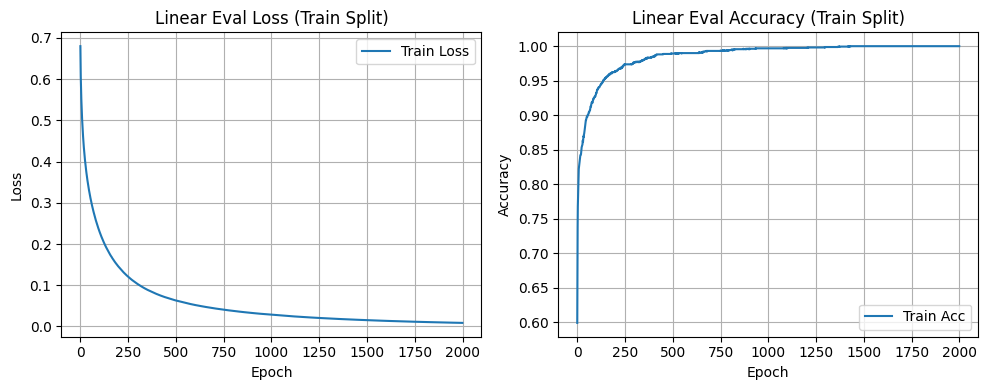

In [15]:
# Cell 15: Linear Eval Curves (Train Split Only)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lin_train_losses, label='Train Loss')
plt.title('Linear Eval Loss (Train Split)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.plot(lin_train_accs, label='Train Acc')
plt.title('Linear Eval Accuracy (Train Split)')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()


In [16]:
# Cell 16: Testing on 50%  Test Split

classifier.eval()
test_labels_all, test_probs_all, test_preds_all = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        feats = encoder_linear(imgs)
        logits = classifier(feats)
        probs = F.softmax(logits, dim=1)
        preds = logits.argmax(1)

        test_labels_all.append(labels.cpu().numpy())
        test_probs_all.append(probs.cpu().numpy())
        test_preds_all.append(preds.cpu().numpy())

test_labels_all = np.concatenate(test_labels_all)
test_probs_all = np.concatenate(test_probs_all)
test_preds_all  = np.concatenate(test_preds_all)

print("\nTest (70%) Classification Report:")
print(classification_report(test_labels_all, test_preds_all,
                            target_names=[IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]))



Test (70%) Classification Report:
                     precision    recall  f1-score   support

Monkeypox_augmented       0.98      0.93      0.95       706
   Others_augmented       0.94      0.99      0.97       890

           accuracy                           0.96      1596
          macro avg       0.96      0.96      0.96      1596
       weighted avg       0.96      0.96      0.96      1596



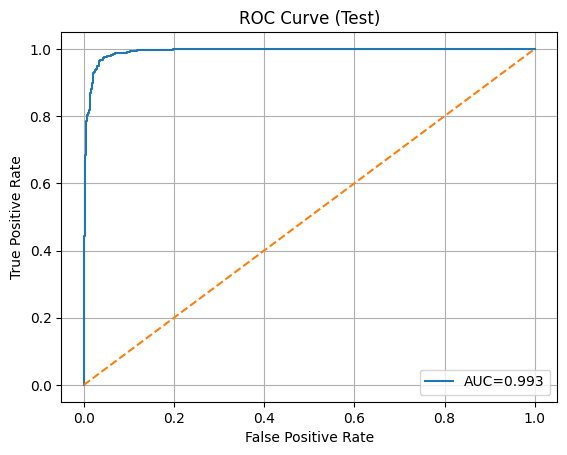

In [17]:
# Cell 17: ROC Curves (Multi-class or Binary)

if NUM_CLASSES == 2:
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, _ = roc_curve(test_labels_all, test_probs_all[:,1])
    auc = roc_auc_score(test_labels_all, test_probs_all[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1], [0,1], '--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Test)")
    plt.grid(True); plt.legend(); plt.show()
else:
    # One-vs-Rest ROC
    y_bin = label_binarize(test_labels_all, classes=list(range(NUM_CLASSES)))
    aucs = []
    plt.figure()
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_bin[:,i], test_probs_all[:,i])
        auc_i = roc_auc_score(y_bin[:,i], test_probs_all[:,i])
        aucs.append(auc_i)
        plt.plot(fpr, tpr, label=f"{IDX_TO_CLASS[i]} (AUC={auc_i:.3f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("Multi-class ROC Curve (OvR) - Test")
    plt.grid(True); plt.legend(); plt.show()
    print("Per-class AUCs:", {IDX_TO_CLASS[i]: f"{aucs[i]:.3f}" for i in range(NUM_CLASSES)})


Computing t-SNE on TEST features...


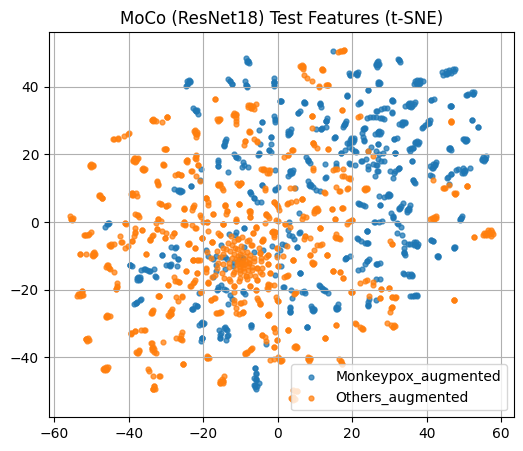

In [18]:
# Cell 18: t-SNE on TEST Features (Separability Check)

print("Computing t-SNE on TEST features...")
# Reuse the same frozen encoder (encoder_linear) for features
test_features, test_labels_for_vis = extract_features(test_loader, encoder_linear)
tsne_test = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=SEED)
tsne_test_2d = tsne_test.fit_transform(test_features)
plt.figure(figsize=(6,5))
for c in np.unique(test_labels_for_vis):
    idx = test_labels_for_vis == c
    plt.scatter(tsne_test_2d[idx,0], tsne_test_2d[idx,1], s=12, label=IDX_TO_CLASS[c], alpha=0.75)
plt.legend(); plt.title("MoCo (ResNet18) Test Features (t-SNE)"); plt.grid(True); plt.show()
